In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import sparse

In [4]:
dtr = pd.read_csv('data/train.csv')
dts = pd.read_csv('data/test.csv')

In [5]:
dtr.head()

,startTime,region,brand,model,carcassType,color,typeOfSteering,yearOfCar,engineType,engineCapacity,mileage,driveType,transmissionType,power,ownersCount,price
0,2016-07-01 00:00:43.000000,Рязанская область,Mitsubishi,Outlander,Внедорожник,Белый,Левый,2014,Бензин,2.0,45000,Полный,Вариатор,150.0,NaN,1200000.0
1,2016-07-01 00:01:11.000000,Москва,ВАЗ (LADA),2109,Хетчбэк,Серебряный,Левый,2002,Бензин,1.5,180000,Передний,Механика,78.0,NaN,58000.0
2,2016-07-01 00:01:12.000000,Санкт-Петербург,УАЗ,Patriot,Внедорожник,Зелёный,Левый,2015,Бензин,2.7,1,Полный,Механика,128.0,NaN,499000.0
3,2016-07-01 00:01:14.000000,Санкт-Петербург,Ford,Mondeo,Седан,Серый,Левый,2005,Бензин,2.0,160000,Передний,Автомат,146.0,2,249990.0
4,2016-07-01 00:01:42.000000,Тверская область,ГАЗ,ГАЗель,Фургон,Белый,Левый,2005,Бензин,2.4,100000,Задний,Механика,125.0,NaN,250000.0


In [9]:
dts.head()

,id,startTime,region,brand,model,carcassType,color,typeOfSteering,yearOfCar,engineType,engineCapacity,mileage,driveType,transmissionType,power,ownersCount
0,0,2016-12-01 00:00:33.000000,Саратовская область,Infiniti,G35,Седан,Бежевый,Левый,2008,Бензин,3.5,145000,Полный,Автомат,316.0,3
1,1,2016-12-01 00:00:36.000000,Москва,Skoda,Yeti,Внедорожник,Серебряный,Левый,2014,Бензин,1.2,47630,Передний,Механика,102.0,1
2,2,2016-12-01 00:00:52.000000,Тульская область,Peugeot,408,Седан,Белый,Левый,2012,Бензин,1.6,88000,Передний,Механика,113.0,1
3,3,2016-12-01 00:00:52.000000,Тверская область,Daewoo,Nexia,Седан,Серебряный,Левый,2012,Бензин,1.6,55766,Передний,Механика,109.0,1
4,4,2016-12-01 00:00:56.000000,Москва,Citroen,C4,Седан,Серый,Левый,2014,Бензин,1.6,30591,Передний,Автомат,150.0,1


Посмотрим на пропуски в данных.

In [6]:
dtr_missing = dtr.isnull().sum(axis=0).reset_index()
dtr_missing.columns = ['name', 'count']
dtr_missing = dtr_missing.loc[dtr_missing['count'] > 0]

In [10]:
dts_missing = dts.isnull().sum(axis=0).reset_index()
dts_missing.columns = ['name', 'count']
dts_missing = dts_missing.loc[dts_missing['count'] > 0]

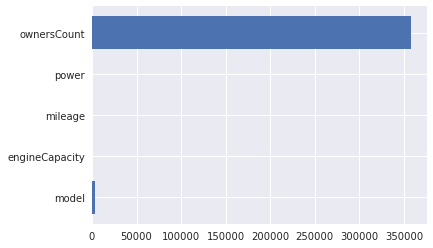

In [7]:
fig, ax = plt.subplots()
ind = np.arange(dtr_missing.shape[0])
_ = ax.barh(ind, dtr_missing['count'])
ax.set_yticks(ind)
ax.set_yticklabels(dtr_missing['name'].values, rotation='horizontal')

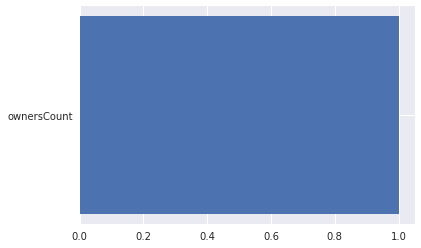

In [11]:
fig, ax = plt.subplots()
ind = np.arange(dts_missing.shape[0])
_ = ax.barh(ind, dts_missing['count'])
ax.set_yticks(ind)
ax.set_yticklabels(dts_missing['name'].values, rotation='horizontal')

Основную часть пропущенных данных составляют число владельцев. Заполним пропущенные данные в числе владельцев на произвольный атрибут, остальные пропуски удалим.

In [12]:
dtr['ownersCount'].unique()

array([nan, '2', '3', '4+', '1'], dtype=object)

In [13]:
dtr['ownersCount'].fillna(value='0', inplace=True)
dts['ownersCount'].fillna(value='0', inplace=True)

In [14]:
dtr.dropna(inplace=True)
dts.dropna(inplace=True)

Преобразуем текстовые данные пробега вида '# - #' в число.

In [15]:
import re
pattern = re.compile(r'\b\d+\b')

dtr['mileage'] = dtr['mileage'].apply(lambda x: np.mean(list(map(float, re.findall(pattern, x.replace(' ', ''))))) if type(x) is str else x)

In [16]:
dts['mileage'] = dts['mileage'].apply(lambda x: np.mean(list(map(float, re.findall(pattern, x.replace(' ', ''))))) if type(x) is str else x)

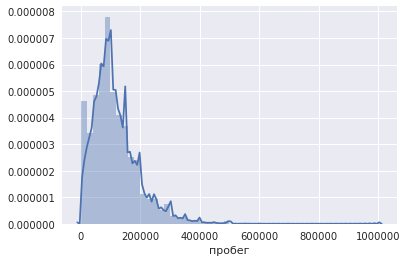

In [9]:
dtr['mileage'].describe()
ax = sns.distplot(dtr['mileage'])
ax.set_xlabel('пробег')

Поступим с объемом двигателя похожим образом.

In [12]:
dtr['engineCapacity'].unique()

array(['2.0', '1.5', '2.7', '2.4', '1.7', '1.6', '1.0', '1.4', '2.5',
       '1.1', '1.8', '4.7', '2.2', '3.0', '1.9', '4.4', '4.2', '3.8',
       '2.8', '1.2', '2.3', '2.9', '0.7', '5.5', '3.6', '4.6', '6.0+',
       '1.3', '3.5', '0.6', '4.0', '3.7', '4.5', '3.2', '4.8', '5.6',
       '4.3', '0.8', '2.6', '2.1', '3.4', '6.0', '5.0', '3.3', '5.3',
       '3.9', '5.2', '5.7', '5.9', '0.9', '4.1', '5.8', '5.4', '5.1',
       '3.1', '4.9'], dtype=object)

In [18]:
dtr.loc[dtr['engineCapacity'] == '6.0+', 'engineCapacity'] = 6.0
dts.loc[dts['engineCapacity'] == '6.0+', 'engineCapacity'] = 6.0

In [19]:
dtr['engineCapacity'] = dtr['engineCapacity'].astype(float)
dts['engineCapacity'] = dts['engineCapacity'].astype(float)

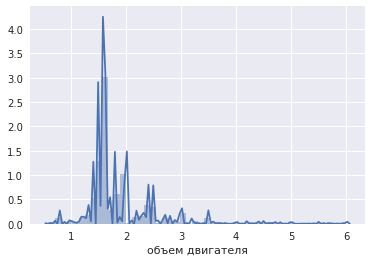

In [15]:
ax = sns.distplot(dtr['engineCapacity'])
ax.set_xlabel('объем двигателя')

In [20]:
dtr.loc[dtr['yearOfCar'] == 'до 1960', 'yearOfCar'] = 1960
dts.loc[dts['yearOfCar'] == 'до 1960', 'yearOfCar'] = 1960

In [21]:
dtr['yearOfCar'] = dtr['yearOfCar'].astype(int)
dts['yearOfCar'] = dts['yearOfCar'].astype(int)

count    2.183486e+06
mean     2.005796e+03
std      6.957180e+00
min      1.960000e+03
25%      2.002000e+03
50%      2.007000e+03
75%      2.011000e+03
max      2.017000e+03
Name: yearOfCar, dtype: float64

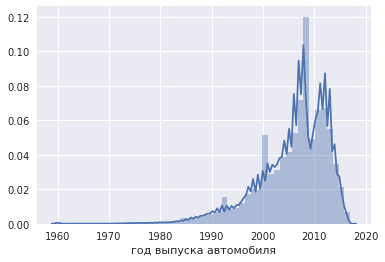

In [18]:
ax = sns.distplot(dtr['yearOfCar'])
ax.set_xlabel('год выпуска автомобиля')
dtr['yearOfCar'].describe()

In [13]:
dtr.apply(pd.Series.nunique)

startTime           1894662
region                   84
brand                   138
model                  1772
carcassType              12
color                    16
typeOfSteering            2
yearOfCar                58
engineType                5
engineCapacity           55
mileage               59197
driveType                 3
transmissionType          4
power                   873
ownersCount               5
price                 15709
dtype: int64

In [3]:
# list of categorical variables 
col_cat = ['region', 'brand', 'model', 'carcassType', 'color', 'typeOfSteering', 'engineType', 'driveType', 'transmissionType', 'ownersCount'] 
# list of categorical variables #
col_cat_ = ['region', 'brand', 'model'] 
# list of numerical variables 
col_num = ['yearOfCar', 'engineCapacity', 'mileage', 'power'] 
# col_num = ['yearOfCar', 'engineCapacity', 'mileage', 'power', 'power_to_cap', 'brand_model_median', 'xrate1', 'xrate2', 'xrate3']
# target variable 
col_tar = ['price']

Посмотрим на зависимости между целевой переменной.

In [22]:
mask = dtr[(dtr['price'] < dtr['price'].quantile(0.9999)) & (dtr['price'] > dtr['price'].quantile(0.0001))].index 

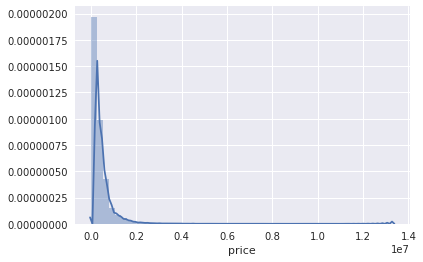

In [23]:
sns.distplot(dtr['price'][mask])

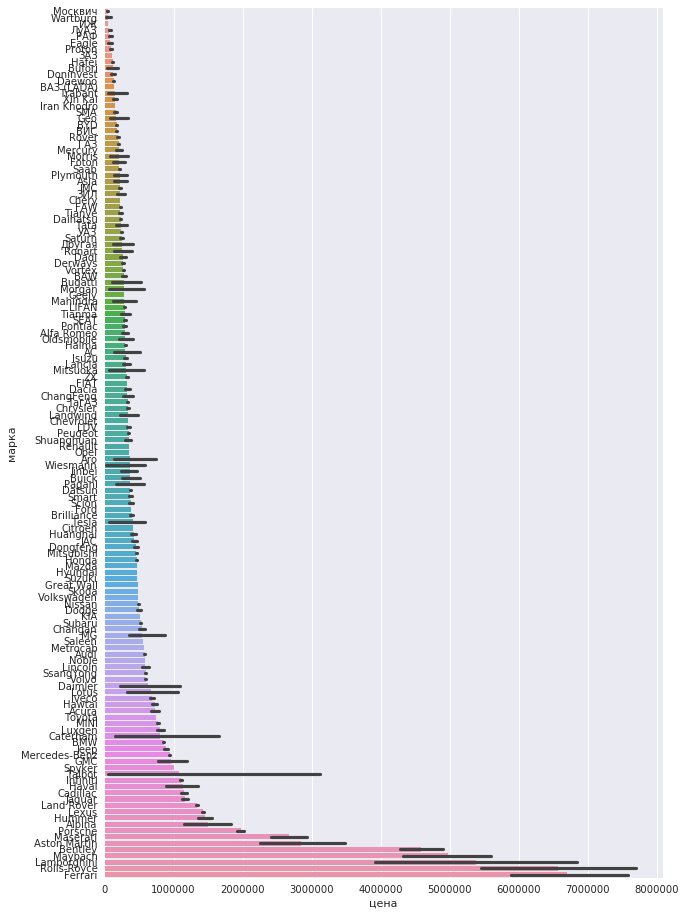

In [25]:
col = 'brand' 
plt.figure(figsize=(10, 16)) 
ax = sns.barplot(x='price', y=col, data=dtr.loc[mask], order=dtr.loc[mask][[col, 'price']].groupby(by=col).mean().sort_values(by='price').index) 
ax.set_ylabel('марка')
ax.set_xlabel('цена')

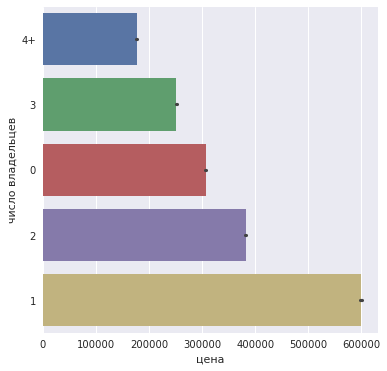

In [28]:
col = 'ownersCount' 
plt.figure(figsize=(6, 6)) 
ax = sns.barplot(x='price', y=col, data=dtr.loc[mask], order=dtr.loc[mask][[col, 'price']].groupby(by=col).mean().sort_values(by='price').index) 
ax.set_ylabel('число владельцев')
ax.set_xlabel('цена')

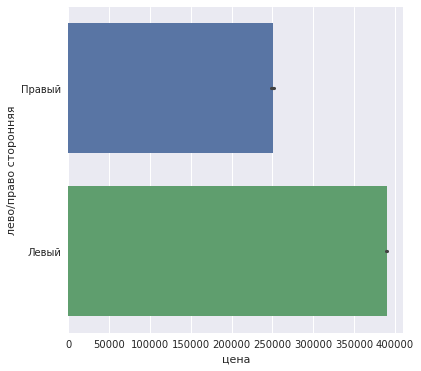

In [27]:
col = 'typeOfSteering' 
plt.figure(figsize=(6, 6)) 
ax = sns.barplot(x='price', y=col, data=dtr.loc[mask], order=dtr.loc[mask][[col, 'price']].groupby(by=col).mean().sort_values(by='price').index)
ax.set_ylabel('лево/право сторонняя')
ax.set_xlabel('цена')

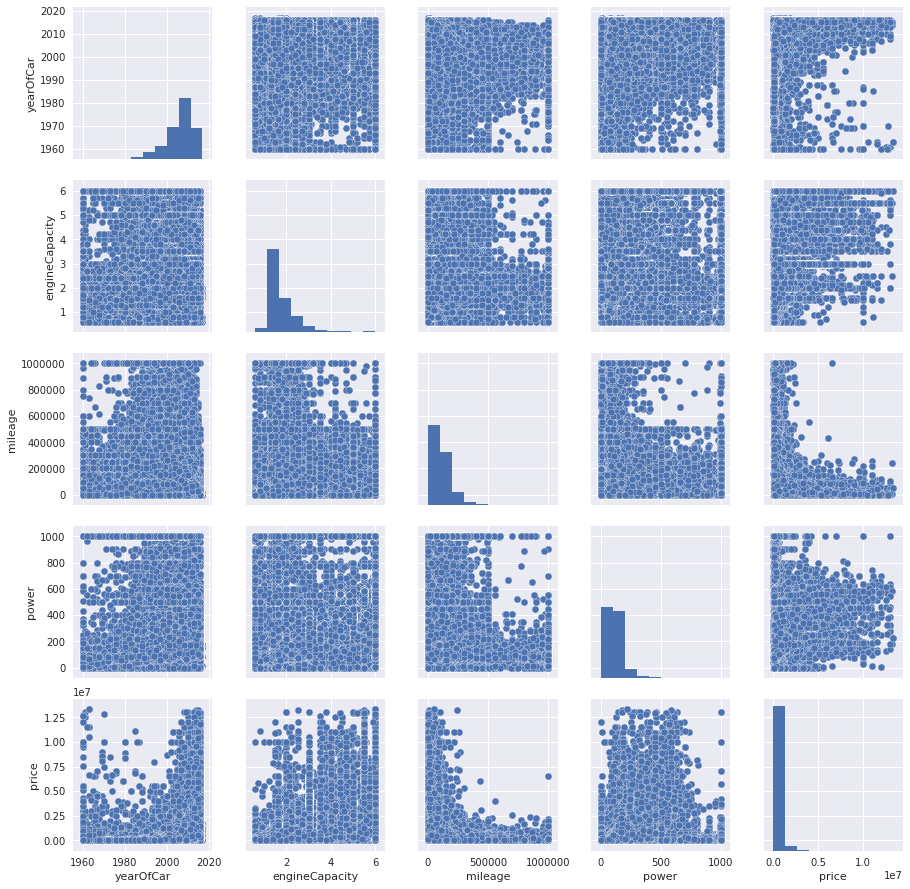

In [29]:
sns.pairplot(data=dtr.loc[mask][col_num + col_tar])

Посмотрим на выбросы в целевой переменной.

count    2.183486e+06
mean     2.005298e+06
std      7.861775e+08
min      0.000000e+00
25%      1.100000e+05
50%      2.490000e+05
75%      4.750000e+05
max      1.000000e+12
Name: price, dtype: float64

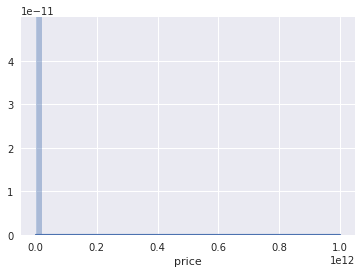

In [15]:
sns.distplot(dtr['price'])
dtr['price'].describe()

Средняя цена всех категорий автомобилей составляет ~250 тысяч едениц. Понятно, что она отличается в разы по маркам, пробегу, году выпуска. 
Для поиска выбросов, воспользуемся какой-нибудь простой моделью, устройчивой к ним.

In [25]:
for col in col_cat:
    enc = LabelEncoder()
    enc.fit(list(dtr[col].values) + list(dts[col].values))
    dtr[col] = enc.transform(dtr[col])
    dts[col] = enc.transform(dts[col])
    # dtr[col] = enc.fit_transform(dtr[col])
    dtr[col] = dtr[col].astype('category')
    dts[col] = dts[col].astype('category')

In [26]:
enc = OneHotEncoder()
scaler = StandardScaler()
X = np.array(dtr[col_num])
X = scaler.fit_transform(X)
X = sparse.hstack([X, enc.fit_transform(dtr[col_cat])])

In [27]:
y = np.array(dtr[col_tar])
y_ = np.log1p(y)

In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

In [19]:
param_grid = {
    'eta0': [1, 5, 10],
    'alpha': [0.00001, 0.0001],
    'l1_ratio': [0.0],
    'n_iter': [300]
}

In [30]:
grid = GridSearchCV(SGDRegressor(loss='huber', penalty='l1', verbose=10), param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=64) 
grid.fit(X, y)

-- Epoch 1
Norm: 11619.68, NNZs: 770, Bias: 60.877832, T: 1746788, Avg. loss: 222065.942954
Total training time: 0.72 seconds.
-- Epoch 2
-- Epoch 1
Norm: 19041.32, NNZs: 762, Bias: 99.863951, T: 3493576, Avg. loss: 221285.435222
Total training time: 1.47 seconds.
-- Epoch 3
Norm: 11544.66, NNZs: 775, Bias: 60.803245, T: 1746789, Avg. loss: 213750.871950
-- Epoch 2
-- Epoch 1
Total training time: 0.76 seconds.
Norm: 25070.20, NNZs: 751, Bias: 131.579837, T: 5240364, Avg. loss: 220658.621333
Total training time: 2.22 seconds.
-- Epoch 4
Norm: 11526.42, NNZs: 774, Bias: 60.736479, T: 1746789, Avg. loss: 141229.515671
Total training time: 0.69 seconds.
-- Epoch 2
Norm: 18928.59, NNZs: 769, Bias: 99.796057, T: 3493578, Avg. loss: 212979.245873
Total training time: 1.52 seconds.
-- Epoch 3
-- Epoch 1
Norm: 30248.33, NNZs: 746, Bias: 158.810149, T: 6987152, Avg. loss: 220129.337290
Total training time: 2.97 seconds.
-- Epoch 5
Norm: 18890.91, NNZs: 771, Bias: 99.652201, T: 3493578, Avg. loss

-- Epoch 12
Norm: 69844.40, NNZs: 730, Bias: 364.595567, T: 3493578, Avg. loss: 190541.385988
Total training time: 1.60 seconds.
-- Epoch 3
Norm: 42353.57, NNZs: 740, Bias: 223.700480, T: 12227523, Avg. loss: 193006.674690
Total training time: 5.63 seconds.
-- Epoch 8
Norm: 111210.74, NNZs: 707, Bias: 554.693472, T: 8733945, Avg. loss: 204930.819223
Total training time: 4.11 seconds.
-- Epoch 6
Norm: 55225.07, NNZs: 733, Bias: 290.208001, T: 19214679, Avg. loss: 209429.640516
Total training time: 8.39 seconds.
-- Epoch 12
Norm: 99109.54, NNZs: 716, Bias: 502.284741, T: 6987156, Avg. loss: 215553.836723
Total training time: 3.10 seconds.
-- Epoch 5
-- Epoch 1
Norm: 130935.46, NNZs: 685, Bias: 630.840458, T: 12227516, Avg. loss: 211844.369767
Norm: 49036.87, NNZs: 742, Bias: 258.530534, T: 15721101, Avg. loss: 219710.376128
Total training time: 5.48 seconds.
Total training time: 7.01 seconds.
-- Epoch 8
-- Epoch 10
Norm: 110721.46, NNZs: 710, Bias: 552.887555, T: 8733945, Avg. loss: 1324

-- Epoch 9
Norm: 161546.70, NNZs: 664, Bias: 744.733521, T: 19214668, Avg. loss: 209920.836385
Norm: 60278.07, NNZs: 734, Bias: 316.339947, T: 22708257, Avg. loss: 218698.308514
Total training time: 8.61 seconds.
Total training time: 10.14 seconds.
-- Epoch 12
-- Epoch 14
Norm: 146336.81, NNZs: 679, Bias: 694.819719, T: 15721101, Avg. loss: 130117.959213
Total training time: 7.21 seconds.
-- Epoch 10
Norm: 62883.90, NNZs: 737, Bias: 329.463379, T: 24455046, Avg. loss: 136239.843254
Total training time: 11.13 seconds.
-- Epoch 15
Norm: 68064.25, NNZs: 729, Bias: 353.111267, T: 27948608, Avg. loss: 216590.357218
Total training time: 12.71 seconds.
-- Epoch 17
Norm: 185862.62, NNZs: 664, Bias: 830.467050, T: 10480728, Avg. loss: 208509.276978
Total training time: 4.98 seconds.
-- Epoch 7
Norm: 171275.66, NNZs: 667, Bias: 785.581123, T: 8733945, Avg. loss: 201092.286434
Total training time: 4.30 seconds.
-- Epoch 6
Norm: 154316.35, NNZs: 677, Bias: 724.269786, T: 17467890, Avg. loss: 20210

-- Epoch 2
Norm: 173652.66, NNZs: 667, Bias: 793.987096, T: 22708257, Avg. loss: 200953.826633
Total training time: 10.70 seconds.
-- Epoch 14
-- Epoch 1
Norm: 65150.96, NNZs: 731, Bias: 341.137155, T: 26201835, Avg. loss: 190941.736139
Total training time: 12.31 seconds.
-- Epoch 16
Norm: 18846.97, NNZs: 326, Bias: 99.556952, T: 3493578, Avg. loss: 222692.972250
Total training time: 1.66 seconds.
-- Epoch 3
Norm: 218042.02, NNZs: 645, Bias: 945.288757, T: 15721092, Avg. loss: 206737.733072
Total training time: 7.77 seconds.
-- Epoch 10
Norm: 24846.12, NNZs: 322, Bias: 131.357856, T: 5240367, Avg. loss: 139850.242344
Total training time: 2.45 seconds.
-- Epoch 4
Norm: 34793.47, NNZs: 315, Bias: 182.928586, T: 8733940, Avg. loss: 219677.550832
Total training time: 3.99 seconds.
-- Epoch 6
Norm: 208193.09, NNZs: 657, Bias: 917.023895, T: 13974312, Avg. loss: 199024.627146
Total training time: 7.06 seconds.
-- Epoch 9
Norm: 74209.46, NNZs: 730, Bias: 385.471325, T: 33188991, Avg. loss: 20

Total training time: 10.71 seconds.
-- Epoch 13
Norm: 183952.45, NNZs: 665, Bias: 831.070160, T: 26201835, Avg. loss: 127904.470758
Total training time: 12.38 seconds.
-- Epoch 16
Norm: 47639.18, NNZs: 311, Bias: 251.620503, T: 1746789, Avg. loss: 137618.549825
Total training time: 0.95 seconds.
-- Epoch 2
Norm: 189840.32, NNZs: 668, Bias: 851.321734, T: 27948624, Avg. loss: 200034.553191
Norm: 86722.82, NNZs: 303, Bias: 443.532854, T: 5240364, Avg. loss: 215058.739716
Total training time: 13.24 seconds.
Total training time: 2.52 seconds.
-- Epoch 4
-- Epoch 17
Norm: 71750.33, NNZs: 731, Bias: 374.003726, T: 31442202, Avg. loss: 190381.213035
Total training time: 14.82 seconds.
-- Epoch 19
Norm: 46191.54, NNZs: 308, Bias: 242.483821, T: 13974304, Avg. loss: 218570.053205
Total training time: 6.35 seconds.
-- Epoch 9
Norm: 34473.82, NNZs: 318, Bias: 182.399365, T: 8733945, Avg. loss: 221109.315903
Total training time: 4.12 seconds.
-- Epoch 6
Norm: 239590.68, NNZs: 631, Bias: 1027.24668

Total training time: 9.83 seconds.
-- Epoch 13
Norm: 244599.73, NNZs: 634, Bias: 1056.040201, T: 22708257, Avg. loss: 197072.127781
Total training time: 11.37 seconds.
-- Epoch 14
Norm: 208141.99, NNZs: 652, Bias: 909.288559, T: 34935760, Avg. loss: 207275.430637
Total training time: 16.06 seconds.
-- Epoch 21
Norm: 79552.01, NNZs: 727, Bias: 411.729298, T: 38429358, Avg. loss: 217071.622964
Total training time: 17.64 seconds.
-- Epoch 23
Norm: 45837.25, NNZs: 311, Bias: 242.178662, T: 13974312, Avg. loss: 137787.225190
Total training time: 6.91 seconds.
-- Epoch 9
Norm: 237957.63, NNZs: 634, Bias: 1032.813658, T: 20961468, Avg. loss: 179925.196738
Total training time: 9.19 seconds.
-- Epoch 13
Norm: 81562.37, NNZs: 730, Bias: 421.281930, T: 40176147, Avg. loss: 134675.690339
Total training time: 18.52 seconds.
-- Epoch 24
Norm: 193418.77, NNZs: 663, Bias: 865.091576, T: 29695413, Avg. loss: 209641.128259
Total training time: 13.90 seconds.
-- Epoch 18
Norm: 85904.55, NNZs: 305, Bias: 

Total training time: 13.34 seconds.
-- Epoch 16
Norm: 202240.95, NNZs: 659, Bias: 896.847273, T: 33188991, Avg. loss: 209160.677000
Total training time: 15.74 seconds.
-- Epoch 20
Norm: 89038.85, NNZs: 714, Bias: 453.360896, T: 47163276, Avg. loss: 214861.806892
Total training time: 21.94 seconds.
-- Epoch 28
Norm: 52035.67, NNZs: 313, Bias: 274.626258, T: 17467890, Avg. loss: 192109.810373
Total training time: 7.33 seconds.
-- Epoch 11
Norm: 85071.34, NNZs: 726, Bias: 437.909542, T: 43669725, Avg. loss: 134395.442387
Total training time: 20.43 seconds.
-- Epoch 26
-- Epoch 1
Norm: 139035.84, NNZs: 291, Bias: 669.006163, T: 13974312, Avg. loss: 203081.101915
Norm: 99068.91, NNZs: 296, Bias: 503.703932, T: 6987156, Avg. loss: 188239.289550
Total training time: 5.96 seconds.
Total training time: 3.73 seconds.
-- Epoch 5
-- Epoch 9
Norm: 81400.58, NNZs: 730, Bias: 420.859801, T: 40176147, Avg. loss: 189589.707675
Total training time: 19.02 seconds.
-- Epoch 24
Norm: 155136.98, NNZs: 287, 

Total training time: 6.83 seconds.
-- Epoch 8
Norm: 88414.38, NNZs: 723, Bias: 453.554554, T: 47163303, Avg. loss: 134132.367118
Total training time: 22.19 seconds.
-- Epoch 28
Norm: 210142.01, NNZs: 651, Bias: 925.670249, T: 36682569, Avg. loss: 208734.876543
Total training time: 17.61 seconds.
-- Epoch 22
Norm: 154223.22, NNZs: 287, Bias: 726.464132, T: 17467890, Avg. loss: 202135.682423
Total training time: 7.66 seconds.
-- Epoch 11
Norm: 154111.75, NNZs: 288, Bias: 726.342348, T: 6987156, Avg. loss: 129669.328694
Total training time: 3.22 seconds.
-- Epoch 5
Norm: 65703.74, NNZs: 308, Bias: 341.994405, T: 26201820, Avg. loss: 216804.316177
Norm: 84900.09, NNZs: 727, Bias: 437.469359, T: 43669725, Avg. loss: 189310.686580
Total training time: 12.25 seconds.
Total training time: 20.74 seconds.
-- Epoch 16
-- Epoch 26
Norm: 261913.88, NNZs: 632, Bias: 1129.974999, T: 29695413, Avg. loss: 196150.015047
Total training time: 15.33 seconds.
-- Epoch 18
Norm: 218527.74, NNZs: 654, Bias: 95

Total training time: 9.41 seconds.
-- Epoch 13
Norm: 62700.48, NNZs: 309, Bias: 329.186701, T: 24455046, Avg. loss: 218495.663880
Total training time: 11.73 seconds.
-- Epoch 15
Norm: 224936.07, NNZs: 648, Bias: 978.937099, T: 43669725, Avg. loss: 198121.095673
Total training time: 20.94 seconds.
-- Epoch 26
Norm: 170111.17, NNZs: 286, Bias: 785.783360, T: 8733945, Avg. loss: 183646.741268
Total training time: 3.57 seconds.
-- Epoch 6
Norm: 274295.17, NNZs: 611, Bias: 1178.331033, T: 36682548, Avg. loss: 203715.626778
Norm: 70219.59, NNZs: 308, Bias: 364.387574, T: 29695396, Avg. loss: 216415.856648
Total training time: 17.89 seconds.
-- Epoch 22
Total training time: 14.05 seconds.
-- Epoch 18
Norm: 170073.63, NNZs: 284, Bias: 784.847807, T: 8733945, Avg. loss: 210984.142264
Total training time: 4.31 seconds.
-- Epoch 6
Norm: 206456.18, NNZs: 662, Bias: 913.051924, T: 34935780, Avg. loss: 181598.866199
Total training time: 18.67 seconds.
-- Epoch 21
Norm: 185339.00, NNZs: 279, Bias: 83

Total training time: 6.87 seconds.
-- Epoch 9
Norm: 230730.73, NNZs: 643, Bias: 1001.087406, T: 47163303, Avg. loss: 197811.373830
Total training time: 22.84 seconds.
-- Epoch 28
Norm: 277697.48, NNZs: 611, Bias: 1207.748744, T: 40176147, Avg. loss: 122883.550562
Total training time: 18.19 seconds.
-- Epoch 24
Norm: 67353.56, NNZs: 308, Bias: 352.616177, T: 27948624, Avg. loss: 218095.568487
Total training time: 13.71 seconds.
-- Epoch 17
Norm: 273793.07, NNZs: 625, Bias: 1185.684479, T: 36682569, Avg. loss: 195513.575857
Total training time: 19.06 seconds.
-- Epoch 22
Norm: 69570.27, NNZs: 308, Bias: 363.876982, T: 29695413, Avg. loss: 190575.032454
Total training time: 13.10 seconds.
-- Epoch 18
Norm: 278922.71, NNZs: 605, Bias: 1201.416494, T: 40176124, Avg. loss: 203465.101876
Total training time: 20.06 seconds.
-- Epoch 24
Norm: 196449.58, NNZs: 276, Bias: 880.890759, T: 12227523, Avg. loss: 182180.393017
Total training time: 5.77 seconds.
-- Epoch 8
Norm: 273068.44, NNZs: 619, Bi

-- Epoch 20
Norm: 71665.26, NNZs: 305, Bias: 374.056286, T: 31442202, Avg. loss: 217731.785984
Total training time: 15.55 seconds.
-- Epoch 19
Norm: 278446.03, NNZs: 609, Bias: 1208.923645, T: 40176147, Avg. loss: 195263.489607
Total training time: 20.88 seconds.
-- Epoch 24
Norm: 277770.47, NNZs: 608, Bias: 1210.090145, T: 40176147, Avg. loss: 177826.220624
Norm: 78089.12, NNZs: 304, Bias: 405.087168, T: 36682569, Avg. loss: 207474.045543
Total training time: 18.69 seconds.
Total training time: 17.20 seconds.
-- Epoch 24
-- Epoch 22
Norm: 73876.02, NNZs: 307, Bias: 384.861437, T: 33188991, Avg. loss: 135315.326702
Total training time: 16.46 seconds.
-- Epoch 20
Norm: 172485.22, NNZs: 285, Bias: 794.336754, T: 22708257, Avg. loss: 183510.333226
Total training time: 11.20 seconds.
-- Epoch 14
Norm: 216432.56, NNZs: 267, Bias: 954.719229, T: 15721101, Avg. loss: 181111.431813
Total training time: 7.57 seconds.
-- Epoch 10
Norm: 220734.44, NNZs: 649, Bias: 965.998545, T: 41922936, Avg. lo

Norm: 240748.07, NNZs: 637, Bias: 1040.455173, T: 54150459, Avg. loss: 197276.945484
Total training time: 26.48 seconds.
-- Epoch 32
Norm: 232900.59, NNZs: 262, Bias: 1015.044746, T: 19214679, Avg. loss: 197750.155400
Total training time: 11.30 seconds.
-- Epoch 12
Norm: 183586.93, NNZs: 281, Bias: 834.412013, T: 26201835, Avg. loss: 182885.889492
Total training time: 12.81 seconds.
-- Epoch 16
Norm: 231834.14, NNZs: 259, Bias: 1014.138910, T: 19214679, Avg. loss: 180302.085541
Total training time: 9.32 seconds.
-- Epoch 12
Norm: 203520.92, NNZs: 272, Bias: 904.361694, T: 33188991, Avg. loss: 199321.114977
Total training time: 15.32 seconds.
Norm: 204087.26, NNZs: 269, Bias: 899.007882, T: 33188972, Avg. loss: 207539.208965
Total training time: 16.10 seconds.
-- Epoch 20
-- Epoch 20
Norm: 226843.33, NNZs: 643, Bias: 989.261957, T: 45416514, Avg. loss: 180511.934906
Total training time: 24.48 seconds.
-- Epoch 27
Norm: 255194.86, NNZs: 248, Bias: 1097.796206, T: 26201820, Avg. loss: 204

Norm: 103236.76, NNZs: 719, Bias: 520.521180, T: 64631193, Avg. loss: 133010.935636
Total training time: 31.43 seconds.
-- Epoch 38
Norm: 287671.68, NNZs: 602, Bias: 1257.491246, T: 48910092, Avg. loss: 194768.888589
Total training time: 24.55 seconds.
-- Epoch 29
Norm: 212076.71, NNZs: 265, Bias: 928.047074, T: 36682548, Avg. loss: 207106.204479
Total training time: 17.73 seconds.
-- Epoch 22
Norm: 211488.24, NNZs: 266, Bias: 933.556555, T: 36682569, Avg. loss: 198890.632062
Total training time: 17.03 seconds.
-- Epoch 22
Norm: 197952.90, NNZs: 275, Bias: 885.486599, T: 31442202, Avg. loss: 209433.689585
Total training time: 15.55 seconds.
-- Epoch 19
Norm: 232379.25, NNZs: 638, Bias: 1010.732308, T: 48910092, Avg. loss: 180219.699151
Total training time: 26.25 seconds.
-- Epoch 29
Norm: 106367.18, NNZs: 711, Bias: 533.884566, T: 68124771, Avg. loss: 205278.174366
Total training time: 32.50 seconds.
-- Epoch 40
Norm: 250042.97, NNZs: 252, Bias: 1084.888948, T: 24455046, Avg. loss: 196

Norm: 198361.48, NNZs: 273, Bias: 886.549145, T: 31442202, Avg. loss: 127147.827772
Total training time: 17.97 seconds.
-- Epoch 19
Norm: 290684.10, NNZs: 599, Bias: 1274.029031, T: 52403670, Avg. loss: 194609.418044
Total training time: 26.30 seconds.
-- Epoch 31
Norm: 206340.94, NNZs: 270, Bias: 916.197699, T: 34935780, Avg. loss: 208982.510138
Total training time: 17.23 seconds.
-- Epoch 21
Norm: 86694.06, NNZs: 305, Bias: 446.446480, T: 45416514, Avg. loss: 134280.703276
Total training time: 21.85 seconds.
-- Epoch 27
Norm: 248254.41, NNZs: 632, Bias: 1073.024998, T: 61137615, Avg. loss: 124444.213100
Total training time: 29.60 seconds.
-- Epoch 36
Norm: 108980.18, NNZs: 708, Bias: 545.149333, T: 71618349, Avg. loss: 205089.760847
Total training time: 34.27 seconds.
-- Epoch 42
Norm: 269629.44, NNZs: 238, Bias: 1163.306313, T: 33188972, Avg. loss: 204050.432049
Total training time: 15.95 seconds.
-- Epoch 20
Norm: 253694.97, NNZs: 249, Bias: 1104.633958, T: 26201835, Avg. loss: 179

Norm: 275161.27, NNZs: 234, Bias: 1190.247471, T: 36682548, Avg. loss: 203758.209330
Total training time: 17.51 seconds.
-- Epoch 22
Norm: 293775.93, NNZs: 596, Bias: 1281.252900, T: 55897216, Avg. loss: 202667.177956
Total training time: 28.95 seconds.
-- Epoch 33
Norm: 93743.64, NNZs: 297, Bias: 475.839821, T: 52403640, Avg. loss: 214509.746384
Total training time: 25.14 seconds.
-- Epoch 31
Norm: 111521.65, NNZs: 708, Bias: 555.995314, T: 75111927, Avg. loss: 204908.535366
Total training time: 35.98 seconds.
-- Epoch 44
Norm: 89776.31, NNZs: 302, Bias: 461.240600, T: 48910092, Avg. loss: 188942.894761
Total training time: 22.22 seconds.
-- Epoch 29
Norm: 256700.12, NNZs: 627, Bias: 1097.726893, T: 68124732, Avg. loss: 204662.753980
Total training time: 32.96 seconds.
-- Epoch 40
Norm: 251921.19, NNZs: 628, Bias: 1088.475955, T: 64631193, Avg. loss: 124250.449405
Total training time: 31.43 seconds.
-- Epoch 38
Norm: 206761.27, NNZs: 269, Bias: 917.230249, T: 34935780, Avg. loss: 1266

-- Epoch 35
Norm: 96769.38, NNZs: 297, Bias: 489.487849, T: 55897216, Avg. loss: 214278.420107
Total training time: 26.86 seconds.
-- Epoch 33
Norm: 295923.11, NNZs: 590, Bias: 1303.528036, T: 59390826, Avg. loss: 194337.122436
Total training time: 29.92 seconds.
-- Epoch 35
Norm: 93470.47, NNZs: 300, Bias: 477.565512, T: 52403670, Avg. loss: 206255.847209
Total training time: 26.19 seconds.
-- Epoch 31
Norm: 113996.39, NNZs: 706, Bias: 566.451640, T: 78605505, Avg. loss: 204733.911990
Total training time: 37.75 seconds.
-- Epoch 46
Norm: 297527.57, NNZs: 589, Bias: 1315.472099, T: 62884404, Avg. loss: 121844.724965
Total training time: 29.26 seconds.
-- Epoch 37
Norm: 259806.43, NNZs: 627, Bias: 1111.262996, T: 71618308, Avg. loss: 204496.079671
Total training time: 34.73 seconds.
-- Epoch 42
Norm: 115489.76, NNZs: 701, Bias: 568.893677, T: 80352248, Avg. loss: 212896.053740
Total training time: 38.62 seconds.
-- Epoch 47
Norm: 233655.25, NNZs: 261, Bias: 1017.992981, T: 48910092, Avg

-- Epoch 48
Norm: 299686.35, NNZs: 588, Bias: 1327.845285, T: 66377982, Avg. loss: 121737.805528
Total training time: 30.98 seconds.
-- Epoch 39
Norm: 227014.08, NNZs: 260, Bias: 995.248575, T: 45416514, Avg. loss: 180554.514569
Total training time: 21.92 seconds.
-- Epoch 27
Norm: 238706.60, NNZs: 258, Bias: 1038.122853, T: 52403670, Avg. loss: 197443.650068
Total training time: 24.18 seconds.
-- Epoch 31
Norm: 262687.19, NNZs: 626, Bias: 1124.060606, T: 75111884, Avg. loss: 204341.543442
Total training time: 36.47 seconds.
-- Epoch 44
Norm: 97560.90, NNZs: 298, Bias: 496.459680, T: 57644037, Avg. loss: 133447.261661
Total training time: 27.25 seconds.
-- Epoch 34
Norm: 256418.30, NNZs: 627, Bias: 1109.227359, T: 69871560, Avg. loss: 206285.826522
Total training time: 34.17 seconds.
-- Epoch 41
Norm: 117873.16, NNZs: 698, Bias: 578.709497, T: 83845824, Avg. loss: 212729.693640
Total training time: 40.37 seconds.
-- Epoch 49
Norm: 239323.14, NNZs: 256, Bias: 1031.943399, T: 52403640, A

-- Epoch 33
Norm: 259425.72, NNZs: 626, Bias: 1122.559158, T: 73365138, Avg. loss: 206127.343008
-- Epoch 46
Total training time: 35.91 seconds.
-- Epoch 43
Norm: 120200.16, NNZs: 697, Bias: 588.202247, T: 87339400, Avg. loss: 212568.791574
Total training time: 42.11 seconds.
-- Epoch 51
Norm: 276433.38, NNZs: 233, Bias: 1211.362000, T: 38429358, Avg. loss: 177989.206326
Total training time: 20.05 seconds.
-- Epoch 23
Norm: 300689.28, NNZs: 587, Bias: 1320.956345, T: 66377944, Avg. loss: 202312.907830
Total training time: 34.41 seconds.
-- Epoch 39
Norm: 117071.56, NNZs: 709, Bias: 579.543410, T: 83845872, Avg. loss: 132029.043604
Total training time: 40.66 seconds.
-- Epoch 49
Norm: 253572.11, NNZs: 627, Bias: 1097.448093, T: 66377982, Avg. loss: 179104.427818
Total training time: 35.20 seconds.
-- Epoch 39
Norm: 298130.16, NNZs: 583, Bias: 1321.049926, T: 64631193, Avg. loss: 204094.810724
Total training time: 32.13 seconds.
-- Epoch 38
Norm: 114445.45, NNZs: 707, Bias: 569.111211, T

Total training time: 27.06 seconds.
-- Epoch 28
Norm: 290950.25, NNZs: 220, Bias: 1274.118733, T: 50656852, Avg. loss: 202930.942184
Total training time: 24.83 seconds.
-- Epoch 30
Norm: 300225.04, NNZs: 581, Bias: 1333.061332, T: 68124771, Avg. loss: 203992.608134
Total training time: 33.89 seconds.
-- Epoch 40
Norm: 116807.72, NNZs: 707, Bias: 578.981558, T: 83845872, Avg. loss: 186955.217822
Norm: 237679.80, NNZs: 258, Bias: 1037.537975, T: 52403670, Avg. loss: 179997.593452
Total training time: 40.90 seconds.
Total training time: 25.61 seconds.
-- Epoch 49
-- Epoch 31
Norm: 284243.18, NNZs: 224, Bias: 1252.278586, T: 45416514, Avg. loss: 204915.189092
Total training time: 22.71 seconds.
-- Epoch 27
Norm: 302694.87, NNZs: 587, Bias: 1332.596966, T: 69871520, Avg. loss: 202214.164618
Total training time: 36.37 seconds.
-- Epoch 41
Norm: 117935.02, NNZs: 702, Bias: 583.078369, T: 85592661, Avg. loss: 214212.182222
Total training time: 41.79 seconds.
-- Epoch 50
Norm: 280928.04, NNZs: 

Total training time: 25.79 seconds.
-- Epoch 28
Norm: 107879.90, NNZs: 293, Bias: 538.206842, T: 69871520, Avg. loss: 213455.379316
Total training time: 34.10 seconds.
-- Epoch 41
Norm: 119114.02, NNZs: 706, Bias: 588.531280, T: 87339450, Avg. loss: 186797.274949
Norm: 302200.81, NNZs: 586, Bias: 1344.452140, T: 71618349, Avg. loss: 203898.455904
Total training time: 42.64 seconds.
-- Epoch 51
Total training time: 35.66 seconds.
-- Epoch 42
Norm: 303857.11, NNZs: 587, Bias: 1353.783517, T: 73365138, Avg. loss: 176487.001592
Total training time: 34.95 seconds.
-- Epoch 43
Norm: 120215.87, NNZs: 697, Bias: 592.469430, T: 89086239, Avg. loss: 214056.830726
Total training time: 43.47 seconds.
-- Epoch 52
Norm: 107140.08, NNZs: 296, Bias: 538.811914, T: 69871560, Avg. loss: 132745.146830
Total training time: 32.76 seconds.
-- Epoch 41
Norm: 287722.40, NNZs: 220, Bias: 1271.353556, T: 48910092, Avg. loss: 204737.535802
Total training time: 24.54 seconds.
-- Epoch 29
Norm: 102906.16, NNZs: 29

Total training time: 41.36 seconds.
-- Epoch 49
Norm: 110454.35, NNZs: 295, Bias: 549.190086, T: 73365096, Avg. loss: 213270.475797
Total training time: 35.96 seconds.
-- Epoch 43
Norm: 256650.91, NNZs: 247, Bias: 1113.431591, T: 68124771, Avg. loss: 196500.640501
Total training time: 31.40 seconds.
-- Epoch 40
Norm: 304068.03, NNZs: 586, Bias: 1355.182252, T: 75111927, Avg. loss: 203811.338297
Total training time: 37.53 seconds.
-- Epoch 44
Norm: 109698.00, NNZs: 294, Bias: 549.852692, T: 73365138, Avg. loss: 132562.740248
Total training time: 34.53 seconds.
-- Epoch 43
Norm: 306396.25, NNZs: 585, Bias: 1354.100232, T: 76858672, Avg. loss: 202038.479057
Total training time: 39.90 seconds.
-- Epoch 45
Norm: 257220.50, NNZs: 247, Bias: 1106.630922, T: 68124732, Avg. loss: 204705.146008
Total training time: 32.28 seconds.
-- Epoch 40
Norm: 105568.26, NNZs: 294, Bias: 531.959944, T: 68124771, Avg. loss: 215097.758713
Total training time: 33.82 seconds.
Norm: 290561.17, NNZs: 222, Bias: 12

Total training time: 32.37 seconds.
-- Epoch 34
Norm: 108154.36, NNZs: 294, Bias: 543.183886, T: 71618349, Avg. loss: 214912.661184
Total training time: 35.49 seconds.
-- Epoch 42
Norm: 264007.78, NNZs: 628, Bias: 1143.779125, T: 78605505, Avg. loss: 178555.014985
Total training time: 42.37 seconds.
-- Epoch 46
Norm: 110704.83, NNZs: 293, Bias: 554.682524, T: 75111927, Avg. loss: 187398.260178
Total training time: 34.80 seconds.
-- Epoch 44
Norm: 271051.36, NNZs: 624, Bias: 1174.919905, T: 89086239, Avg. loss: 123237.470491
Total training time: 44.00 seconds.
-- Epoch 52
Norm: 112960.42, NNZs: 293, Bias: 559.775062, T: 76858672, Avg. loss: 213092.475312
Total training time: 37.84 seconds.
-- Epoch 45
Norm: 293540.35, NNZs: 219, Bias: 1299.156487, T: 54150459, Avg. loss: 194579.323941
Total training time: 29.60 seconds.
-- Epoch 32
Norm: 305843.72, NNZs: 583, Bias: 1365.337616, T: 78605505, Avg. loss: 203730.407427
Total training time: 39.42 seconds.
-- Epoch 46
Norm: 252290.79, NNZs: 2

Total training time: 31.31 seconds.
-- Epoch 34
Norm: 255742.97, NNZs: 250, Bias: 1113.610942, T: 68124771, Avg. loss: 179059.702314
Total training time: 32.83 seconds.
-- Epoch 40
Norm: 115402.94, NNZs: 293, Bias: 569.991385, T: 80352248, Avg. loss: 212920.820477
Total training time: 39.80 seconds.
-- Epoch 47
Norm: 302503.80, NNZs: 213, Bias: 1341.517354, T: 66377944, Avg. loss: 202357.610336
Total training time: 32.31 seconds.
-- Epoch 39
Norm: 273107.73, NNZs: 620, Bias: 1184.900211, T: 92579817, Avg. loss: 123128.140892
Total training time: 46.01 seconds.
-- Epoch 54
Norm: 248670.88, NNZs: 250, Bias: 1081.146079, T: 61137615, Avg. loss: 124486.752674
Total training time: 34.56 seconds.
-- Epoch 36
Norm: 274854.92, NNZs: 620, Bias: 1190.908538, T: 94326606, Avg. loss: 195456.567801
Total training time: 46.82 seconds.
-- Epoch 55
Norm: 307543.35, NNZs: 582, Bias: 1375.030058, T: 82099083, Avg. loss: 203654.959027
Total training time: 41.41 seconds.
-- Epoch 48
Norm: 255338.54, NNZs:

Total training time: 51.50 seconds.
-- Epoch 61
Norm: 312764.31, NNZs: 577, Bias: 1402.383669, T: 92579817, Avg. loss: 121149.735237
Total training time: 43.90 seconds.
-- Epoch 54
Norm: 309179.82, NNZs: 580, Bias: 1384.330556, T: 85592661, Avg. loss: 203584.379835
Total training time: 43.14 seconds.
-- Epoch 50
Norm: 311378.65, NNZs: 579, Bias: 1382.659908, T: 87339400, Avg. loss: 201817.510926
Total training time: 45.48 seconds.
-- Epoch 51
Norm: 258513.43, NNZs: 247, Bias: 1125.396844, T: 71618349, Avg. loss: 206247.719625
Total training time: 35.58 seconds.
-- Epoch 42
Norm: 117784.39, NNZs: 292, Bias: 579.856754, T: 83845824, Avg. loss: 212755.027764
Total training time: 41.67 seconds.
Norm: 276720.82, NNZs: 614, Bias: 1200.199648, T: 97820184, Avg. loss: 195356.166493
-- Epoch 49
Total training time: 48.60 seconds.
-- Epoch 57
Norm: 266790.14, NNZs: 240, Bias: 1159.605936, T: 80352294, Avg. loss: 195969.104809
Total training time: 37.12 seconds.
-- Epoch 47
Norm: 298769.43, NNZs:

Total training time: 38.69 seconds.
-- Epoch 49
Norm: 312721.42, NNZs: 580, Bias: 1399.794101, T: 90833028, Avg. loss: 193552.109224
Total training time: 46.33 seconds.
-- Epoch 53
Norm: 261460.04, NNZs: 243, Bias: 1138.786244, T: 75111927, Avg. loss: 206095.026603
Total training time: 37.27 seconds.
-- Epoch 44
Norm: 313030.59, NNZs: 577, Bias: 1405.763280, T: 92579817, Avg. loss: 176086.485842
Total training time: 44.09 seconds.
-- Epoch 54
Norm: 132249.87, NNZs: 694, Bias: 640.739171, T: 108300918, Avg. loss: 131012.875537
Total training time: 53.42 seconds.
-- Epoch 63
Norm: 269774.07, NNZs: 238, Bias: 1164.021014, T: 83845824, Avg. loss: 204042.638288
Total training time: 39.60 seconds.
-- Epoch 49
Norm: 278483.12, NNZs: 610, Bias: 1209.105760, T: 101313762, Avg. loss: 195261.403558
Total training time: 50.34 seconds.
-- Epoch 59
Norm: 302586.04, NNZs: 215, Bias: 1355.013709, T: 68124771, Avg. loss: 121732.443407
Total training time: 34.40 seconds.
-- Epoch 40
Norm: 310759.60, NNZ

Total training time: 35.96 seconds.
-- Epoch 42
Norm: 272070.19, NNZs: 236, Bias: 1175.080311, T: 87339400, Avg. loss: 203921.501711
Total training time: 41.33 seconds.
-- Epoch 51
Norm: 264200.26, NNZs: 242, Bias: 1151.451339, T: 78605505, Avg. loss: 205952.993752
Total training time: 39.05 seconds.
-- Epoch 46
Norm: 134246.92, NNZs: 692, Bias: 648.545633, T: 111794496, Avg. loss: 130883.362921
Total training time: 55.22 seconds.
-- Epoch 65
Norm: 258992.52, NNZs: 245, Bias: 1126.118992, T: 71618349, Avg. loss: 123949.183556
Total training time: 39.91 seconds.
-- Epoch 42
Norm: 280148.71, NNZs: 606, Bias: 1217.619974, T: 104807340, Avg. loss: 195171.795699
Total training time: 52.14 seconds.
-- Epoch 61
Norm: 122381.32, NNZs: 290, Bias: 598.639839, T: 90832976, Avg. loss: 212439.386438
Total training time: 45.31 seconds.
-- Epoch 53
Norm: 122095.75, NNZs: 290, Bias: 601.605606, T: 90833028, Avg. loss: 204194.325419
Total training time: 44.62 seconds.
-- Epoch 53
Norm: 312288.89, NNZs:

Total training time: 53.89 seconds.
-- Epoch 63
Norm: 136206.79, NNZs: 691, Bias: 656.155668, T: 115288074, Avg. loss: 130757.131658
Total training time: 57.02 seconds.
-- Epoch 67
Norm: 261937.59, NNZs: 244, Bias: 1139.483774, T: 75111927, Avg. loss: 123795.985652
Total training time: 41.67 seconds.
-- Epoch 44
Norm: 266750.98, NNZs: 240, Bias: 1163.468097, T: 82099083, Avg. loss: 205820.534216
Total training time: 40.91 seconds.
-- Epoch 48
Norm: 124315.66, NNZs: 287, Bias: 610.665179, T: 94326606, Avg. loss: 204044.422327
Total training time: 46.29 seconds.
-- Epoch 55
Norm: 123477.79, NNZs: 290, Bias: 608.060567, T: 94326606, Avg. loss: 186522.893740
Total training time: 44.04 seconds.
-- Epoch 55
Norm: 313778.15, NNZs: 577, Bias: 1409.958193, T: 96073395, Avg. loss: 203397.026041
Total training time: 48.56 seconds.
-- Epoch 56
Norm: 280208.94, NNZs: 603, Bias: 1220.601987, T: 106554129, Avg. loss: 122749.766720
Total training time: 53.34 seconds.
-- Epoch 62
Norm: 124602.62, NNZs:

Total training time: 42.78 seconds.
-- Epoch 50
Norm: 319161.77, NNZs: 575, Bias: 1437.107122, T: 108300918, Avg. loss: 120907.954289
Total training time: 51.24 seconds.
Norm: 315232.09, NNZs: 579, Bias: 1417.928962, T: 99566973, Avg. loss: 203341.416498
-- Epoch 63
Total training time: 50.48 seconds.
-- Epoch 58
Norm: 309383.82, NNZs: 209, Bias: 1395.549735, T: 80352294, Avg. loss: 121432.883158
Total training time: 39.95 seconds.
-- Epoch 47
Norm: 126777.04, NNZs: 288, Bias: 616.287608, T: 97820128, Avg. loss: 212142.690950
Total training time: 48.99 seconds.
-- Epoch 57
Norm: 306346.54, NNZs: 213, Bias: 1374.632208, T: 73365138, Avg. loss: 193967.815690
Total training time: 40.74 seconds.
-- Epoch 43
Norm: 126987.77, NNZs: 288, Bias: 621.684121, T: 99566973, Avg. loss: 131379.852670
Total training time: 47.51 seconds.
-- Epoch 58
Norm: 312876.35, NNZs: 206, Bias: 1403.762802, T: 85592612, Avg. loss: 201898.929194
Total training time: 41.51 seconds.
-- Epoch 50
Norm: 264680.23, NNZs:

Total training time: 54.70 seconds.
-- Epoch 65
-- Epoch 60
Norm: 272972.01, NNZs: 236, Bias: 1193.995757, T: 90833028, Avg. loss: 178167.885157
Total training time: 44.10 seconds.
-- Epoch 53
Norm: 318546.13, NNZs: 579, Bias: 1431.762838, T: 104807340, Avg. loss: 193327.282306
Total training time: 53.96 seconds.
-- Epoch 61
Norm: 278588.87, NNZs: 232, Bias: 1217.672812, T: 99566973, Avg. loss: 195350.699464
Total training time: 46.37 seconds.
-- Epoch 58
Norm: 282703.12, NNZs: 601, Bias: 1235.566134, T: 113541285, Avg. loss: 204891.895869
Total training time: 56.43 seconds.
-- Epoch 66
Norm: 306850.47, NNZs: 214, Bias: 1382.375604, T: 75111927, Avg. loss: 176489.936902
Total training time: 40.58 seconds.
-- Epoch 44
Norm: 316644.62, NNZs: 578, Bias: 1425.553710, T: 103060551, Avg. loss: 203288.707100
Total training time: 52.55 seconds.
-- Epoch 60
Norm: 279063.10, NNZs: 232, Bias: 1210.061997, T: 99566916, Avg. loss: 203552.425674
Total training time: 47.27 seconds.
-- Epoch 58
Norm: 

Norm: 321819.75, NNZs: 579, Bias: 1451.049148, T: 115288074, Avg. loss: 120816.904426
Total training time: 54.95 seconds.
-- Epoch 67
Norm: 280816.27, NNZs: 227, Bias: 1219.142765, T: 103060492, Avg. loss: 203460.178064
Total training time: 48.92 seconds.
-- Epoch 60
Norm: 310076.29, NNZs: 212, Bias: 1396.951722, T: 80352294, Avg. loss: 193805.654371
Total training time: 44.52 seconds.
-- Epoch 47
Norm: 284099.56, NNZs: 602, Bias: 1242.980123, T: 117034863, Avg. loss: 204817.802217
Total training time: 58.23 seconds.
-- Epoch 68
Norm: 318022.16, NNZs: 577, Bias: 1432.900959, T: 106554129, Avg. loss: 203238.643908
Total training time: 54.39 seconds.
-- Epoch 62
Norm: 140636.68, NNZs: 686, Bias: 673.836674, T: 124022019, Avg. loss: 185388.477093
Total training time: 61.44 seconds.
-- Epoch 72
Norm: 320780.27, NNZs: 578, Bias: 1447.607828, T: 111794496, Avg. loss: 175797.127272
Total training time: 53.70 seconds.
-- Epoch 65
Norm: 287725.56, NNZs: 602, Bias: 1247.677288, T: 122275160, Avg

Total training time: 58.42 seconds.
-- Epoch 64
Norm: 311825.30, NNZs: 210, Bias: 1407.369516, T: 83845872, Avg. loss: 193732.747138
Total training time: 46.35 seconds.
-- Epoch 49
Norm: 322096.43, NNZs: 581, Bias: 1454.483274, T: 115288074, Avg. loss: 175752.524309
Total training time: 55.43 seconds.
-- Epoch 67
Norm: 142475.30, NNZs: 685, Bias: 680.851176, T: 127515597, Avg. loss: 185273.034570
Total training time: 63.25 seconds.
-- Epoch 74
Norm: 288962.91, NNZs: 598, Bias: 1254.441792, T: 125768736, Avg. loss: 202922.414439
Total training time: 62.49 seconds.
-- Epoch 73
Norm: 310518.12, NNZs: 210, Bias: 1404.200035, T: 82099083, Avg. loss: 176333.662297
Total training time: 44.32 seconds.
-- Epoch 48
Norm: 285434.46, NNZs: 601, Bias: 1250.143822, T: 120528441, Avg. loss: 204747.224557
Total training time: 60.21 seconds.
-- Epoch 70
Norm: 132849.36, NNZs: 291, Bias: 645.638566, T: 110047707, Avg. loss: 185908.080758
Total training time: 51.79 seconds.
-- Epoch 64
Norm: 319373.75, N

Total training time: 48.28 seconds.
-- Epoch 51
Norm: 144282.38, NNZs: 684, Bias: 687.711178, T: 131009175, Avg. loss: 185160.217077
Total training time: 65.06 seconds.
-- Epoch 76
Norm: 320699.77, NNZs: 574, Bias: 1446.978854, T: 113541285, Avg. loss: 203145.587635
Total training time: 58.10 seconds.
-- Epoch 66
Norm: 290150.64, NNZs: 597, Bias: 1260.993839, T: 129262312, Avg. loss: 202859.019074
Total training time: 64.33 seconds.
-- Epoch 75
Norm: 131819.04, NNZs: 289, Bias: 640.915699, T: 108300918, Avg. loss: 213309.622480
Total training time: 54.39 seconds.
-- Epoch 63
Norm: 149126.89, NNZs: 671, Bias: 699.712064, T: 137996252, Avg. loss: 210678.710430
Total training time: 68.26 seconds.
-- Epoch 80
Norm: 134751.73, NNZs: 290, Bias: 652.295489, T: 111794496, Avg. loss: 203356.110402
Total training time: 55.94 seconds.
-- Epoch 65
Norm: 322104.11, NNZs: 583, Bias: 1441.420581, T: 113541220, Avg. loss: 201409.212739
Total training time: 60.53 seconds.
Norm: 146387.62, NNZs: 679, Bi

Total training time: 48.71 seconds.
-- Epoch 54
Norm: 148138.80, NNZs: 678, Bias: 701.550977, T: 137996331, Avg. loss: 130006.439779
Total training time: 68.56 seconds.
-- Epoch 80
Norm: 136720.09, NNZs: 291, Bias: 659.981996, T: 115288074, Avg. loss: 203229.133569
Total training time: 57.76 seconds.
-- Epoch 67
Norm: 138033.78, NNZs: 291, Bias: 665.283078, T: 118781652, Avg. loss: 130664.083948
Total training time: 57.02 seconds.
-- Epoch 69
Norm: 291290.02, NNZs: 595, Bias: 1267.321659, T: 132755888, Avg. loss: 202798.358982
Total training time: 66.28 seconds.
-- Epoch 77
Norm: 285842.08, NNZs: 228, Bias: 1256.087759, T: 115288074, Avg. loss: 194972.592964
Total training time: 54.01 seconds.
-- Epoch 67
Norm: 133811.50, NNZs: 290, Bias: 648.770118, T: 111794496, Avg. loss: 213181.213122
Total training time: 56.33 seconds.
-- Epoch 65
Norm: 150860.99, NNZs: 671, Bias: 706.081165, T: 141489828, Avg. loss: 210571.138509
Total training time: 70.19 seconds.
-- Epoch 82
Norm: 290342.67, NN

Norm: 138653.64, NNZs: 291, Bias: 667.487800, T: 118781652, Avg. loss: 203105.290477
Total training time: 59.59 seconds.
-- Epoch 69
Norm: 152567.64, NNZs: 671, Bias: 712.319862, T: 144983404, Avg. loss: 210465.824830
Total training time: 71.96 seconds.
-- Epoch 84
Norm: 135767.68, NNZs: 290, Bias: 656.433098, T: 115288074, Avg. loss: 213056.051976
Total training time: 58.11 seconds.
-- Epoch 67
Norm: 292385.85, NNZs: 599, Bias: 1273.440236, T: 136249464, Avg. loss: 202740.247282
Total training time: 68.18 seconds.
-- Epoch 79
Norm: 276910.55, NNZs: 232, Bias: 1211.766786, T: 97820184, Avg. loss: 123018.558435
Total training time: 55.19 seconds.
-- Epoch 57
Norm: 322836.68, NNZs: 203, Bias: 1462.290135, T: 108300856, Avg. loss: 201530.394745
Total training time: 52.98 seconds.
-- Epoch 63
Norm: 291470.56, NNZs: 596, Bias: 1278.395198, T: 134502753, Avg. loss: 194567.961999
Total training time: 67.45 seconds.
-- Epoch 78
Norm: 149861.69, NNZs: 679, Bias: 707.983363, T: 141489909, Avg. l

Total training time: 52.49 seconds.
-- Epoch 58
Norm: 290241.89, NNZs: 597, Bias: 1276.452180, T: 134502753, Avg. loss: 204495.208115
Norm: 293443.71, NNZs: 597, Bias: 1279.385348, T: 139743040, Avg. loss: 202684.512385
Total training time: 67.66 seconds.
Total training time: 69.97 seconds.
-- Epoch 81
-- Epoch 78
Norm: 141459.99, NNZs: 290, Bias: 679.167946, T: 125768808, Avg. loss: 185361.319287
Total training time: 59.26 seconds.
-- Epoch 73
Norm: 321220.82, NNZs: 203, Bias: 1464.911823, T: 106554129, Avg. loss: 120983.063741
Total training time: 53.26 seconds.
-- Epoch 62
Norm: 284481.03, NNZs: 228, Bias: 1253.487340, T: 113541285, Avg. loss: 177573.776095
Total training time: 55.51 seconds.
-- Epoch 66
Norm: 292558.42, NNZs: 595, Bias: 1284.482145, T: 137996331, Avg. loss: 194511.092493
Total training time: 69.26 seconds.
-- Epoch 80
Norm: 151557.14, NNZs: 678, Bias: 714.285325, T: 144983487, Avg. loss: 129796.592682
Total training time: 72.40 seconds.
-- Epoch 84
Norm: 327734.15,

Norm: 294464.95, NNZs: 594, Bias: 1285.166581, T: 143236616, Avg. loss: 202630.998001
Total training time: 71.75 seconds.
-- Epoch 83
Norm: 293605.41, NNZs: 594, Bias: 1290.360526, T: 141489909, Avg. loss: 194456.514835
Total training time: 71.03 seconds.
-- Epoch 82
Norm: 317828.79, NNZs: 204, Bias: 1447.228789, T: 97820184, Avg. loss: 176048.572559
Total training time: 53.65 seconds.
-- Epoch 57
Norm: 291330.41, NNZs: 598, Bias: 1282.525189, T: 137996331, Avg. loss: 204438.753790
Total training time: 69.53 seconds.
-- Epoch 80
Norm: 319320.01, NNZs: 203, Bias: 1456.031742, T: 103060551, Avg. loss: 203339.066519
Total training time: 54.38 seconds.
-- Epoch 60
Norm: 329858.30, NNZs: 582, Bias: 1491.205051, T: 137996331, Avg. loss: 120570.020564
Total training time: 66.42 seconds.
-- Epoch 80
Norm: 326581.84, NNZs: 584, Bias: 1464.493432, T: 125768736, Avg. loss: 201264.142554
Total training time: 68.00 seconds.
Norm: 280450.92, NNZs: 228, Bias: 1230.085938, T: 104807340, Avg. loss: 122

Total training time: 68.81 seconds.
-- Epoch 77
Norm: 294616.28, NNZs: 592, Bias: 1296.074933, T: 144983487, Avg. loss: 194404.080911
Total training time: 72.75 seconds.
Norm: 326987.81, NNZs: 582, Bias: 1478.765313, T: 131009175, Avg. loss: 202946.336999
-- Epoch 84
Total training time: 67.32 seconds.
-- Epoch 76
Norm: 292379.96, NNZs: 596, Bias: 1288.403876, T: 141489909, Avg. loss: 204384.572271
Total training time: 71.34 seconds.
-- Epoch 82
Norm: 320766.40, NNZs: 202, Bias: 1464.298264, T: 106554129, Avg. loss: 203289.625151
Total training time: 56.18 seconds.
Norm: 291511.67, NNZs: 220, Bias: 1277.296687, T: 129262312, Avg. loss: 202902.005071
Total training time: 62.16 seconds.
-- Epoch 62
-- Epoch 75
Norm: 331030.33, NNZs: 581, Bias: 1496.772966, T: 141489909, Avg. loss: 120537.304873
Total training time: 68.27 seconds.
-- Epoch 82
Norm: 153680.24, NNZs: 675, Bias: 722.120237, T: 150223854, Avg. loss: 211919.588344
Total training time: 75.32 seconds.
-- Epoch 87
Norm: 291733.90

Norm: 293395.85, NNZs: 596, Bias: 1294.125802, T: 144983487, Avg. loss: 204332.516813
Total training time: 73.02 seconds.
-- Epoch 84
Norm: 146054.04, NNZs: 291, Bias: 695.820997, T: 132755964, Avg. loss: 202638.418709
Total training time: 66.88 seconds.
-- Epoch 77
Norm: 329039.77, NNZs: 588, Bias: 1476.756221, T: 132755888, Avg. loss: 201190.244907
Total training time: 71.48 seconds.
-- Epoch 77
Norm: 292695.86, NNZs: 220, Bias: 1284.028280, T: 132755888, Avg. loss: 202841.457675
Total training time: 63.91 seconds.
-- Epoch 77
Norm: 284387.86, NNZs: 227, Bias: 1251.022168, T: 113541285, Avg. loss: 122632.041174
Total training time: 62.44 seconds.
-- Epoch 66
Norm: 322181.94, NNZs: 202, Bias: 1472.337495, T: 110047707, Avg. loss: 203242.609816
Total training time: 57.98 seconds.
-- Epoch 64
Norm: 155307.65, NNZs: 672, Bias: 728.117450, T: 153717432, Avg. loss: 211821.467105
Total training time: 77.03 seconds.
-- Epoch 89
Norm: 148042.55, NNZs: 290, Bias: 703.556534, T: 137996331, Avg.

Total training time: 78.72 seconds.
-- Epoch 91
Norm: 294380.22, NNZs: 593, Bias: 1299.693905, T: 148477065, Avg. loss: 204282.452994
Total training time: 74.89 seconds.
Norm: 323570.46, NNZs: 202, Bias: 1480.156814, T: 113541285, Avg. loss: 203197.820867
-- Epoch 86
Total training time: 59.72 seconds.
-- Epoch 66
Norm: 285832.05, NNZs: 225, Bias: 1258.850093, T: 117034863, Avg. loss: 122557.793652
Total training time: 64.19 seconds.
-- Epoch 68
Norm: 331251.56, NNZs: 580, Bias: 1496.328518, T: 139743120, Avg. loss: 192921.480803
Total training time: 72.54 seconds.
-- Epoch 81
Norm: 323392.85, NNZs: 203, Bias: 1474.971294, T: 110047707, Avg. loss: 193306.129973
Total training time: 61.24 seconds.
-- Epoch 64
Norm: 294037.30, NNZs: 218, Bias: 1301.981058, T: 137996331, Avg. loss: 194554.461915
Total training time: 64.99 seconds.
-- Epoch 80
Norm: 333341.60, NNZs: 578, Bias: 1507.689557, T: 148477065, Avg. loss: 120475.256560
Total training time: 71.90 seconds.
-- Epoch 86
Norm: 147827.0

Norm: 334477.70, NNZs: 577, Bias: 1512.972736, T: 151970643, Avg. loss: 120445.789056
Total training time: 73.50 seconds.
-- Epoch 88
Norm: 324931.23, NNZs: 201, Bias: 1487.723229, T: 117034863, Avg. loss: 203155.080822
Total training time: 61.49 seconds.
-- Epoch 68
Norm: 295334.96, NNZs: 592, Bias: 1305.120521, T: 151970643, Avg. loss: 204234.257746
Total training time: 76.69 seconds.
-- Epoch 88
Norm: 324789.42, NNZs: 202, Bias: 1482.863408, T: 113541285, Avg. loss: 193260.997564
Norm: 151462.12, NNZs: 289, Bias: 716.402102, T: 144983487, Avg. loss: 129829.466068
Total training time: 69.78 seconds.
Total training time: 63.01 seconds.
-- Epoch 66
-- Epoch 84
Norm: 149571.63, NNZs: 288, Bias: 709.085532, T: 139743120, Avg. loss: 202420.392111
Total training time: 70.61 seconds.
Norm: 289895.63, NNZs: 219, Bias: 1283.489129, T: 129262386, Avg. loss: 204627.641929
Total training time: 65.29 seconds.
-- Epoch 81
-- Epoch 75
Norm: 334183.65, NNZs: 579, Bias: 1513.705983, T: 150223854, Avg

Total training time: 67.70 seconds.
-- Epoch 72
Norm: 160045.84, NNZs: 671, Bias: 745.464627, T: 164198166, Avg. loss: 211538.494443
Total training time: 82.24 seconds.
-- Epoch 95
Norm: 326157.44, NNZs: 200, Bias: 1490.507262, T: 117034863, Avg. loss: 193217.925522
Total training time: 64.76 seconds.
-- Epoch 68
Norm: 292907.90, NNZs: 219, Bias: 1300.347837, T: 136249542, Avg. loss: 177146.600153
Total training time: 66.25 seconds.
-- Epoch 79
Norm: 329350.01, NNZs: 200, Bias: 1510.157151, T: 127515597, Avg. loss: 120730.614941
Total training time: 64.07 seconds.
-- Epoch 74
Norm: 151287.99, NNZs: 288, Bias: 715.511478, T: 143236698, Avg. loss: 202314.860552
Norm: 291091.30, NNZs: 220, Bias: 1290.245609, T: 132755964, Avg. loss: 204567.573876
Total training time: 72.40 seconds.
Total training time: 67.08 seconds.
-- Epoch 77
-- Epoch 83
Norm: 296259.13, NNZs: 589, Bias: 1310.381008, T: 155464221, Avg. loss: 204187.818055
Total training time: 78.57 seconds.
-- Epoch 90
Norm: 152792.58,

Norm: 161578.67, NNZs: 671, Bias: 751.039667, T: 167691744, Avg. loss: 211447.753331
Total training time: 84.13 seconds.
-- Epoch 97
Norm: 154435.03, NNZs: 289, Bias: 728.226913, T: 151970643, Avg. loss: 184566.214613
Total training time: 71.92 seconds.
-- Epoch 88
Norm: 325687.65, NNZs: 201, Bias: 1491.958611, T: 117034863, Avg. loss: 175783.928650
Total training time: 64.47 seconds.
-- Epoch 68
Norm: 152977.15, NNZs: 288, Bias: 721.806454, T: 146730276, Avg. loss: 202211.527140
Total training time: 74.21 seconds.
-- Epoch 85
Norm: 297156.39, NNZs: 586, Bias: 1315.499382, T: 158957799, Avg. loss: 204143.030372
Total training time: 80.44 seconds.
-- Epoch 92
Norm: 336432.93, NNZs: 578, Bias: 1524.004754, T: 157211010, Avg. loss: 175337.717229
Total training time: 75.78 seconds.
-- Epoch 91
Norm: 292242.98, NNZs: 220, Bias: 1296.801039, T: 136249542, Avg. loss: 204510.034960
Total training time: 68.98 seconds.
-- Epoch 79
Norm: 297527.83, NNZs: 217, Bias: 1312.007931, T: 148476980, Avg.

Total training time: 80.53 seconds.
-- Epoch 87
Norm: 337539.88, NNZs: 578, Bias: 1528.991821, T: 160704588, Avg. loss: 175310.465438
Total training time: 77.45 seconds.
-- Epoch 93
Norm: 154640.32, NNZs: 287, Bias: 727.980522, T: 150223854, Avg. loss: 202110.308392
Total training time: 75.97 seconds.
-- Epoch 87
Norm: 327029.90, NNZs: 200, Bias: 1499.382210, T: 120528441, Avg. loss: 175742.859998
Total training time: 66.27 seconds.
-- Epoch 70
Norm: 293354.15, NNZs: 219, Bias: 1303.164150, T: 139743120, Avg. loss: 204454.856371
Norm: 298028.51, NNZs: 583, Bias: 1320.485184, T: 162451377, Avg. loss: 204099.799119
Total training time: 70.79 seconds.
Total training time: 82.27 seconds.
-- Epoch 81
-- Epoch 94
Norm: 152760.46, NNZs: 288, Bias: 721.241028, T: 148477065, Avg. loss: 212002.627187
Total training time: 74.61 seconds.
-- Epoch 86
Norm: 298509.83, NNZs: 213, Bias: 1317.781726, T: 151970556, Avg. loss: 202549.884201
Total training time: 73.10 seconds.
-- Epoch 88
Norm: 298675.28,

-- Epoch 96
Norm: 299463.88, NNZs: 212, Bias: 1323.417809, T: 155464132, Avg. loss: 202503.257257
Total training time: 74.83 seconds.
-- Epoch 90
Norm: 299624.07, NNZs: 213, Bias: 1334.579072, T: 157211010, Avg. loss: 194279.744123
Total training time: 74.09 seconds.
-- Epoch 91
Norm: 328346.50, NNZs: 199, Bias: 1506.590002, T: 124022019, Avg. loss: 175703.551155
Total training time: 68.20 seconds.
-- Epoch 72
Norm: 154401.52, NNZs: 288, Bias: 727.352872, T: 151970643, Avg. loss: 211903.833250
Total training time: 76.45 seconds.
-- Epoch 88
Norm: 294428.59, NNZs: 216, Bias: 1309.356999, T: 143236698, Avg. loss: 204401.884097
Total training time: 72.75 seconds.
-- Epoch 83
Norm: 296659.85, NNZs: 216, Bias: 1322.006589, T: 148477065, Avg. loss: 176961.734547
Total training time: 72.07 seconds.
-- Epoch 86
Norm: 336084.71, NNZs: 588, Bias: 1510.409929, T: 153717344, Avg. loss: 200998.685189
Total training time: 82.75 seconds.
-- Epoch 89
Norm: 156278.32, NNZs: 287, Bias: 734.038449, T: 15

Total training time: 73.70 seconds.
-- Epoch 88
Norm: 292761.65, NNZs: 218, Bias: 1297.541152, T: 136249542, Avg. loss: 122206.216506
Total training time: 75.25 seconds.
-- Epoch 79
Norm: 156017.74, NNZs: 288, Bias: 733.350812, T: 155464221, Avg. loss: 211807.008879
Total training time: 78.40 seconds.
-- Epoch 90
Norm: 295469.35, NNZs: 215, Bias: 1315.397942, T: 146730276, Avg. loss: 204350.977571
Total training time: 74.64 seconds.
-- Epoch 85
Norm: 334962.83, NNZs: 199, Bias: 1539.997047, T: 143236698, Avg. loss: 120578.920395
Total training time: 71.70 seconds.
-- Epoch 83
Norm: 166091.03, NNZs: 666, Bias: 768.139318, T: 178172478, Avg. loss: 183847.215714
Total training time: 89.29 seconds.
-- Epoch 103
Norm: 302770.58, NNZs: 587, Bias: 1333.039128, T: 176425588, Avg. loss: 202210.393158
Total training time: 88.55 seconds.
-- Epoch 102
Norm: 168619.44, NNZs: 670, Bias: 776.028174, T: 181666056, Avg. loss: 201246.980488
Total training time: 91.67 seconds.
-- Epoch 105
Norm: 160336.7

-- Epoch 105
Norm: 157610.10, NNZs: 287, Bias: 739.242991, T: 158957799, Avg. loss: 211712.084094
Total training time: 80.31 seconds.
-- Epoch 92
Norm: 293871.87, NNZs: 216, Bias: 1303.920157, T: 139743120, Avg. loss: 122150.894525
Total training time: 77.31 seconds.
-- Epoch 81
Norm: 338937.47, NNZs: 201, Bias: 1549.715211, T: 151970556, Avg. loss: 201072.856219
Total training time: 75.08 seconds.
-- Epoch 88
Norm: 296478.75, NNZs: 215, Bias: 1321.284481, T: 150223854, Avg. loss: 204302.007327
Total training time: 76.55 seconds.
-- Epoch 87
Norm: 161873.04, NNZs: 287, Bias: 754.888937, T: 167691744, Avg. loss: 129205.677172
Total training time: 81.12 seconds.
-- Epoch 97
Norm: 303534.79, NNZs: 590, Bias: 1337.488102, T: 179919164, Avg. loss: 202173.481987
Total training time: 90.37 seconds.
-- Epoch 104
Norm: 171882.75, NNZs: 662, Bias: 781.443455, T: 188653104, Avg. loss: 209310.072023
Total training time: 94.30 seconds.
-- Epoch 109
Norm: 332679.57, NNZs: 199, Bias: 1526.091903, T: 

Norm: 159179.04, NNZs: 287, Bias: 745.030398, T: 162451377, Avg. loss: 211618.992662
Total training time: 83.68 seconds.
Total training time: 82.16 seconds.
-- Epoch 94
-- Epoch 94
Norm: 342654.15, NNZs: 577, Bias: 1549.335684, T: 178172478, Avg. loss: 120251.929842
Total training time: 86.71 seconds.
-- Epoch 103
Norm: 171470.17, NNZs: 669, Bias: 786.207005, T: 188653212, Avg. loss: 201080.580666
Total training time: 95.32 seconds.
-- Epoch 109
Norm: 163042.17, NNZs: 286, Bias: 759.970649, T: 171185322, Avg. loss: 184055.849875
Total training time: 81.52 seconds.
-- Epoch 99
Norm: 304281.71, NNZs: 586, Bias: 1341.830383, T: 183412740, Avg. loss: 202137.694333
Total training time: 92.28 seconds.
-- Epoch 106
Norm: 173284.28, NNZs: 663, Bias: 786.381348, T: 192146680, Avg. loss: 209228.565957
Total training time: 96.17 seconds.
-- Epoch 111
Norm: 339769.22, NNZs: 580, Bias: 1535.637481, T: 165944955, Avg. loss: 192703.483032
Norm: 302605.08, NNZs: 212, Bias: 1342.128056, T: 167691648, A

-- Epoch 98
Norm: 160724.59, NNZs: 287, Bias: 750.713206, T: 165944955, Avg. loss: 211527.673048
Total training time: 84.01 seconds.
-- Epoch 96
Norm: 343448.32, NNZs: 574, Bias: 1554.810913, T: 179919267, Avg. loss: 175174.348801
Total training time: 87.05 seconds.
-- Epoch 104
Norm: 161819.71, NNZs: 286, Bias: 754.370061, T: 165944955, Avg. loss: 201679.001572
Total training time: 85.59 seconds.
-- Epoch 96
Norm: 172866.24, NNZs: 668, Bias: 791.180221, T: 192146790, Avg. loss: 200999.545480
Total training time: 97.17 seconds.
-- Epoch 111
Norm: 164534.52, NNZs: 285, Bias: 765.423871, T: 174678900, Avg. loss: 183968.625420
Norm: 174666.88, NNZs: 662, Bias: 791.247916, T: 195640256, Avg. loss: 209148.455340
Total training time: 83.35 seconds.
Total training time: 97.97 seconds.
-- Epoch 101
-- Epoch 113
Norm: 305014.05, NNZs: 588, Bias: 1346.088213, T: 186906316, Avg. loss: 202102.973195
Total training time: 94.16 seconds.
-- Epoch 108
Norm: 335682.75, NNZs: 201, Bias: 1545.385132, T: 

Norm: 163350.72, NNZs: 284, Bias: 759.947634, T: 169438533, Avg. loss: 201588.136052
Total training time: 87.32 seconds.
-- Epoch 98
Norm: 174242.68, NNZs: 669, Bias: 796.076061, T: 195640368, Avg. loss: 200919.899584
Total training time: 98.90 seconds.
-- Epoch 113
Norm: 176030.22, NNZs: 662, Bias: 796.039638, T: 199133832, Avg. loss: 209069.702293
Total training time: 99.73 seconds.
-- Epoch 115
Norm: 305731.80, NNZs: 588, Bias: 1350.245374, T: 190399892, Avg. loss: 202069.266669
Total training time: 95.88 seconds.
-- Epoch 110
Norm: 334029.00, NNZs: 199, Bias: 1537.050345, T: 139743120, Avg. loss: 175545.293103
Total training time: 77.75 seconds.
-- Epoch 81
Norm: 166006.64, NNZs: 285, Bias: 770.792739, T: 178172478, Avg. loss: 183882.978888
Total training time: 85.22 seconds.
-- Epoch 103
Norm: 336874.31, NNZs: 201, Bias: 1551.545752, T: 150223854, Avg. loss: 202826.616627
Total training time: 78.51 seconds.
-- Epoch 87
Norm: 340280.19, NNZs: 199, Bias: 1567.288700, T: 158957799, A

Norm: 175599.98, NNZs: 668, Bias: 800.896838, T: 199133946, Avg. loss: 200841.605412
Total training time: 100.62 seconds.
-- Epoch 115
Norm: 167458.58, NNZs: 285, Bias: 776.079558, T: 181666056, Avg. loss: 183798.861220
Total training time: 86.84 seconds.
-- Epoch 105
Norm: 177375.08, NNZs: 661, Bias: 800.761367, T: 202627408, Avg. loss: 208992.270492
Total training time: 101.47 seconds.
-- Epoch 117
Norm: 306435.32, NNZs: 584, Bias: 1354.309890, T: 193893468, Avg. loss: 202036.527962
Total training time: 97.61 seconds.
-- Epoch 112
Norm: 335248.54, NNZs: 200, Bias: 1543.436702, T: 143236698, Avg. loss: 175513.684048
Total training time: 79.46 seconds.
-- Epoch 83
Norm: 343617.82, NNZs: 200, Bias: 1573.362347, T: 165944860, Avg. loss: 200965.473000
Total training time: 82.41 seconds.
-- Epoch 96
Norm: 338051.46, NNZs: 200, Bias: 1557.556153, T: 153717432, Avg. loss: 202798.305660
Total training time: 80.24 seconds.
-- Epoch 89
Norm: 305231.00, NNZs: 217, Bias: 1367.943165, T: 179919267

-- Epoch 109
Norm: 343539.85, NNZs: 577, Bias: 1552.104134, T: 178172478, Avg. loss: 192617.845776
Total training time: 94.67 seconds.
-- Epoch 103
Norm: 347307.85, NNZs: 574, Bias: 1568.880884, T: 193893579, Avg. loss: 120153.945041
Total training time: 93.96 seconds.
-- Epoch 112
Norm: 168890.38, NNZs: 285, Bias: 781.283641, T: 185159634, Avg. loss: 183716.226864
Total training time: 88.70 seconds.
-- Epoch 107
Norm: 307128.04, NNZs: 583, Bias: 1358.313159, T: 197387044, Avg. loss: 202004.707341
Total training time: 99.44 seconds.
-- Epoch 114
Norm: 298914.76, NNZs: 215, Bias: 1333.303860, T: 157211010, Avg. loss: 121904.833087
Total training time: 86.46 seconds.
-- Epoch 91
Norm: 302009.05, NNZs: 589, Bias: 1343.124549, T: 176425689, Avg. loss: 176574.017461
Total training time: 96.35 seconds.
-- Epoch 102
Norm: 306274.34, NNZs: 212, Bias: 1364.153195, T: 183412740, Avg. loss: 202183.123691
Total training time: 87.99 seconds.
-- Epoch 106
Norm: 339216.21, NNZs: 201, Bias: 1563.45231

-- Epoch 116
Norm: 345893.26, NNZs: 199, Bias: 1584.601429, T: 172932012, Avg. loss: 200916.529456
Norm: 305138.58, NNZs: 586, Bias: 1359.213449, T: 192146790, Avg. loss: 121478.931034
Total training time: 85.98 seconds.
Total training time: 99.68 seconds.
-- Epoch 100
-- Epoch 111
Norm: 344313.18, NNZs: 577, Bias: 1547.145895, T: 179919164, Avg. loss: 200805.937909
Total training time: 97.36 seconds.
-- Epoch 104
Norm: 170303.53, NNZs: 286, Bias: 786.413887, T: 188653212, Avg. loss: 183635.032180
Total training time: 90.56 seconds.
-- Epoch 109
Norm: 340371.07, NNZs: 200, Bias: 1569.236588, T: 160704588, Avg. loss: 202744.402509
Total training time: 83.83 seconds.
-- Epoch 93
Norm: 339373.53, NNZs: 200, Bias: 1561.011452, T: 153717432, Avg. loss: 192858.187302
Total training time: 85.33 seconds.
-- Epoch 89
Norm: 344594.50, NNZs: 577, Bias: 1556.606179, T: 181666056, Avg. loss: 192594.886443
Total training time: 96.67 seconds.
-- Epoch 105
Norm: 307232.26, NNZs: 585, Bias: 1368.632128

-- Epoch 95
Norm: 171697.78, NNZs: 286, Bias: 791.468796, T: 192146790, Avg. loss: 183555.234958
Total training time: 92.26 seconds.
-- Epoch 111
Norm: 344782.99, NNZs: 573, Bias: 1559.249394, T: 186906423, Avg. loss: 202504.104503
Total training time: 96.78 seconds.
Norm: 308479.36, NNZs: 583, Bias: 1366.091861, T: 204374196, Avg. loss: 201943.649159
Total training time: 103.00 seconds.
-- Epoch 108
-- Epoch 118
Norm: 345640.65, NNZs: 576, Bias: 1561.056139, T: 185159634, Avg. loss: 192572.538835
Total training time: 98.34 seconds.
-- Epoch 107
Norm: 349086.21, NNZs: 572, Bias: 1578.226630, T: 199133946, Avg. loss: 175057.308053
Total training time: 96.13 seconds.
-- Epoch 115
Norm: 169977.07, NNZs: 282, Bias: 783.928105, T: 185159634, Avg. loss: 201199.329644
Total training time: 94.68 seconds.
-- Epoch 107
Norm: 307911.91, NNZs: 583, Bias: 1372.531078, T: 202627524, Avg. loss: 193757.765435
Total training time: 102.42 seconds.
-- Epoch 117
Norm: 345368.79, NNZs: 578, Bias: 1551.6722

-- Epoch 110
Norm: 346674.61, NNZs: 574, Bias: 1565.385629, T: 188653212, Avg. loss: 192550.774597
Total training time: 100.04 seconds.
-- Epoch 109
Norm: 346418.43, NNZs: 577, Bias: 1556.155762, T: 186906316, Avg. loss: 200761.105578
Total training time: 100.84 seconds.
-- Epoch 108
Norm: 309140.40, NNZs: 583, Bias: 1369.889173, T: 207867772, Avg. loss: 201914.333103
Total training time: 104.76 seconds.
-- Epoch 120
Norm: 171394.62, NNZs: 282, Bias: 789.033739, T: 188653212, Avg. loss: 201117.101732
Total training time: 96.38 seconds.
-- Epoch 109
Norm: 339993.52, NNZs: 199, Bias: 1567.800289, T: 157211010, Avg. loss: 175397.771602
Total training time: 86.67 seconds.
-- Epoch 91
Norm: 308580.12, NNZs: 583, Bias: 1376.348898, T: 206121102, Avg. loss: 193728.058106
Total training time: 104.10 seconds.
-- Epoch 119
Norm: 350086.30, NNZs: 572, Bias: 1582.288977, T: 202627524, Avg. loss: 175037.716839
Total training time: 98.01 seconds.
-- Epoch 117
Norm: 304287.07, NNZs: 585, Bias: 1356.2

Total training time: 101.75 seconds.
-- Epoch 111
Norm: 341146.90, NNZs: 199, Bias: 1573.595824, T: 160704588, Avg. loss: 175371.121124
Total training time: 88.25 seconds.
-- Epoch 93
Norm: 347020.85, NNZs: 198, Bias: 1600.444292, T: 179919267, Avg. loss: 120304.239868
Total training time: 89.72 seconds.
-- Epoch 104
Norm: 305014.59, NNZs: 583, Bias: 1360.418932, T: 190400001, Avg. loss: 176433.085422
Total training time: 103.35 seconds.
-- Epoch 110
Norm: 346831.59, NNZs: 572, Bias: 1567.715624, T: 193893579, Avg. loss: 202462.073101
Total training time: 100.29 seconds.
Norm: 342860.63, NNZs: 200, Bias: 1578.525023, T: 164198166, Avg. loss: 192777.851792
-- Epoch 112
Norm: 309790.58, NNZs: 583, Bias: 1373.612551, T: 211361348, Avg. loss: 201885.777496
Total training time: 90.52 seconds.
Total training time: 106.51 seconds.
-- Epoch 95
-- Epoch 122
Norm: 309237.69, NNZs: 583, Bias: 1380.095902, T: 209614680, Avg. loss: 193699.128983
Total training time: 105.78 seconds.
-- Epoch 121
Nor

Total training time: 93.79 seconds.
-- Epoch 111
Norm: 307878.74, NNZs: 583, Bias: 1374.872458, T: 206121102, Avg. loss: 121355.650575
Total training time: 106.78 seconds.
-- Epoch 119
Norm: 310431.69, NNZs: 580, Bias: 1377.271992, T: 214854924, Avg. loss: 201857.948878
Total training time: 108.34 seconds.
-- Epoch 124
Norm: 309887.05, NNZs: 584, Bias: 1383.794274, T: 213108258, Avg. loss: 193670.943643
Total training time: 107.57 seconds.
-- Epoch 123
Norm: 176762.70, NNZs: 280, Bias: 808.809408, T: 204374313, Avg. loss: 128344.437191
Total training time: 99.17 seconds.
-- Epoch 118
Norm: 347843.02, NNZs: 572, Bias: 1571.848388, T: 197387157, Avg. loss: 202441.842623
Total training time: 102.19 seconds.
-- Epoch 114
Norm: 352763.36, NNZs: 571, Bias: 1590.910909, T: 213108258, Avg. loss: 120048.257977
Total training time: 103.02 seconds.
-- Epoch 123
Norm: 352060.99, NNZs: 569, Bias: 1590.227689, T: 209614680, Avg. loss: 174999.908084
Total training time: 101.54 seconds.
-- Epoch 121
N

Total training time: 104.76 seconds.
Norm: 345995.30, NNZs: 200, Bias: 1596.775712, T: 178172478, Avg. loss: 202623.307861
-- Epoch 125
Total training time: 92.74 seconds.
-- Epoch 103
Norm: 310528.07, NNZs: 583, Bias: 1387.430493, T: 216601836, Avg. loss: 193643.469603
Total training time: 109.48 seconds.
-- Epoch 125
Norm: 348847.96, NNZs: 572, Bias: 1575.940628, T: 200880735, Avg. loss: 202422.105268
Total training time: 104.06 seconds.
-- Epoch 116
Norm: 311065.11, NNZs: 580, Bias: 1380.878781, T: 218348500, Avg. loss: 201830.815823
Total training time: 110.28 seconds.
-- Epoch 126
Norm: 353036.50, NNZs: 569, Bias: 1594.096534, T: 213108258, Avg. loss: 174981.653229
Total training time: 103.37 seconds.
-- Epoch 123
Norm: 183805.88, NNZs: 666, Bias: 830.532448, T: 223588992, Avg. loss: 127912.593801
Total training time: 112.71 seconds.
-- Epoch 129
Norm: 308536.96, NNZs: 582, Bias: 1378.611026, T: 209614680, Avg. loss: 121326.864516
Total training time: 108.87 seconds.
-- Epoch 121


Total training time: 103.64 seconds.
-- Epoch 117
Norm: 354004.62, NNZs: 570, Bias: 1597.904106, T: 216601836, Avg. loss: 174963.808195
Total training time: 105.18 seconds.
-- Epoch 125
Norm: 311161.48, NNZs: 581, Bias: 1391.012825, T: 220095414, Avg. loss: 193616.676286
Total training time: 111.40 seconds.
-- Epoch 127
Norm: 311690.40, NNZs: 579, Bias: 1384.428810, T: 221842076, Avg. loss: 201804.348720
Total training time: 112.20 seconds.
-- Epoch 128
Norm: 353031.24, NNZs: 198, Bias: 1618.834384, T: 195640256, Avg. loss: 200775.088334
Total training time: 97.01 seconds.
-- Epoch 113
Norm: 311707.44, NNZs: 208, Bias: 1396.805443, T: 209614560, Avg. loss: 201946.999430
Total training time: 100.78 seconds.
-- Epoch 121
Norm: 179036.97, NNZs: 281, Bias: 817.991071, T: 211361469, Avg. loss: 183139.674311
Total training time: 101.57 seconds.
-- Epoch 122
Norm: 305326.76, NNZs: 216, Bias: 1371.350694, T: 183412845, Avg. loss: 121608.792803
Total training time: 99.31 seconds.
Norm: 349842.3

Total training time: 96.56 seconds.
-- Epoch 107
Norm: 354097.76, NNZs: 194, Bias: 1623.846794, T: 199133832, Avg. loss: 200755.379882
Total training time: 98.83 seconds.
-- Epoch 115
Norm: 312307.18, NNZs: 577, Bias: 1387.914292, T: 225335652, Avg. loss: 201778.519671
Total training time: 114.12 seconds.
-- Epoch 130
Norm: 351862.68, NNZs: 196, Bias: 1623.418347, T: 195640368, Avg. loss: 120209.989967
Total training time: 97.38 seconds.
-- Epoch 113
Norm: 345108.78, NNZs: 198, Bias: 1593.121691, T: 172932111, Avg. loss: 175284.065811
Total training time: 95.95 seconds.
-- Epoch 100
Norm: 351726.76, NNZs: 576, Bias: 1586.124939, T: 206121102, Avg. loss: 192449.828174
Total training time: 109.47 seconds.
-- Epoch 119
Norm: 180314.72, NNZs: 281, Bias: 822.599910, T: 214855047, Avg. loss: 183068.085789
Total training time: 103.47 seconds.
-- Epoch 124
Norm: 307456.58, NNZs: 580, Bias: 1374.383746, T: 202627524, Avg. loss: 176322.574652
Total training time: 111.08 seconds.
-- Epoch 117
Nor

Total training time: 99.10 seconds.
-- Epoch 115
Norm: 312405.02, NNZs: 580, Bias: 1398.007618, T: 227082570, Avg. loss: 193565.018618
Total training time: 115.09 seconds.
-- Epoch 131
Norm: 308128.58, NNZs: 582, Bias: 1378.221975, T: 206121102, Avg. loss: 176292.911293
Total training time: 112.76 seconds.
-- Epoch 119
Norm: 178318.14, NNZs: 281, Bias: 814.588972, T: 209614680, Avg. loss: 210515.099926
Norm: 355154.56, NNZs: 195, Bias: 1628.771734, T: 202627408, Avg. loss: 200736.150870
Total training time: 105.96 seconds.
-- Epoch 121
Total training time: 100.69 seconds.
-- Epoch 117
Norm: 312854.71, NNZs: 211, Bias: 1413.469257, T: 216601836, Avg. loss: 193690.931346
Total training time: 103.65 seconds.
-- Epoch 125
Norm: 179503.95, NNZs: 279, Bias: 818.122496, T: 209614680, Avg. loss: 200652.269114
Total training time: 107.55 seconds.
-- Epoch 121
Norm: 312916.41, NNZs: 577, Bias: 1391.345525, T: 228829228, Avg. loss: 201753.302364
Total training time: 116.03 seconds.
-- Epoch 132
N

Total training time: 116.90 seconds.
-- Epoch 133
Norm: 308789.63, NNZs: 582, Bias: 1381.979021, T: 209614680, Avg. loss: 176264.025944
Total training time: 114.57 seconds.
-- Epoch 121
Norm: 191036.14, NNZs: 665, Bias: 848.645948, T: 241056744, Avg. loss: 208218.709573
Total training time: 121.60 seconds.
-- Epoch 139
Norm: 188568.76, NNZs: 665, Bias: 847.456317, T: 237563304, Avg. loss: 127646.677915
Total training time: 120.08 seconds.
-- Epoch 137
Norm: 356201.88, NNZs: 195, Bias: 1633.615898, T: 206120984, Avg. loss: 200717.380902
Total training time: 102.56 seconds.
-- Epoch 119
Norm: 311400.62, NNZs: 211, Bias: 1409.440762, T: 211361469, Avg. loss: 176297.127562
Total training time: 103.33 seconds.
-- Epoch 122
Norm: 353016.31, NNZs: 572, Bias: 1583.376924, T: 209614560, Avg. loss: 200630.147626
Total training time: 113.98 seconds.
-- Epoch 121
Norm: 313520.38, NNZs: 577, Bias: 1394.749731, T: 232322804, Avg. loss: 201728.671922
Total training time: 117.94 seconds.
-- Epoch 134


Total training time: 121.92 seconds.
-- Epoch 139
Norm: 312077.03, NNZs: 210, Bias: 1413.453780, T: 214855047, Avg. loss: 176269.564778
Total training time: 105.09 seconds.
-- Epoch 124
Norm: 357238.58, NNZs: 195, Bias: 1638.368093, T: 209614560, Avg. loss: 200699.050808
Total training time: 104.44 seconds.
-- Epoch 121
Norm: 314676.94, NNZs: 208, Bias: 1414.525444, T: 225335652, Avg. loss: 201826.652308
Total training time: 108.18 seconds.
-- Epoch 130
Norm: 308340.83, NNZs: 211, Bias: 1389.344336, T: 197387157, Avg. loss: 121477.217044
Total training time: 106.69 seconds.
-- Epoch 114
Norm: 354000.91, NNZs: 572, Bias: 1587.316826, T: 213108136, Avg. loss: 200611.741734
Total training time: 115.85 seconds.
-- Epoch 123
Norm: 314115.97, NNZs: 577, Bias: 1398.084722, T: 235816380, Avg. loss: 201704.604981
Total training time: 119.74 seconds.
-- Epoch 136
Norm: 350110.59, NNZs: 197, Bias: 1613.765493, T: 186906423, Avg. loss: 192626.670383
Total training time: 103.77 seconds.
-- Epoch 10

Total training time: 104.03 seconds.
-- Epoch 115
Norm: 351192.22, NNZs: 198, Bias: 1618.875387, T: 190400001, Avg. loss: 192605.728677
Total training time: 105.54 seconds.
-- Epoch 110
Norm: 185862.17, NNZs: 280, Bias: 842.593047, T: 230576148, Avg. loss: 182759.689680
Norm: 190857.46, NNZs: 667, Bias: 855.599975, T: 244550460, Avg. loss: 127519.765138
Total training time: 110.80 seconds.
Total training time: 123.87 seconds.
-- Epoch 133
-- Epoch 141
Norm: 189989.66, NNZs: 662, Bias: 853.671367, T: 242803671, Avg. loss: 182494.922469
Total training time: 122.31 seconds.
-- Epoch 140
Norm: 314704.71, NNZs: 577, Bias: 1401.365760, T: 239309956, Avg. loss: 201681.079453
Total training time: 121.56 seconds.
-- Epoch 138
Norm: 315315.26, NNZs: 207, Bias: 1418.322550, T: 228829228, Avg. loss: 201801.682679
Total training time: 110.07 seconds.
-- Epoch 132
Norm: 359833.20, NNZs: 569, Bias: 1618.190871, T: 239310093, Avg. loss: 119923.677743
Total training time: 116.15 seconds.
-- Epoch 138
N

-- Epoch 135
Total training time: 124.19 seconds.
-- Epoch 142
Norm: 315288.78, NNZs: 578, Bias: 1404.618873, T: 242803532, Avg. loss: 201658.074388
Total training time: 123.43 seconds.
-- Epoch 140
Norm: 360109.27, NNZs: 569, Bias: 1621.356497, T: 239310093, Avg. loss: 174856.774450
Total training time: 116.47 seconds.
-- Epoch 138
Norm: 360748.02, NNZs: 567, Bias: 1621.657936, T: 242803671, Avg. loss: 119908.484101
Total training time: 118.01 seconds.
-- Epoch 140
Norm: 310716.39, NNZs: 580, Bias: 1392.873489, T: 220095414, Avg. loss: 176181.703499
Total training time: 120.35 seconds.
-- Epoch 127
Norm: 353488.40, NNZs: 193, Bias: 1631.991291, T: 202627524, Avg. loss: 202479.663135
Total training time: 106.02 seconds.
-- Epoch 117
Norm: 191979.29, NNZs: 668, Bias: 859.595803, T: 248044038, Avg. loss: 127457.741831
Total training time: 125.89 seconds.
-- Epoch 143
Norm: 313018.31, NNZs: 577, Bias: 1405.801054, T: 237563304, Avg. loss: 203426.857419
Total training time: 121.25 seconds.

Norm: 313605.53, NNZs: 577, Bias: 1409.034499, T: 241056882, Avg. loss: 203403.769487
Total training time: 122.96 seconds.
-- Epoch 139
Norm: 361023.56, NNZs: 568, Bias: 1624.827260, T: 242803671, Avg. loss: 174841.546554
Total training time: 118.34 seconds.
-- Epoch 140
Norm: 361654.61, NNZs: 567, Bias: 1625.034508, T: 246297249, Avg. loss: 119893.586850
Total training time: 119.88 seconds.
Norm: 315866.63, NNZs: 579, Bias: 1407.819346, T: 246297108, Avg. loss: 201635.569860
-- Epoch 142
Total training time: 125.33 seconds.
-- Epoch 142
Norm: 354525.20, NNZs: 192, Bias: 1636.743332, T: 206121102, Avg. loss: 202461.141226
Total training time: 107.96 seconds.
-- Epoch 119
Norm: 314374.00, NNZs: 209, Bias: 1427.025115, T: 227082570, Avg. loss: 176178.420488
Total training time: 110.96 seconds.
-- Epoch 131
Norm: 194460.94, NNZs: 663, Bias: 867.694286, T: 253284405, Avg. loss: 199777.452292
Total training time: 128.58 seconds.
-- Epoch 146
Norm: 358562.14, NNZs: 194, Bias: 1654.091412, T:

Total training time: 128.63 seconds.
-- Epoch 145
Norm: 362556.80, NNZs: 569, Bias: 1628.400986, T: 249790827, Avg. loss: 119878.975756
Total training time: 121.68 seconds.
-- Epoch 144
Norm: 314187.44, NNZs: 577, Bias: 1412.227940, T: 244550460, Avg. loss: 203381.189392
Total training time: 124.83 seconds.
-- Epoch 141
Norm: 359561.96, NNZs: 194, Bias: 1658.592711, T: 221842203, Avg. loss: 120074.531181
Total training time: 110.41 seconds.
-- Epoch 128
Norm: 186864.46, NNZs: 277, Bias: 837.607461, T: 228829228, Avg. loss: 208489.013871
Total training time: 119.52 seconds.
-- Epoch 132
Norm: 315012.16, NNZs: 208, Bias: 1430.778271, T: 230576148, Avg. loss: 176153.783929
Total training time: 112.73 seconds.
-- Epoch 133
Norm: 316440.63, NNZs: 579, Bias: 1410.988687, T: 249790684, Avg. loss: 201613.547088
Total training time: 127.32 seconds.
-- Epoch 144
Norm: 189957.61, NNZs: 279, Bias: 857.372328, T: 242803671, Avg. loss: 182534.310067
Total training time: 116.64 seconds.
-- Epoch 140


Total training time: 118.43 seconds.
-- Epoch 142
Norm: 314763.44, NNZs: 578, Bias: 1415.374942, T: 248044038, Avg. loss: 203359.097916
Total training time: 126.90 seconds.
-- Epoch 143
Norm: 314366.69, NNZs: 577, Bias: 1411.251638, T: 242803671, Avg. loss: 121086.245510
Total training time: 127.66 seconds.
-- Epoch 140
Norm: 311483.48, NNZs: 210, Bias: 1408.038899, T: 213108258, Avg. loss: 121345.909844
Total training time: 116.24 seconds.
-- Epoch 123
Norm: 193771.75, NNZs: 661, Bias: 866.350694, T: 255031194, Avg. loss: 209621.684145
Total training time: 130.79 seconds.
-- Epoch 147
Norm: 318103.20, NNZs: 204, Bias: 1434.824278, T: 244550320, Avg. loss: 201696.272899
Total training time: 117.83 seconds.
-- Epoch 141
Norm: 317007.74, NNZs: 580, Bias: 1414.098499, T: 253284260, Avg. loss: 201591.988278
Total training time: 129.36 seconds.
-- Epoch 146
Norm: 188067.75, NNZs: 276, Bias: 841.868277, T: 232322804, Avg. loss: 208421.696472
Total training time: 121.69 seconds.
-- Epoch 134


Total training time: 132.84 seconds.
-- Epoch 149
Norm: 318240.53, NNZs: 205, Bias: 1445.251367, T: 246297249, Avg. loss: 193484.309193
Total training time: 119.05 seconds.
-- Epoch 142
Norm: 189349.83, NNZs: 279, Bias: 853.313518, T: 237563304, Avg. loss: 200099.334645
Total training time: 122.88 seconds.
-- Epoch 137
Norm: 317571.38, NNZs: 579, Bias: 1417.182925, T: 256777836, Avg. loss: 201570.876688
Total training time: 131.35 seconds.
-- Epoch 148
Norm: 315333.60, NNZs: 578, Bias: 1418.469517, T: 251537616, Avg. loss: 203337.476877
Total training time: 129.07 seconds.
-- Epoch 145
Norm: 192515.33, NNZs: 275, Bias: 865.402740, T: 249790827, Avg. loss: 127466.579526
Total training time: 122.16 seconds.
-- Epoch 144
Norm: 363793.33, NNZs: 193, Bias: 1667.954813, T: 232322804, Avg. loss: 200589.480233
Total training time: 116.16 seconds.
-- Epoch 134
Norm: 314941.40, NNZs: 577, Bias: 1414.406034, T: 246297249, Avg. loss: 121063.865907
Total training time: 129.88 seconds.
-- Epoch 142


Norm: 318843.06, NNZs: 204, Bias: 1448.772074, T: 249790827, Avg. loss: 193462.540772
Total training time: 136.24 seconds.
Total training time: 120.86 seconds.
-- Epoch 154
-- Epoch 144
Norm: 190509.13, NNZs: 276, Bias: 857.462772, T: 241056882, Avg. loss: 200034.960106
Total training time: 124.77 seconds.
-- Epoch 139
Norm: 313464.83, NNZs: 576, Bias: 1408.187411, T: 235816515, Avg. loss: 176069.022585
Total training time: 130.16 seconds.
-- Epoch 136
Norm: 361254.90, NNZs: 572, Bias: 1623.182262, T: 241056882, Avg. loss: 192279.569249
Total training time: 128.66 seconds.
-- Epoch 139
Norm: 318129.59, NNZs: 579, Bias: 1420.222166, T: 260271412, Avg. loss: 201550.196538
Total training time: 133.35 seconds.
-- Epoch 150
Norm: 365048.12, NNZs: 571, Bias: 1639.660891, T: 258524772, Avg. loss: 174776.560904
Norm: 315898.05, NNZs: 579, Bias: 1421.523134, T: 255031194, Avg. loss: 203316.309096
Total training time: 131.05 seconds.
Total training time: 126.38 seconds.
-- Epoch 147
-- Epoch 149

Total training time: 128.88 seconds.
-- Epoch 141
Norm: 191653.43, NNZs: 276, Bias: 861.563498, T: 244550460, Avg. loss: 199971.560461
Total training time: 126.64 seconds.
-- Epoch 141
Norm: 199764.74, NNZs: 661, Bias: 886.595471, T: 270752295, Avg. loss: 199484.788680
Total training time: 138.26 seconds.
-- Epoch 156
Norm: 365925.41, NNZs: 571, Bias: 1642.852226, T: 262018350, Avg. loss: 174762.850522
Total training time: 128.22 seconds.
-- Epoch 151
Norm: 194956.19, NNZs: 276, Bias: 875.460029, T: 258524772, Avg. loss: 182261.473070
Total training time: 124.49 seconds.
-- Epoch 149
Norm: 363975.12, NNZs: 191, Bias: 1678.179145, T: 237563304, Avg. loss: 120003.553390
Total training time: 118.50 seconds.
-- Epoch 137
Norm: 358514.05, NNZs: 193, Bias: 1652.676654, T: 214855047, Avg. loss: 192472.928062
Total training time: 119.28 seconds.
-- Epoch 124
Norm: 318682.09, NNZs: 576, Bias: 1423.210615, T: 263764988, Avg. loss: 201529.932606
Total training time: 135.29 seconds.
-- Epoch 152
N

Total training time: 140.06 seconds.
-- Epoch 158
Norm: 366797.44, NNZs: 571, Bias: 1646.009476, T: 265511928, Avg. loss: 174749.387375
Total training time: 130.00 seconds.
-- Epoch 153
Norm: 361627.53, NNZs: 568, Bias: 1625.394935, T: 248044038, Avg. loss: 202194.974016
Total training time: 130.80 seconds.
-- Epoch 143
Norm: 359524.87, NNZs: 193, Bias: 1657.232917, T: 218348625, Avg. loss: 192455.688215
Total training time: 121.03 seconds.
-- Epoch 126
Norm: 364935.16, NNZs: 191, Bias: 1682.369236, T: 241056882, Avg. loss: 119988.663575
Norm: 362081.28, NNZs: 576, Bias: 1618.738854, T: 242803532, Avg. loss: 200470.419442
Total training time: 120.28 seconds.
Total training time: 133.15 seconds.
-- Epoch 139
-- Epoch 140
Norm: 363075.06, NNZs: 572, Bias: 1630.028257, T: 248044038, Avg. loss: 192249.565066
Total training time: 132.39 seconds.
-- Epoch 143
Norm: 318396.26, NNZs: 203, Bias: 1450.527228, T: 249790827, Avg. loss: 176028.000754
Norm: 319229.69, NNZs: 577, Bias: 1426.162813, T

Total training time: 141.83 seconds.
-- Epoch 160
Norm: 367665.18, NNZs: 571, Bias: 1649.139812, T: 269005506, Avg. loss: 174736.163646
Total training time: 131.79 seconds.
-- Epoch 155
Norm: 365890.42, NNZs: 191, Bias: 1686.553743, T: 244550460, Avg. loss: 119974.070342
Total training time: 122.04 seconds.
-- Epoch 141
Norm: 362997.49, NNZs: 575, Bias: 1622.177691, T: 246297108, Avg. loss: 200455.353780
Total training time: 134.91 seconds.
-- Epoch 142
Norm: 321345.39, NNZs: 203, Bias: 1453.723457, T: 263764988, Avg. loss: 201580.858690
Total training time: 127.34 seconds.
-- Epoch 152
Norm: 368261.21, NNZs: 570, Bias: 1649.107465, T: 272499084, Avg. loss: 119790.353885
Total training time: 133.42 seconds.
-- Epoch 157
Norm: 362521.53, NNZs: 568, Bias: 1628.676273, T: 251537616, Avg. loss: 202180.537571
Total training time: 132.68 seconds.
-- Epoch 145
Norm: 361546.71, NNZs: 192, Bias: 1668.243699, T: 230576148, Avg. loss: 202342.774978
Total training time: 121.43 seconds.
-- Epoch 13

Total training time: 129.04 seconds.
-- Epoch 154
Norm: 369111.09, NNZs: 193, Bias: 1691.328707, T: 251537472, Avg. loss: 200507.773570
Total training time: 125.32 seconds.
-- Epoch 145
Norm: 368527.05, NNZs: 570, Bias: 1652.236072, T: 272499084, Avg. loss: 174723.171872
Total training time: 133.61 seconds.
-- Epoch 157
Norm: 363909.11, NNZs: 574, Bias: 1625.617177, T: 249790684, Avg. loss: 200440.577153
Total training time: 136.72 seconds.
Norm: 202786.40, NNZs: 663, Bias: 897.430233, T: 281233029, Avg. loss: 199319.136894
Total training time: 143.70 seconds.
-- Epoch 144
-- Epoch 162
Norm: 198416.01, NNZs: 272, Bias: 886.725569, T: 269005506, Avg. loss: 127144.544830
Total training time: 131.40 seconds.
-- Epoch 155
Norm: 315053.08, NNZs: 209, Bias: 1429.138826, T: 232322937, Avg. loss: 121204.855795
Total training time: 127.62 seconds.
-- Epoch 134
Norm: 369116.07, NNZs: 569, Bias: 1652.147919, T: 275992662, Avg. loss: 119777.610982
Total training time: 135.23 seconds.
-- Epoch 159


Total training time: 133.15 seconds.
-- Epoch 157
Norm: 369381.10, NNZs: 570, Bias: 1655.270812, T: 275992662, Avg. loss: 174710.404942
Total training time: 135.45 seconds.
-- Epoch 159
Norm: 370054.97, NNZs: 193, Bias: 1695.413630, T: 255031048, Avg. loss: 200493.842328
Total training time: 127.19 seconds.
-- Epoch 147
Norm: 364810.39, NNZs: 573, Bias: 1628.952250, T: 253284260, Avg. loss: 200426.079832
Total training time: 138.59 seconds.
-- Epoch 146
Norm: 359852.65, NNZs: 195, Bias: 1661.806549, T: 221842203, Avg. loss: 175007.866673
Total training time: 124.29 seconds.
-- Epoch 128
Norm: 202162.14, NNZs: 661, Bias: 897.425919, T: 282979818, Avg. loss: 181830.380613
Total training time: 143.28 seconds.
-- Epoch 163
Norm: 369965.27, NNZs: 569, Bias: 1655.153178, T: 279486240, Avg. loss: 119765.085258
Total training time: 137.07 seconds.
-- Epoch 161
Norm: 203767.93, NNZs: 662, Bias: 900.960503, T: 284726607, Avg. loss: 199265.476947
Total training time: 145.64 seconds.
-- Epoch 164


Total training time: 138.05 seconds.
-- Epoch 151
Norm: 203408.57, NNZs: 661, Bias: 900.598736, T: 286473396, Avg. loss: 126832.571924
Total training time: 146.61 seconds.
-- Epoch 165
Norm: 370993.42, NNZs: 193, Bias: 1699.485508, T: 258524624, Avg. loss: 200480.171996
Norm: 365708.84, NNZs: 573, Bias: 1632.292578, T: 256777836, Avg. loss: 200411.852543
Total training time: 129.04 seconds.
-- Epoch 149
Total training time: 140.41 seconds.
-- Epoch 148
Norm: 203137.64, NNZs: 662, Bias: 900.964504, T: 286473396, Avg. loss: 181777.626182
Total training time: 145.08 seconds.
-- Epoch 165
Norm: 366192.80, NNZs: 569, Bias: 1641.501387, T: 260271561, Avg. loss: 192199.746861
Total training time: 139.66 seconds.
-- Epoch 150
Norm: 317197.22, NNZs: 578, Bias: 1428.587603, T: 258524772, Avg. loss: 175925.232333
Total training time: 141.30 seconds.
-- Epoch 149
Norm: 204736.93, NNZs: 662, Bias: 904.451067, T: 288220185, Avg. loss: 199212.569871
Total training time: 147.53 seconds.
-- Epoch 166
N

Total training time: 139.04 seconds.
-- Epoch 163
Norm: 204369.89, NNZs: 661, Bias: 904.078896, T: 289966974, Avg. loss: 126780.478904
Total training time: 148.41 seconds.
-- Epoch 167
Norm: 204100.96, NNZs: 662, Bias: 904.464006, T: 289966974, Avg. loss: 181725.605290
Total training time: 146.89 seconds.
-- Epoch 167
Norm: 318830.00, NNZs: 202, Bias: 1453.210961, T: 256777983, Avg. loss: 203356.032841
Total training time: 132.39 seconds.
-- Epoch 148
Norm: 197483.67, NNZs: 275, Bias: 883.769691, T: 267258717, Avg. loss: 209458.919972
Total training time: 136.30 seconds.
-- Epoch 154
Norm: 323181.45, NNZs: 203, Bias: 1473.753097, T: 275992662, Avg. loss: 193313.020375
Total training time: 134.01 seconds.
-- Epoch 159
Norm: 323892.41, NNZs: 204, Bias: 1468.326378, T: 279486080, Avg. loss: 201495.610235
Total training time: 134.79 seconds.
-- Epoch 161
Norm: 319704.26, NNZs: 576, Bias: 1441.798082, T: 279486240, Avg. loss: 203179.552160
Total training time: 144.01 seconds.
-- Epoch 161
N

Total training time: 134.96 seconds.
-- Epoch 141
Norm: 199255.21, NNZs: 273, Bias: 888.890974, T: 269005506, Avg. loss: 199553.352248
Total training time: 139.53 seconds.
-- Epoch 155
Norm: 322165.70, NNZs: 201, Bias: 1472.166974, T: 272499084, Avg. loss: 175897.383238
Norm: 324445.01, NNZs: 203, Bias: 1471.460261, T: 282979656, Avg. loss: 201477.651898
Total training time: 133.50 seconds.
Total training time: 136.51 seconds.
-- Epoch 157
-- Epoch 163
Norm: 371028.96, NNZs: 192, Bias: 1708.675333, T: 263765139, Avg. loss: 119898.672788
Total training time: 131.29 seconds.
-- Epoch 152
Norm: 198518.32, NNZs: 275, Bias: 887.533292, T: 270752295, Avg. loss: 209402.924737
Total training time: 138.11 seconds.
-- Epoch 156
Norm: 319413.37, NNZs: 203, Bias: 1456.562948, T: 260271561, Avg. loss: 203335.760380
Total training time: 134.32 seconds.
-- Epoch 150
Norm: 205319.02, NNZs: 661, Bias: 907.521185, T: 293460552, Avg. loss: 126729.108400
Total training time: 150.45 seconds.
-- Epoch 169
N

Total training time: 137.42 seconds.
-- Epoch 163
Norm: 200286.40, NNZs: 273, Bias: 892.618548, T: 272499084, Avg. loss: 199497.036617
Total training time: 141.24 seconds.
-- Epoch 157
Norm: 322725.89, NNZs: 202, Bias: 1475.340645, T: 275992662, Avg. loss: 175878.767200
Total training time: 135.22 seconds.
-- Epoch 159
Norm: 199540.01, NNZs: 274, Bias: 891.255773, T: 274245873, Avg. loss: 209347.729010
Total training time: 139.86 seconds.
-- Epoch 158
Norm: 319991.98, NNZs: 203, Bias: 1459.882030, T: 263765139, Avg. loss: 203315.902564
Total training time: 136.07 seconds.
-- Epoch 152
Norm: 204127.73, NNZs: 271, Bias: 908.926840, T: 289966974, Avg. loss: 181766.510890
Total training time: 139.15 seconds.
-- Epoch 167
Norm: 322937.89, NNZs: 585, Bias: 1445.791786, T: 291713596, Avg. loss: 201381.210348
Total training time: 149.89 seconds.
Norm: 320431.00, NNZs: 578, Bias: 1443.805815, T: 281233029, Avg. loss: 120863.853166
-- Epoch 168
Total training time: 148.34 seconds.
Norm: 206256.1

Total training time: 147.66 seconds.
-- Epoch 155
Norm: 324845.05, NNZs: 201, Bias: 1483.153853, T: 286473396, Avg. loss: 193259.148342
Total training time: 139.29 seconds.
-- Epoch 165
Norm: 205083.53, NNZs: 270, Bias: 912.441697, T: 293460552, Avg. loss: 181715.296016
Total training time: 140.86 seconds.
-- Epoch 169
Norm: 372848.38, NNZs: 192, Bias: 1716.402302, T: 270752295, Avg. loss: 119873.112138
Norm: 320564.48, NNZs: 202, Bias: 1463.155794, T: 267258717, Avg. loss: 203296.444983
Total training time: 137.81 seconds.
Total training time: 134.85 seconds.
-- Epoch 154
-- Epoch 156
Norm: 200548.78, NNZs: 274, Bias: 894.937856, T: 277739451, Avg. loss: 209293.316653
Total training time: 141.62 seconds.
-- Epoch 160
Norm: 320956.29, NNZs: 578, Bias: 1446.549466, T: 284726607, Avg. loss: 120845.919511
Total training time: 150.11 seconds.
-- Epoch 164
Norm: 319111.70, NNZs: 580, Bias: 1438.828581, T: 270752295, Avg. loss: 175855.530976
Total training time: 148.54 seconds.
-- Epoch 156


Total training time: 140.23 seconds.
-- Epoch 147
Norm: 321131.23, NNZs: 202, Bias: 1466.382915, T: 270752295, Avg. loss: 203277.373950
Total training time: 139.50 seconds.
-- Epoch 156
Norm: 201544.83, NNZs: 272, Bias: 898.579583, T: 281233029, Avg. loss: 209239.671925
Total training time: 143.35 seconds.
-- Epoch 162
Norm: 321478.13, NNZs: 578, Bias: 1449.267431, T: 288220185, Avg. loss: 120828.313661
Total training time: 151.81 seconds.
-- Epoch 166
Norm: 319648.22, NNZs: 580, Bias: 1441.668281, T: 274245873, Avg. loss: 175836.485355
Total training time: 150.27 seconds.
-- Epoch 158
Norm: 323963.94, NNZs: 585, Bias: 1451.122164, T: 298700748, Avg. loss: 201347.318476
Total training time: 153.41 seconds.
-- Epoch 172
Norm: 369666.10, NNZs: 573, Bias: 1646.726466, T: 272498928, Avg. loss: 200350.944453
Total training time: 149.53 seconds.
-- Epoch 157
Norm: 323833.80, NNZs: 202, Bias: 1481.599804, T: 282979818, Avg. loss: 175842.594490
Total training time: 138.95 seconds.
-- Epoch 163

Total training time: 136.86 seconds.
-- Epoch 143
Norm: 202528.10, NNZs: 272, Bias: 902.179245, T: 284726607, Avg. loss: 209186.779996
Total training time: 145.08 seconds.
-- Epoch 164
Norm: 206762.85, NNZs: 269, Bias: 917.214997, T: 298700919, Avg. loss: 126694.304903
Total training time: 145.87 seconds.
-- Epoch 172
Norm: 321996.29, NNZs: 579, Bias: 1451.958938, T: 291713763, Avg. loss: 120811.025012
Total training time: 153.57 seconds.
-- Epoch 168
Norm: 324472.33, NNZs: 586, Bias: 1453.745089, T: 302194324, Avg. loss: 201330.810212
Norm: 319579.70, NNZs: 204, Bias: 1455.517472, T: 258524772, Avg. loss: 121039.437849
Norm: 375591.28, NNZs: 571, Bias: 1676.879725, T: 302194497, Avg. loss: 174621.179606
Total training time: 155.18 seconds.
Total training time: 142.17 seconds.
Total training time: 148.20 seconds.
-- Epoch 149
-- Epoch 174
-- Epoch 174
Norm: 210296.56, NNZs: 657, Bias: 924.609678, T: 309181653, Avg. loss: 198910.140322
Total training time: 158.36 seconds.
-- Epoch 178
N

Total training time: 146.07 seconds.
Total training time: 144.51 seconds.
-- Epoch 175
-- Epoch 171
Norm: 207687.35, NNZs: 268, Bias: 920.623522, T: 302194497, Avg. loss: 126644.758982
Total training time: 147.59 seconds.
-- Epoch 174
Norm: 322510.64, NNZs: 582, Bias: 1454.618760, T: 295207341, Avg. loss: 120794.043268
Total training time: 155.32 seconds.
-- Epoch 170
Norm: 320158.81, NNZs: 204, Bias: 1458.848837, T: 262018350, Avg. loss: 121019.335300
Total training time: 143.88 seconds.
-- Epoch 151
Norm: 376937.58, NNZs: 568, Bias: 1679.249471, T: 309181653, Avg. loss: 119666.539118
Total training time: 151.45 seconds.
-- Epoch 178
Norm: 370180.91, NNZs: 192, Bias: 1704.150171, T: 256777983, Avg. loss: 192288.356456
Total training time: 140.93 seconds.
-- Epoch 148
Norm: 324977.95, NNZs: 584, Bias: 1456.348898, T: 305687900, Avg. loss: 201314.582158
Total training time: 156.93 seconds.
-- Epoch 176
Norm: 212640.14, NNZs: 651, Bias: 925.569032, T: 316168628, Avg. loss: 207030.686713


-- Epoch 176
Norm: 378266.05, NNZs: 190, Bias: 1730.543262, T: 286473232, Avg. loss: 200379.266208
Total training time: 143.31 seconds.
-- Epoch 165
Norm: 320732.19, NNZs: 203, Bias: 1462.131745, T: 265511928, Avg. loss: 120999.641072
Total training time: 145.62 seconds.
-- Epoch 153
Norm: 327684.20, NNZs: 199, Bias: 1489.630333, T: 303941112, Avg. loss: 201376.542061
Total training time: 147.14 seconds.
-- Epoch 175
Norm: 213506.22, NNZs: 652, Bias: 928.715692, T: 319662204, Avg. loss: 206983.665320
Total training time: 162.58 seconds.
-- Epoch 184
Norm: 325479.78, NNZs: 584, Bias: 1458.907004, T: 309181476, Avg. loss: 201298.625974
Total training time: 158.72 seconds.
-- Epoch 178
Norm: 327005.90, NNZs: 199, Bias: 1495.208190, T: 300447708, Avg. loss: 193191.800917
Total training time: 146.43 seconds.
-- Epoch 173
Norm: 323020.35, NNZs: 583, Bias: 1457.230496, T: 298700919, Avg. loss: 120777.358675
Total training time: 157.19 seconds.
-- Epoch 172
Norm: 325301.74, NNZs: 582, Bias: 14

Total training time: 150.35 seconds.
-- Epoch 170
Norm: 372806.32, NNZs: 572, Bias: 1665.408260, T: 293460552, Avg. loss: 202026.187050
Total training time: 154.22 seconds.
-- Epoch 169
Norm: 212922.01, NNZs: 656, Bias: 934.208403, T: 319662387, Avg. loss: 198767.973478
Total training time: 163.55 seconds.
-- Epoch 184
Norm: 323526.64, NNZs: 583, Bias: 1459.815755, T: 302194497, Avg. loss: 120760.962132
Total training time: 158.93 seconds.
-- Epoch 174
Norm: 327536.79, NNZs: 199, Bias: 1498.148143, T: 303941286, Avg. loss: 193175.699209
Total training time: 148.20 seconds.
-- Epoch 175
Norm: 214361.16, NNZs: 650, Bias: 931.828194, T: 323155780, Avg. loss: 206937.269404
Total training time: 164.39 seconds.
-- Epoch 186
Norm: 325979.14, NNZs: 585, Bias: 1461.446404, T: 312675052, Avg. loss: 201282.933660
Norm: 369928.71, NNZs: 188, Bias: 1705.918789, T: 258524772, Avg. loss: 174851.409081
Total training time: 142.34 seconds.
-- Epoch 149
Total training time: 160.52 seconds.
-- Epoch 180


Total training time: 160.68 seconds.
-- Epoch 176
Norm: 215205.14, NNZs: 649, Bias: 934.907046, T: 326649356, Avg. loss: 206891.487538
Total training time: 166.14 seconds.
-- Epoch 188
Norm: 373504.34, NNZs: 575, Bias: 1660.453934, T: 288220020, Avg. loss: 200294.631000
Total training time: 158.39 seconds.
-- Epoch 166
Norm: 207615.25, NNZs: 268, Bias: 919.302590, T: 298700919, Avg. loss: 199099.243726
Total training time: 153.82 seconds.
-- Epoch 172
Norm: 213775.08, NNZs: 657, Bias: 937.338364, T: 323155965, Avg. loss: 198721.841050
Total training time: 165.39 seconds.
-- Epoch 186
Norm: 328063.75, NNZs: 199, Bias: 1501.056847, T: 307434864, Avg. loss: 193159.873877
Total training time: 150.01 seconds.
-- Epoch 177
Norm: 326474.59, NNZs: 584, Bias: 1463.947348, T: 316168628, Avg. loss: 201267.497477
Total training time: 162.32 seconds.
-- Epoch 182
Norm: 326295.88, NNZs: 582, Bias: 1472.027321, T: 316168809, Avg. loss: 193066.916334
Total training time: 161.55 seconds.
-- Epoch 182
N

Total training time: 153.23 seconds.
-- Epoch 184
Norm: 216038.87, NNZs: 649, Bias: 937.955647, T: 330142932, Avg. loss: 206846.308321
Total training time: 167.87 seconds.
-- Epoch 190
Norm: 380080.21, NNZs: 571, Bias: 1689.747100, T: 323155965, Avg. loss: 119624.489211
Total training time: 158.55 seconds.
-- Epoch 186
Norm: 326968.17, NNZs: 585, Bias: 1466.435570, T: 319662204, Avg. loss: 201252.310035
Total training time: 164.07 seconds.
Norm: 324530.79, NNZs: 583, Bias: 1464.914057, T: 309181653, Avg. loss: 120728.998631
-- Epoch 184
Total training time: 162.52 seconds.
-- Epoch 178
Norm: 326789.50, NNZs: 580, Bias: 1474.499206, T: 319662387, Avg. loss: 193051.744064
Total training time: 163.29 seconds.
-- Epoch 184
Norm: 374304.86, NNZs: 189, Bias: 1721.790313, T: 272499084, Avg. loss: 192229.605661
Total training time: 148.10 seconds.
-- Epoch 157
Norm: 214617.33, NNZs: 656, Bias: 940.434548, T: 326649543, Avg. loss: 198676.317587
Total training time: 167.18 seconds.
-- Epoch 188


Total training time: 154.96 seconds.
-- Epoch 186
Norm: 216862.13, NNZs: 646, Bias: 940.971980, T: 333636508, Avg. loss: 206801.720647
Total training time: 169.61 seconds.
-- Epoch 192
Norm: 327588.45, NNZs: 200, Bias: 1502.443601, T: 307434864, Avg. loss: 175725.984050
Total training time: 151.22 seconds.
-- Epoch 177
Norm: 323042.57, NNZs: 580, Bias: 1459.363858, T: 296954130, Avg. loss: 175721.029897
Total training time: 162.62 seconds.
-- Epoch 171
Norm: 327280.11, NNZs: 582, Bias: 1476.940498, T: 323155965, Avg. loss: 193036.813876
Total training time: 164.97 seconds.
-- Epoch 186
Norm: 322984.63, NNZs: 201, Bias: 1474.923097, T: 279486240, Avg. loss: 120924.674446
Total training time: 152.76 seconds.
-- Epoch 161
Norm: 215449.00, NNZs: 655, Bias: 943.497031, T: 330143121, Avg. loss: 198631.391841
Total training time: 168.86 seconds.
-- Epoch 190
Norm: 327458.50, NNZs: 586, Bias: 1468.893071, T: 323155780, Avg. loss: 201237.364238
Total training time: 165.80 seconds.
-- Epoch 186


Total training time: 171.37 seconds.
-- Epoch 194
Norm: 330284.53, NNZs: 199, Bias: 1503.937613, T: 321408992, Avg. loss: 201299.970509
Total training time: 155.99 seconds.
-- Epoch 185
Norm: 327946.70, NNZs: 586, Bias: 1471.332248, T: 326649356, Avg. loss: 201222.653208
Total training time: 167.52 seconds.
-- Epoch 188
Norm: 376407.22, NNZs: 572, Bias: 1670.669128, T: 300447536, Avg. loss: 200253.634606
Total training time: 163.64 seconds.
-- Epoch 173
Norm: 327769.25, NNZs: 582, Bias: 1479.375662, T: 326649543, Avg. loss: 193022.118967
Total training time: 166.74 seconds.
-- Epoch 188
Norm: 329625.66, NNZs: 200, Bias: 1509.622991, T: 317915598, Avg. loss: 193113.975399
Total training time: 155.25 seconds.
-- Epoch 183
Norm: 381479.98, NNZs: 568, Bias: 1696.617463, T: 328396332, Avg. loss: 174541.873493
Total training time: 160.58 seconds.
-- Epoch 189
Norm: 373576.28, NNZs: 190, Bias: 1721.487658, T: 272499084, Avg. loss: 174799.691221
Total training time: 149.44 seconds.
-- Epoch 15

-- Epoch 180
Total training time: 169.22 seconds.
-- Epoch 190
Norm: 330794.62, NNZs: 199, Bias: 1506.713441, T: 324902568, Avg. loss: 201285.399053
Total training time: 157.76 seconds.
-- Epoch 187
Norm: 218478.67, NNZs: 646, Bias: 946.911348, T: 340623660, Avg. loss: 206714.276327
Total training time: 173.15 seconds.
-- Epoch 196
Norm: 377222.55, NNZs: 573, Bias: 1673.501089, T: 303941112, Avg. loss: 200242.334417
Total training time: 165.41 seconds.
-- Epoch 175
Norm: 328254.26, NNZs: 582, Bias: 1481.768428, T: 330143121, Avg. loss: 193007.652813
Total training time: 168.54 seconds.
-- Epoch 190
Norm: 376982.99, NNZs: 187, Bias: 1733.085667, T: 282979818, Avg. loss: 192192.977622
Total training time: 153.39 seconds.
-- Epoch 163
Norm: 382243.14, NNZs: 568, Bias: 1699.123394, T: 331889910, Avg. loss: 174531.946690
Total training time: 162.41 seconds.
-- Epoch 191
Norm: 214267.83, NNZs: 268, Bias: 945.066060, T: 328396332, Avg. loss: 126293.735415
Total training time: 160.21 seconds.


Norm: 215099.71, NNZs: 267, Bias: 948.179415, T: 331889910, Avg. loss: 126249.514606
Total training time: 161.87 seconds.
-- Epoch 191
Norm: 328735.85, NNZs: 583, Bias: 1484.131932, T: 333636699, Avg. loss: 192993.409168
Total training time: 170.36 seconds.
-- Epoch 192
Norm: 331301.94, NNZs: 199, Bias: 1509.463789, T: 328396144, Avg. loss: 201271.058993
Total training time: 159.65 seconds.
-- Epoch 189
Norm: 326750.39, NNZs: 581, Bias: 1477.598905, T: 328396332, Avg. loss: 202953.410269
Total training time: 168.94 seconds.
-- Epoch 189
Norm: 383002.88, NNZs: 568, Bias: 1701.624826, T: 335383488, Avg. loss: 174522.160038
Total training time: 164.33 seconds.
-- Epoch 193
Norm: 384724.78, NNZs: 188, Bias: 1757.516685, T: 312675052, Avg. loss: 200296.257116
Total training time: 156.06 seconds.
-- Epoch 180
Norm: 212127.71, NNZs: 266, Bias: 935.920428, T: 316168809, Avg. loss: 198856.109998
Total training time: 162.88 seconds.
-- Epoch 182
Norm: 383526.31, NNZs: 571, Bias: 1701.076587, T: 

Total training time: 159.89 seconds.
-- Epoch 169
Norm: 217031.99, NNZs: 655, Bias: 950.571611, T: 340623855, Avg. loss: 126099.725205
Total training time: 175.30 seconds.
-- Epoch 196
Norm: 384277.54, NNZs: 569, Bias: 1703.517652, T: 342370644, Avg. loss: 119570.515428
Total training time: 167.55 seconds.
-- Epoch 197
Norm: 331807.60, NNZs: 199, Bias: 1512.199630, T: 331889720, Avg. loss: 201256.943918
Total training time: 161.54 seconds.
-- Epoch 191
Norm: 324804.50, NNZs: 580, Bias: 1468.333709, T: 309181653, Avg. loss: 175664.187519
Total training time: 169.92 seconds.
-- Epoch 178
Norm: 327229.52, NNZs: 582, Bias: 1479.941753, T: 331889910, Avg. loss: 202939.175034
Total training time: 170.76 seconds.
-- Epoch 191
Norm: 212996.84, NNZs: 266, Bias: 939.138728, T: 319662387, Avg. loss: 198809.422222
Total training time: 164.68 seconds.
-- Epoch 184
Norm: 383757.55, NNZs: 568, Bias: 1704.096143, T: 338877066, Avg. loss: 174512.510043
Total training time: 166.19 seconds.
-- Epoch 195


Total training time: 157.96 seconds.
-- Epoch 184
Norm: 327706.99, NNZs: 581, Bias: 1482.273530, T: 335383488, Avg. loss: 202925.158031
Total training time: 172.42 seconds.
-- Epoch 193
Norm: 331919.19, NNZs: 200, Bias: 1522.013013, T: 333636699, Avg. loss: 193049.215110
Total training time: 162.46 seconds.
-- Epoch 192
Norm: 376686.17, NNZs: 189, Bias: 1734.604187, T: 284726607, Avg. loss: 174757.355794
Total training time: 156.66 seconds.
-- Epoch 164
Norm: 217823.96, NNZs: 656, Bias: 953.524658, T: 344117433, Avg. loss: 126057.411432
Total training time: 177.18 seconds.
-- Epoch 198
Norm: 327466.98, NNZs: 582, Bias: 1479.559695, T: 330143121, Avg. loss: 120639.187680
Total training time: 173.37 seconds.
-- Epoch 190
Norm: 332310.96, NNZs: 199, Bias: 1514.914543, T: 335383296, Avg. loss: 201243.047560
Total training time: 163.43 seconds.
-- Epoch 193
Norm: 218364.65, NNZs: 650, Bias: 957.073436, T: 347611011, Avg. loss: 180961.551591
Total training time: 175.71 seconds.
-- Epoch 200


Total training time: 174.17 seconds.
-- Epoch 195
Norm: 332422.07, NNZs: 199, Bias: 1524.703682, T: 337130277, Avg. loss: 193035.438369
Total training time: 164.19 seconds.
-- Epoch 194
Norm: 330920.27, NNZs: 199, Bias: 1520.529735, T: 330143121, Avg. loss: 175629.587178
Total training time: 162.01 seconds.
-- Epoch 190
Norm: 327946.43, NNZs: 582, Bias: 1481.908559, T: 333636699, Avg. loss: 120625.032656
Total training time: 175.02 seconds.
-- Epoch 192
Norm: 217931.50, NNZs: 267, Bias: 958.824245, T: 344117433, Avg. loss: 126099.182622
Total training time: 167.37 seconds.
-- Epoch 198
Norm: 380297.97, NNZs: 572, Bias: 1690.874578, T: 319662387, Avg. loss: 191996.477959
Total training time: 171.93 seconds.
-- Epoch 184
Norm: 218079.40, NNZs: 261, Bias: 960.935584, T: 345864222, Avg. loss: 181024.363703
Total training time: 165.92 seconds.
-- Epoch 199
Norm: 218606.14, NNZs: 655, Bias: 956.445449, T: 347611011, Avg. loss: 126015.636689
Total training time: 179.02 seconds.
-- Epoch 200
N

Total training time: 163.77 seconds.
-- Epoch 192
Norm: 218863.90, NNZs: 261, Bias: 963.910931, T: 349357800, Avg. loss: 180982.934201
Total training time: 167.58 seconds.
-- Epoch 201
Norm: 218719.14, NNZs: 267, Bias: 961.801413, T: 347611011, Avg. loss: 126057.457091
Total training time: 169.11 seconds.
-- Epoch 200
Norm: 328655.08, NNZs: 582, Bias: 1486.878751, T: 342370644, Avg. loss: 202897.755294
Total training time: 176.06 seconds.
-- Epoch 197
Norm: 332922.12, NNZs: 199, Bias: 1527.371625, T: 340623855, Avg. loss: 193021.872000
Total training time: 166.09 seconds.
-- Epoch 196
Norm: 215539.78, NNZs: 266, Bias: 948.592219, T: 330143121, Avg. loss: 198673.022044
Total training time: 169.92 seconds.
-- Epoch 190
Norm: 214659.96, NNZs: 267, Bias: 947.153866, T: 331889910, Avg. loss: 208539.481518
Total training time: 168.52 seconds.
-- Epoch 191
Norm: 219904.36, NNZs: 650, Bias: 962.861098, T: 354598167, Avg. loss: 180879.636883
Total training time: 179.29 seconds.
-- Epoch 204
Nor

Total training time: 173.14 seconds.
-- Epoch 203
Norm: 219497.50, NNZs: 267, Bias: 964.749412, T: 351104589, Avg. loss: 126016.258682
Norm: 333804.66, NNZs: 199, Bias: 1522.911159, T: 345864024, Avg. loss: 201202.612851
Total training time: 170.91 seconds.
Total training time: 168.63 seconds.
-- Epoch 202
-- Epoch 199
Norm: 331918.86, NNZs: 199, Bias: 1525.870975, T: 337130277, Avg. loss: 175601.901399
Norm: 328899.50, NNZs: 582, Bias: 1486.552942, T: 340623855, Avg. loss: 120597.363651
Total training time: 165.62 seconds.
Total training time: 178.59 seconds.
-- Epoch 194
-- Epoch 196
Norm: 215480.02, NNZs: 266, Bias: 950.234542, T: 335383488, Avg. loss: 208496.011150
Total training time: 170.17 seconds.
-- Epoch 193
Norm: 329126.52, NNZs: 583, Bias: 1489.152469, T: 345864222, Avg. loss: 202884.358404
Total training time: 177.87 seconds.
-- Epoch 199
Norm: 220660.66, NNZs: 648, Bias: 965.713612, T: 358091745, Avg. loss: 180839.447650
Total training time: 181.02 seconds.
-- Epoch 206
N

Total training time: 173.36 seconds.
Norm: 331769.41, NNZs: 588, Bias: 1490.066226, T: 354597964, Avg. loss: 201112.683835
-- Epoch 194
Total training time: 181.83 seconds.
-- Epoch 204
Norm: 216545.57, NNZs: 263, Bias: 944.542963, T: 331889720, Avg. loss: 206865.506287
Total training time: 174.13 seconds.
-- Epoch 191
Norm: 327819.24, NNZs: 200, Bias: 1501.817793, T: 310928442, Avg. loss: 120775.146231
Total training time: 168.94 seconds.
-- Epoch 179
Norm: 216289.86, NNZs: 267, Bias: 953.284189, T: 338877066, Avg. loss: 208453.100539
Norm: 221408.22, NNZs: 649, Bias: 968.539122, T: 361585323, Avg. loss: 180799.758252
Total training time: 171.99 seconds.
Total training time: 182.74 seconds.
Norm: 334298.15, NNZs: 199, Bias: 1525.536782, T: 349357600, Avg. loss: 201189.534401
-- Epoch 195
-- Epoch 208
Total training time: 170.46 seconds.
-- Epoch 201
Norm: 329595.72, NNZs: 582, Bias: 1491.406058, T: 349357800, Avg. loss: 202871.157322
Total training time: 179.70 seconds.
-- Epoch 201
N

Total training time: 183.68 seconds.
-- Epoch 206
Norm: 222146.91, NNZs: 648, Bias: 971.336493, T: 365078901, Avg. loss: 180760.559819
Total training time: 184.48 seconds.
-- Epoch 210
Norm: 383178.98, NNZs: 571, Bias: 1693.857981, T: 330142932, Avg. loss: 200162.836079
Total training time: 179.84 seconds.
-- Epoch 190
Norm: 217369.01, NNZs: 263, Bias: 947.597282, T: 335383296, Avg. loss: 206821.264085
Total training time: 176.02 seconds.
-- Epoch 193
Norm: 217089.76, NNZs: 267, Bias: 956.301761, T: 342370644, Avg. loss: 208410.739457
Total training time: 173.78 seconds.
-- Epoch 197
Norm: 328337.06, NNZs: 200, Bias: 1504.650933, T: 314422020, Avg. loss: 120759.941579
Total training time: 170.76 seconds.
-- Epoch 181
Norm: 327737.49, NNZs: 580, Bias: 1482.934084, T: 330143121, Avg. loss: 175574.106255
Total training time: 180.68 seconds.
-- Epoch 190
Norm: 389055.90, NNZs: 568, Bias: 1718.798833, T: 365078901, Avg. loss: 119511.759267
Total training time: 178.39 seconds.
-- Epoch 210
N

Total training time: 186.18 seconds.
-- Epoch 212
Norm: 217880.29, NNZs: 267, Bias: 959.291187, T: 345864222, Avg. loss: 208368.917737
Total training time: 175.51 seconds.
-- Epoch 199
Norm: 383409.30, NNZs: 574, Bias: 1700.880963, T: 340623855, Avg. loss: 201884.781493
Total training time: 179.27 seconds.
-- Epoch 196
Norm: 391667.70, NNZs: 185, Bias: 1785.931482, T: 342370448, Avg. loss: 200213.017335
Norm: 332704.54, NNZs: 588, Bias: 1494.553462, T: 361585116, Avg. loss: 201087.136233
Total training time: 170.26 seconds.
-- Epoch 197
Total training time: 185.51 seconds.
-- Epoch 208
Norm: 218182.52, NNZs: 263, Bias: 950.620559, T: 338876872, Avg. loss: 206777.594695
Total training time: 177.83 seconds.
-- Epoch 195
Norm: 389776.53, NNZs: 568, Bias: 1721.084268, T: 368572479, Avg. loss: 119503.155864
Total training time: 180.14 seconds.
-- Epoch 212
Norm: 328851.68, NNZs: 200, Bias: 1507.450766, T: 317915598, Avg. loss: 120744.988661
Total training time: 172.59 seconds.
-- Epoch 183


Total training time: 181.04 seconds.
-- Epoch 198
Norm: 333169.18, NNZs: 588, Bias: 1496.765221, T: 365078692, Avg. loss: 201074.627406
Total training time: 187.27 seconds.
-- Epoch 210
Norm: 328694.37, NNZs: 580, Bias: 1487.604255, T: 337130277, Avg. loss: 175545.929206
Total training time: 184.13 seconds.
-- Epoch 194
Norm: 390493.12, NNZs: 568, Bias: 1723.352229, T: 372066057, Avg. loss: 119494.661410
Total training time: 181.88 seconds.
-- Epoch 214
Norm: 384531.35, NNZs: 572, Bias: 1704.940372, T: 338877066, Avg. loss: 191941.417894
Total training time: 182.65 seconds.
-- Epoch 195
Norm: 218986.19, NNZs: 263, Bias: 953.613660, T: 342370448, Avg. loss: 206734.487650
Total training time: 179.63 seconds.
-- Epoch 197
Norm: 219963.52, NNZs: 264, Bias: 965.177348, T: 349357800, Avg. loss: 198436.417950
Total training time: 178.92 seconds.
-- Epoch 201
Norm: 384717.71, NNZs: 570, Bias: 1699.027332, T: 337130084, Avg. loss: 200143.066598
Total training time: 183.55 seconds.
-- Epoch 194


Total training time: 188.99 seconds.
-- Epoch 212
Norm: 385479.77, NNZs: 570, Bias: 1701.565667, T: 340623660, Avg. loss: 200133.388410
Total training time: 185.10 seconds.
-- Epoch 196
Norm: 219780.01, NNZs: 262, Bias: 956.576844, T: 345864024, Avg. loss: 206691.932799
Total training time: 181.33 seconds.
-- Epoch 199
Norm: 390698.72, NNZs: 566, Bias: 1726.376463, T: 372066057, Avg. loss: 174427.065218
Total training time: 182.12 seconds.
-- Epoch 214
Norm: 383929.96, NNZs: 187, Bias: 1764.597578, T: 314422020, Avg. loss: 174664.225603
Total training time: 170.92 seconds.
-- Epoch 181
Norm: 223744.75, NNZs: 260, Bias: 982.584686, T: 372066057, Avg. loss: 180725.929775
Total training time: 178.42 seconds.
-- Epoch 214
Norm: 391204.78, NNZs: 568, Bias: 1725.592771, T: 375559635, Avg. loss: 119486.273550
Total training time: 183.72 seconds.
-- Epoch 216
Norm: 336491.34, NNZs: 202, Bias: 1537.082083, T: 365078692, Avg. loss: 201132.976281
Total training time: 177.67 seconds.
-- Epoch 210


Total training time: 179.19 seconds.
-- Epoch 212
Norm: 220564.43, NNZs: 262, Bias: 959.512035, T: 349357600, Avg. loss: 206649.920185
Total training time: 182.99 seconds.
-- Epoch 201
Norm: 331699.46, NNZs: 582, Bias: 1499.963806, T: 361585323, Avg. loss: 120519.093892
Total training time: 189.17 seconds.
-- Epoch 208
Norm: 334091.57, NNZs: 586, Bias: 1501.117113, T: 372065844, Avg. loss: 201050.118305
Total training time: 190.76 seconds.
-- Epoch 214
Norm: 329642.82, NNZs: 581, Bias: 1492.206959, T: 344117433, Avg. loss: 175518.594172
Total training time: 187.72 seconds.
-- Epoch 198
Norm: 386239.02, NNZs: 570, Bias: 1704.112565, T: 344117236, Avg. loss: 200123.843490
Total training time: 187.05 seconds.
-- Epoch 198
Norm: 391407.06, NNZs: 567, Bias: 1728.602575, T: 375559635, Avg. loss: 174418.670563
Total training time: 183.98 seconds.
-- Epoch 216
Norm: 335097.30, NNZs: 200, Bias: 1542.652850, T: 359838534, Avg. loss: 175517.514275
Total training time: 176.44 seconds.
-- Epoch 207

Total training time: 178.00 seconds.
-- Epoch 209
Norm: 221339.43, NNZs: 262, Bias: 962.417357, T: 352851176, Avg. loss: 206608.440018
Total training time: 184.82 seconds.
-- Epoch 203
Norm: 332158.89, NNZs: 582, Bias: 1502.131048, T: 365078901, Avg. loss: 120506.687580
Total training time: 191.06 seconds.
-- Epoch 210
Norm: 222255.37, NNZs: 262, Bias: 973.854910, T: 359838534, Avg. loss: 198314.203679
Total training time: 184.20 seconds.
-- Epoch 207
Norm: 332361.46, NNZs: 579, Bias: 1504.465154, T: 370319268, Avg. loss: 202795.792235
Total training time: 190.37 seconds.
-- Epoch 213
Norm: 330883.99, NNZs: 201, Bias: 1518.435101, T: 331889910, Avg. loss: 120687.553338
Total training time: 179.70 seconds.
-- Epoch 191
Norm: 393241.98, NNZs: 185, Bias: 1799.936764, T: 356344956, Avg. loss: 119619.141107
Total training time: 175.97 seconds.
-- Epoch 205
Norm: 225050.21, NNZs: 262, Bias: 985.987459, T: 377306424, Avg. loss: 125723.161735
Total training time: 183.54 seconds.
Norm: 388031.2

Total training time: 179.80 seconds.
-- Epoch 211
Norm: 332616.54, NNZs: 579, Bias: 1504.284282, T: 368572479, Avg. loss: 120494.451687
Total training time: 192.89 seconds.
-- Epoch 212
Norm: 332816.84, NNZs: 578, Bias: 1506.592634, T: 373812846, Avg. loss: 202783.829918
Total training time: 192.21 seconds.
-- Epoch 215
Norm: 395975.82, NNZs: 185, Bias: 1803.281680, T: 361585116, Avg. loss: 200164.258327
Total training time: 179.27 seconds.
-- Epoch 208
Norm: 392812.85, NNZs: 568, Bias: 1732.984531, T: 382546791, Avg. loss: 174402.192164
Total training time: 187.56 seconds.
-- Epoch 220
Norm: 225755.04, NNZs: 262, Bias: 988.710383, T: 380800002, Avg. loss: 125686.085399
Total training time: 185.33 seconds.
-- Epoch 219
Norm: 394009.74, NNZs: 185, Bias: 1802.998295, T: 359838534, Avg. loss: 119610.587774
Total training time: 177.83 seconds.
-- Epoch 207
Norm: 338170.17, NNZs: 201, Bias: 1545.789752, T: 377306208, Avg. loss: 201091.387717
Total training time: 183.08 seconds.
-- Epoch 217

Total training time: 184.69 seconds.
-- Epoch 219
Norm: 226451.88, NNZs: 262, Bias: 991.409771, T: 384293580, Avg. loss: 125649.454655
Total training time: 187.04 seconds.
-- Epoch 221
Norm: 394771.76, NNZs: 184, Bias: 1806.002489, T: 363332112, Avg. loss: 119602.147199
Total training time: 179.53 seconds.
-- Epoch 209
Norm: 226914.76, NNZs: 260, Bias: 994.853705, T: 387787158, Avg. loss: 180559.631330
Total training time: 185.58 seconds.
-- Epoch 223
Norm: 393511.71, NNZs: 569, Bias: 1735.169802, T: 386040369, Avg. loss: 174394.103933
Total training time: 189.34 seconds.
-- Epoch 222
Norm: 386788.67, NNZs: 187, Bias: 1776.200763, T: 326649543, Avg. loss: 174629.327307
Total training time: 178.14 seconds.
-- Epoch 188
Norm: 333270.30, NNZs: 578, Bias: 1508.692427, T: 377306424, Avg. loss: 202772.027617
Total training time: 194.02 seconds.
-- Epoch 217
Norm: 333071.75, NNZs: 579, Bias: 1506.418931, T: 372066057, Avg. loss: 120482.382097
Total training time: 194.81 seconds.
-- Epoch 214


Total training time: 187.14 seconds.
-- Epoch 225
Norm: 332131.20, NNZs: 200, Bias: 1525.091645, T: 340623855, Avg. loss: 120653.456172
Total training time: 184.92 seconds.
-- Epoch 196
Norm: 394204.21, NNZs: 568, Bias: 1737.300463, T: 389533947, Avg. loss: 174386.113490
Total training time: 190.99 seconds.
-- Epoch 224
Norm: 226962.69, NNZs: 642, Bias: 988.092813, T: 387787158, Avg. loss: 125571.018955
Total training time: 200.31 seconds.
-- Epoch 223
Norm: 397507.73, NNZs: 185, Bias: 1809.395948, T: 368572268, Avg. loss: 200147.400488
Total training time: 182.73 seconds.
-- Epoch 212
Norm: 390767.20, NNZs: 186, Bias: 1789.820261, T: 340623855, Avg. loss: 192020.450819
Total training time: 182.00 seconds.
-- Epoch 196
Norm: 333722.14, NNZs: 578, Bias: 1510.781649, T: 380800002, Avg. loss: 202760.381559
Total training time: 195.81 seconds.
-- Epoch 219
Norm: 333524.92, NNZs: 578, Bias: 1508.538306, T: 375559635, Avg. loss: 120470.474832
Total training time: 196.67 seconds.
-- Epoch 216

Total training time: 191.86 seconds.
-- Epoch 211
Norm: 394893.13, NNZs: 568, Bias: 1739.413925, T: 393027525, Avg. loss: 174378.218786
Total training time: 192.63 seconds.
-- Epoch 226
Norm: 398266.63, NNZs: 185, Bias: 1812.412310, T: 372065844, Avg. loss: 200139.134988
Total training time: 184.42 seconds.
-- Epoch 214
Norm: 227637.32, NNZs: 642, Bias: 990.683631, T: 391280736, Avg. loss: 125535.230470
Total training time: 202.05 seconds.
-- Epoch 225
Norm: 337715.70, NNZs: 198, Bias: 1556.198012, T: 379053213, Avg. loss: 175452.029114
Total training time: 185.29 seconds.
-- Epoch 218
Norm: 395386.17, NNZs: 566, Bias: 1738.554827, T: 396521103, Avg. loss: 119438.058902
Total training time: 194.42 seconds.
-- Epoch 228
Norm: 334172.13, NNZs: 578, Bias: 1512.849762, T: 384293580, Avg. loss: 202748.888087
Total training time: 197.58 seconds.
-- Epoch 221
Norm: 227504.60, NNZs: 639, Bias: 990.958821, T: 393027525, Avg. loss: 207810.202639
Total training time: 201.44 seconds.
-- Epoch 226


Norm: 225078.48, NNZs: 261, Bias: 976.524777, T: 370319056, Avg. loss: 206408.698538
Total training time: 193.61 seconds.
-- Epoch 213
Norm: 338185.08, NNZs: 198, Bias: 1558.604831, T: 382546791, Avg. loss: 175440.644991
Total training time: 186.83 seconds.
-- Epoch 220
Norm: 390322.83, NNZs: 574, Bias: 1717.529399, T: 363331904, Avg. loss: 200073.590920
Total training time: 197.49 seconds.
-- Epoch 209
Norm: 390431.40, NNZs: 571, Bias: 1724.096593, T: 366825690, Avg. loss: 191868.455951
Total training time: 196.75 seconds.
-- Epoch 211
Norm: 396069.55, NNZs: 566, Bias: 1740.649784, T: 400014681, Avg. loss: 119430.355688
Total training time: 196.03 seconds.
-- Epoch 230
Norm: 228166.42, NNZs: 638, Bias: 993.516184, T: 396521103, Avg. loss: 207775.191209
Total training time: 203.13 seconds.
-- Epoch 228
Norm: 228304.05, NNZs: 640, Bias: 993.250102, T: 394774314, Avg. loss: 125499.866823
Total training time: 203.94 seconds.
-- Epoch 227
Norm: 389585.05, NNZs: 186, Bias: 1787.478493, T: 3

Total training time: 196.07 seconds.
-- Epoch 230
Norm: 390373.48, NNZs: 186, Bias: 1790.644616, T: 342370644, Avg. loss: 174587.010924
Total training time: 184.87 seconds.
-- Epoch 197
Norm: 225800.12, NNZs: 261, Bias: 979.268709, T: 373812632, Avg. loss: 206370.219577
Total training time: 195.35 seconds.
-- Epoch 215
Norm: 396748.86, NNZs: 566, Bias: 1742.717078, T: 403508259, Avg. loss: 119422.742290
Total training time: 197.63 seconds.
-- Epoch 232
Norm: 332661.24, NNZs: 580, Bias: 1506.600375, T: 366825690, Avg. loss: 175435.061225
Total training time: 200.12 seconds.
-- Epoch 211
Norm: 340762.19, NNZs: 199, Bias: 1559.046321, T: 396520876, Avg. loss: 201029.837476
Total training time: 191.76 seconds.
-- Epoch 228
Norm: 228820.31, NNZs: 637, Bias: 996.047380, T: 400014681, Avg. loss: 207740.591963
Norm: 339897.74, NNZs: 199, Bias: 1563.634817, T: 391280736, Avg. loss: 192845.711506
Norm: 391050.10, NNZs: 573, Bias: 1719.864714, T: 366825480, Avg. loss: 200064.838560
Total training

Norm: 333847.72, NNZs: 200, Bias: 1534.165124, T: 352851378, Avg. loss: 120607.843748
Total training time: 191.77 seconds.
-- Epoch 203
Norm: 226955.28, NNZs: 262, Bias: 991.853709, T: 382546791, Avg. loss: 198064.554907
Total training time: 196.32 seconds.
-- Epoch 220
Norm: 400517.65, NNZs: 186, Bias: 1821.359878, T: 382546572, Avg. loss: 200114.963728
Total training time: 189.56 seconds.
-- Epoch 220
Norm: 341227.28, NNZs: 199, Bias: 1561.404283, T: 400014452, Avg. loss: 201019.108344
Total training time: 193.32 seconds.
-- Epoch 230
Norm: 226513.24, NNZs: 261, Bias: 981.985222, T: 377306208, Avg. loss: 206332.210596
Total training time: 197.15 seconds.
-- Epoch 217
Norm: 340363.00, NNZs: 199, Bias: 1565.987581, T: 394774314, Avg. loss: 192834.796138
Total training time: 192.66 seconds.
-- Epoch 227
Norm: 230141.37, NNZs: 262, Bias: 1005.793428, T: 403508259, Avg. loss: 125455.619914
Total training time: 195.73 seconds.
-- Epoch 232
Norm: 391772.38, NNZs: 573, Bias: 1722.185561, T: 

Total training time: 206.58 seconds.
-- Epoch 232
Norm: 392490.25, NNZs: 575, Bias: 1724.483073, T: 373812632, Avg. loss: 200047.665999
Total training time: 202.70 seconds.
-- Epoch 215
Norm: 392574.28, NNZs: 570, Bias: 1730.916599, T: 377306424, Avg. loss: 191843.005916
Total training time: 201.91 seconds.
-- Epoch 217
Norm: 340826.41, NNZs: 199, Bias: 1568.324079, T: 398267892, Avg. loss: 192824.019850
Total training time: 194.33 seconds.
-- Epoch 229
Norm: 230787.48, NNZs: 262, Bias: 1008.330358, T: 407001837, Avg. loss: 125421.707977
Total training time: 197.41 seconds.
-- Epoch 234
Norm: 401258.53, NNZs: 186, Bias: 1824.295575, T: 386040148, Avg. loss: 200107.107594
Total training time: 191.45 seconds.
-- Epoch 222
Norm: 335541.55, NNZs: 577, Bias: 1517.848919, T: 391280736, Avg. loss: 120418.800287
Total training time: 205.16 seconds.
-- Epoch 225
Norm: 227218.07, NNZs: 261, Bias: 984.675349, T: 380799784, Avg. loss: 206294.663376
Total training time: 199.00 seconds.
-- Epoch 219

Norm: 230738.54, NNZs: 635, Bias: 1003.505108, T: 410495415, Avg. loss: 207639.198689
Norm: 338592.57, NNZs: 585, Bias: 1521.891434, T: 407001604, Avg. loss: 200936.766064
Total training time: 210.09 seconds.
Total training time: 208.56 seconds.
-- Epoch 236
-- Epoch 234
Norm: 232682.38, NNZs: 642, Bias: 1008.633733, T: 413988993, Avg. loss: 197707.162362
Total training time: 211.67 seconds.
-- Epoch 238
Norm: 334023.45, NNZs: 579, Bias: 1512.960806, T: 377306424, Avg. loss: 175398.990895
Total training time: 205.58 seconds.
-- Epoch 217
Norm: 231850.07, NNZs: 259, Bias: 1014.210059, T: 413988993, Avg. loss: 180301.469419
Total training time: 198.01 seconds.
-- Epoch 238
Norm: 335985.22, NNZs: 577, Bias: 1519.878269, T: 394774314, Avg. loss: 120407.720162
Total training time: 207.22 seconds.
-- Epoch 227
Norm: 228332.72, NNZs: 262, Bias: 997.182213, T: 389533947, Avg. loss: 197991.635647
Total training time: 200.33 seconds.
-- Epoch 224
Norm: 395430.02, NNZs: 185, Bias: 1808.509173, T:

Total training time: 202.71 seconds.
-- Epoch 223
Norm: 231363.92, NNZs: 634, Bias: 1005.948270, T: 413988993, Avg. loss: 207606.180052
Total training time: 211.98 seconds.
-- Epoch 238
Norm: 339032.54, NNZs: 585, Bias: 1523.874634, T: 410495180, Avg. loss: 200926.193614
Total training time: 210.51 seconds.
-- Epoch 236
Norm: 233300.45, NNZs: 643, Bias: 1011.035606, T: 417482571, Avg. loss: 197674.158577
Total training time: 213.62 seconds.
-- Epoch 240
Norm: 232477.58, NNZs: 259, Bias: 1016.695531, T: 417482571, Avg. loss: 180268.715303
Total training time: 199.83 seconds.
-- Epoch 240
Norm: 234822.20, NNZs: 633, Bias: 1008.581281, T: 422722696, Avg. loss: 205835.024781
Total training time: 214.59 seconds.
-- Epoch 243
Norm: 393980.07, NNZs: 571, Bias: 1735.333771, T: 384293580, Avg. loss: 191826.563153
Total training time: 206.03 seconds.
-- Epoch 221
Norm: 337644.90, NNZs: 200, Bias: 1555.475683, T: 384293580, Avg. loss: 202808.007835
Total training time: 196.93 seconds.
-- Epoch 22

-- Epoch 214
Norm: 394675.96, NNZs: 571, Bias: 1737.502868, T: 387787158, Avg. loss: 191818.492069
Total training time: 207.55 seconds.
-- Epoch 223
Norm: 339470.44, NNZs: 585, Bias: 1525.837584, T: 413988756, Avg. loss: 200915.747857
Total training time: 212.26 seconds.
-- Epoch 238
Norm: 334922.32, NNZs: 579, Bias: 1517.109364, T: 384293580, Avg. loss: 175375.736381
Total training time: 209.13 seconds.
-- Epoch 221
Norm: 231835.59, NNZs: 638, Bias: 1006.934469, T: 413988993, Avg. loss: 125312.648720
Total training time: 214.64 seconds.
-- Epoch 238
Norm: 233911.43, NNZs: 642, Bias: 1013.416505, T: 420976149, Avg. loss: 197641.532908
Total training time: 215.40 seconds.
-- Epoch 242
Norm: 343300.21, NNZs: 200, Bias: 1571.812808, T: 415735544, Avg. loss: 200972.446324
Total training time: 200.92 seconds.
-- Epoch 239
Norm: 341187.20, NNZs: 199, Bias: 1573.787126, T: 405255048, Avg. loss: 175370.178057
Total training time: 197.93 seconds.
-- Epoch 233
Norm: 394975.97, NNZs: 575, Bias: 1

Total training time: 196.69 seconds.
-- Epoch 216
Norm: 232593.59, NNZs: 633, Bias: 1010.766493, T: 420976149, Avg. loss: 207541.272898
Total training time: 215.70 seconds.
-- Epoch 242
Norm: 397324.82, NNZs: 184, Bias: 1816.039234, T: 370319268, Avg. loss: 191946.515147
Total training time: 198.23 seconds.
-- Epoch 213
Norm: 341642.31, NNZs: 197, Bias: 1576.061992, T: 408748626, Avg. loss: 175359.844889
Total training time: 199.72 seconds.
-- Epoch 235
Norm: 401080.17, NNZs: 564, Bias: 1755.766717, T: 426216516, Avg. loss: 119375.322199
Total training time: 208.82 seconds.
-- Epoch 245
Norm: 232454.12, NNZs: 638, Bias: 1009.346224, T: 417482571, Avg. loss: 125279.878532
Total training time: 216.65 seconds.
-- Epoch 240
Norm: 336248.80, NNZs: 199, Bias: 1546.703505, T: 370319268, Avg. loss: 120546.589755
Total training time: 201.32 seconds.
-- Epoch 213
Norm: 400614.57, NNZs: 565, Bias: 1756.768368, T: 422722938, Avg. loss: 174314.710715
Total training time: 207.37 seconds.
-- Epoch 24

-- Epoch 229
Norm: 397644.33, NNZs: 184, Bias: 1817.800855, T: 379053213, Avg. loss: 201875.278543
Total training time: 198.49 seconds.
-- Epoch 218
Norm: 396400.52, NNZs: 570, Bias: 1742.867190, T: 396521103, Avg. loss: 191798.735949
Total training time: 211.33 seconds.
-- Epoch 228
Norm: 233197.95, NNZs: 633, Bias: 1013.141811, T: 424469727, Avg. loss: 207509.372028
Total training time: 217.58 seconds.
-- Epoch 244
Norm: 234214.33, NNZs: 262, Bias: 1021.880024, T: 426216516, Avg. loss: 125242.037441
Total training time: 206.87 seconds.
-- Epoch 245
Norm: 401733.76, NNZs: 564, Bias: 1757.707176, T: 429710094, Avg. loss: 119368.327219
Total training time: 210.68 seconds.
-- Epoch 247
Norm: 339036.98, NNZs: 201, Bias: 1562.545353, T: 394774314, Avg. loss: 202775.131223
Total training time: 202.35 seconds.
-- Epoch 227
Norm: 236603.66, NNZs: 630, Bias: 1015.518221, T: 433203424, Avg. loss: 205739.455433
Total training time: 220.03 seconds.
-- Epoch 249
Norm: 338130.18, NNZs: 577, Bias: 1

Total training time: 200.24 seconds.
-- Epoch 220
Norm: 231277.81, NNZs: 260, Bias: 1000.290484, T: 401761240, Avg. loss: 206078.643260
Total training time: 210.00 seconds.
-- Epoch 231
Norm: 234815.31, NNZs: 262, Bias: 1024.273735, T: 429710094, Avg. loss: 125210.564107
Total training time: 208.60 seconds.
-- Epoch 247
Norm: 233795.34, NNZs: 633, Bias: 1015.495485, T: 427963305, Avg. loss: 207477.831727
Total training time: 219.38 seconds.
-- Epoch 246
Norm: 402384.20, NNZs: 564, Bias: 1759.634581, T: 433203672, Avg. loss: 119361.408011
Total training time: 212.42 seconds.
-- Epoch 249
Norm: 339497.46, NNZs: 201, Bias: 1564.864796, T: 398267892, Avg. loss: 202764.453385
Total training time: 204.10 seconds.
-- Epoch 229
Norm: 401924.65, NNZs: 564, Bias: 1760.674572, T: 429710094, Avg. loss: 174300.633565
Total training time: 210.94 seconds.
Norm: 338561.48, NNZs: 578, Bias: 1532.571893, T: 419229360, Avg. loss: 202641.620492
Norm: 233670.75, NNZs: 637, Bias: 1014.106479, T: 424469727, 

-- Epoch 229
Norm: 403032.14, NNZs: 564, Bias: 1761.561804, T: 436697250, Avg. loss: 119354.563143
Total training time: 214.02 seconds.
-- Epoch 251
Norm: 399120.47, NNZs: 184, Bias: 1823.586935, T: 386040369, Avg. loss: 201859.695348
Total training time: 202.01 seconds.
-- Epoch 222
Norm: 402574.12, NNZs: 564, Bias: 1762.595981, T: 433203672, Avg. loss: 174293.709639
Total training time: 212.53 seconds.
-- Epoch 249
Norm: 406689.54, NNZs: 185, Bias: 1845.625090, T: 412241968, Avg. loss: 200051.139463
Total training time: 204.27 seconds.
-- Epoch 237
Norm: 231927.66, NNZs: 260, Bias: 1002.812085, T: 405254816, Avg. loss: 206044.115069
Total training time: 211.83 seconds.
-- Epoch 233
Norm: 234268.81, NNZs: 638, Bias: 1016.454678, T: 427963305, Avg. loss: 125183.790465
Total training time: 221.91 seconds.
-- Epoch 246
Norm: 339955.96, NNZs: 201, Bias: 1567.163738, T: 401761470, Avg. loss: 202753.910730
Total training time: 205.80 seconds.
-- Epoch 231
Norm: 234386.38, NNZs: 633, Bias: 1

Total training time: 206.67 seconds.
-- Epoch 243
Norm: 338825.00, NNZs: 575, Bias: 1532.638557, T: 417482571, Avg. loss: 120338.964339
Total training time: 219.64 seconds.
-- Epoch 240
Norm: 398103.65, NNZs: 574, Bias: 1742.242107, T: 401761240, Avg. loss: 199983.066451
Total training time: 217.33 seconds.
-- Epoch 231
Norm: 236390.44, NNZs: 259, Bias: 1032.321387, T: 440190828, Avg. loss: 180064.617991
Total training time: 210.53 seconds.
-- Epoch 253
Norm: 407397.53, NNZs: 185, Bias: 1848.398577, T: 415735544, Avg. loss: 200044.045649
Total training time: 206.02 seconds.
-- Epoch 239
Norm: 399850.60, NNZs: 184, Bias: 1826.414101, T: 389533947, Avg. loss: 201852.047517
Norm: 234970.81, NNZs: 634, Bias: 1020.144797, T: 434950461, Avg. loss: 207415.809514
Total training time: 203.84 seconds.
-- Epoch 224
Total training time: 222.84 seconds.
-- Epoch 250
Norm: 238327.22, NNZs: 631, Bias: 1022.278550, T: 443684152, Avg. loss: 205647.071867
Total training time: 225.28 seconds.
-- Epoch 25

-- Epoch 241
Norm: 400666.17, NNZs: 184, Bias: 1829.240970, T: 386040369, Avg. loss: 191910.587674
Total training time: 206.97 seconds.
-- Epoch 222
Norm: 339255.65, NNZs: 575, Bias: 1534.541176, T: 420976149, Avg. loss: 120328.858496
Total training time: 221.42 seconds.
-- Epoch 242
Norm: 400578.10, NNZs: 184, Bias: 1829.250679, T: 393027525, Avg. loss: 201844.492860
Total training time: 205.51 seconds.
-- Epoch 226
Norm: 346234.35, NNZs: 199, Bias: 1586.311492, T: 438443788, Avg. loss: 200909.338106
Total training time: 211.50 seconds.
-- Epoch 252
Norm: 404317.14, NNZs: 564, Bias: 1765.341318, T: 443684406, Avg. loss: 119341.090819
Total training time: 217.59 seconds.
-- Epoch 255
Norm: 235548.62, NNZs: 634, Bias: 1022.438065, T: 438444039, Avg. loss: 207385.316258
Total training time: 224.59 seconds.
-- Epoch 252
Norm: 406411.20, NNZs: 183, Bias: 1851.312840, T: 419229360, Avg. loss: 119480.574680
Total training time: 206.32 seconds.
-- Epoch 241
Norm: 238889.04, NNZs: 630, Bias: 1

-- Epoch 257
Total training time: 223.10 seconds.
-- Epoch 244
Norm: 233842.88, NNZs: 261, Bias: 1018.726901, T: 419229360, Avg. loss: 197700.284184
Total training time: 216.27 seconds.
-- Epoch 241
Norm: 401300.57, NNZs: 184, Bias: 1832.050121, T: 396521103, Avg. loss: 201837.029415
Total training time: 207.27 seconds.
-- Epoch 228
Norm: 404506.14, NNZs: 562, Bias: 1768.334791, T: 443684406, Avg. loss: 174273.379252
Total training time: 217.78 seconds.
-- Epoch 255
Norm: 236120.19, NNZs: 632, Bias: 1024.711605, T: 441937617, Avg. loss: 207355.160908
Total training time: 226.33 seconds.
-- Epoch 254
Norm: 341322.14, NNZs: 200, Bias: 1573.975718, T: 412242204, Avg. loss: 202723.063253
Total training time: 211.04 seconds.
-- Epoch 237
Norm: 239444.78, NNZs: 631, Bias: 1026.687244, T: 450671304, Avg. loss: 205587.177726
Total training time: 228.71 seconds.
Norm: 399787.47, NNZs: 570, Bias: 1753.294655, T: 413988993, Avg. loss: 191760.927606
-- Epoch 259
Total training time: 220.15 seconds

-- Epoch 239
Norm: 340112.60, NNZs: 577, Bias: 1538.311284, T: 427963305, Avg. loss: 120308.999392
Total training time: 224.96 seconds.
-- Epoch 246
Norm: 338232.68, NNZs: 579, Bias: 1532.103318, T: 410495415, Avg. loss: 175293.659018
Total training time: 223.40 seconds.
-- Epoch 236
Norm: 407798.17, NNZs: 183, Bias: 1856.633872, T: 426216516, Avg. loss: 119466.938132
Total training time: 209.78 seconds.
-- Epoch 245
Norm: 405141.10, NNZs: 562, Bias: 1770.167993, T: 447177984, Avg. loss: 174266.745051
Total training time: 219.64 seconds.
-- Epoch 257
Norm: 236685.57, NNZs: 631, Bias: 1026.965647, T: 445431195, Avg. loss: 207325.338082
Total training time: 228.19 seconds.
-- Epoch 256
Norm: 239994.62, NNZs: 634, Bias: 1028.864261, T: 454164880, Avg. loss: 205557.722911
Total training time: 230.54 seconds.
-- Epoch 261
Norm: 237825.07, NNZs: 635, Bias: 1032.278527, T: 450671562, Avg. loss: 179932.492955
Total training time: 227.43 seconds.
-- Epoch 259
Norm: 400144.81, NNZs: 572, Bias: 1

Total training time: 229.84 seconds.
-- Epoch 258
Norm: 405773.78, NNZs: 562, Bias: 1772.003475, T: 450671562, Avg. loss: 174260.179950
Total training time: 221.35 seconds.
-- Epoch 259
Norm: 401116.75, NNZs: 570, Bias: 1757.321687, T: 420976149, Avg. loss: 191746.400771
Total training time: 223.67 seconds.
-- Epoch 242
Norm: 340539.29, NNZs: 577, Bias: 1540.179703, T: 431456883, Avg. loss: 120299.241283
Total training time: 226.87 seconds.
-- Epoch 248
Norm: 346480.59, NNZs: 200, Bias: 1596.314149, T: 441937617, Avg. loss: 192699.887775
Norm: 238378.25, NNZs: 636, Bias: 1034.493585, T: 454165140, Avg. loss: 179903.352873
Total training time: 216.15 seconds.
-- Epoch 254
Total training time: 229.21 seconds.
-- Epoch 261
Norm: 240538.55, NNZs: 634, Bias: 1031.021941, T: 457658456, Avg. loss: 205528.589246
Total training time: 232.33 seconds.
-- Epoch 263
Norm: 345449.45, NNZs: 198, Bias: 1594.788582, T: 438444039, Avg. loss: 175276.874536
Total training time: 213.95 seconds.
-- Epoch 25

-- Epoch 254
Norm: 235663.48, NNZs: 260, Bias: 1025.939933, T: 429710094, Avg. loss: 197604.107351
Total training time: 221.59 seconds.
-- Epoch 247
Norm: 401775.51, NNZs: 570, Bias: 1759.301879, T: 424469727, Avg. loss: 191739.258493
Total training time: 225.44 seconds.
-- Epoch 244
Norm: 346922.70, NNZs: 200, Bias: 1598.463855, T: 445431195, Avg. loss: 192690.720253
Total training time: 217.87 seconds.
-- Epoch 256
Norm: 400916.32, NNZs: 566, Bias: 1755.330083, T: 427963305, Avg. loss: 201681.879849
Total training time: 223.97 seconds.
-- Epoch 246
Norm: 348228.36, NNZs: 198, Bias: 1596.000595, T: 454164880, Avg. loss: 200868.314309
Total training time: 218.69 seconds.
-- Epoch 261
Norm: 238925.34, NNZs: 635, Bias: 1036.688627, T: 457658718, Avg. loss: 179874.527974
Total training time: 230.98 seconds.
-- Epoch 263
Norm: 403207.08, NNZs: 184, Bias: 1839.171946, T: 398267892, Avg. loss: 191884.003831
Total training time: 214.23 seconds.
-- Epoch 229
Norm: 241076.40, NNZs: 635, Bias: 1

Total training time: 220.35 seconds.
-- Epoch 263
Norm: 238344.97, NNZs: 632, Bias: 1033.606304, T: 455911929, Avg. loss: 207237.812247
Total training time: 233.40 seconds.
-- Epoch 262
Norm: 407033.09, NNZs: 563, Bias: 1775.693966, T: 457658718, Avg. loss: 174247.252018
Total training time: 224.90 seconds.
-- Epoch 263
Norm: 347363.14, NNZs: 199, Bias: 1600.592151, T: 448924773, Avg. loss: 192681.654878
Total training time: 219.64 seconds.
-- Epoch 258
Norm: 239466.73, NNZs: 636, Bias: 1038.865221, T: 461152296, Avg. loss: 179846.013279
Total training time: 232.73 seconds.
-- Epoch 265
Norm: 236272.69, NNZs: 259, Bias: 1019.828442, T: 429709848, Avg. loss: 205813.331931
Total training time: 224.29 seconds.
-- Epoch 247
Norm: 240037.38, NNZs: 257, Bias: 1047.116084, T: 462899085, Avg. loss: 179874.684523
Total training time: 221.41 seconds.
-- Epoch 266
Norm: 401567.29, NNZs: 566, Bias: 1757.274135, T: 431456883, Avg. loss: 201674.941094
Total training time: 225.95 seconds.
Norm: 24160

-- Epoch 268
Norm: 238548.41, NNZs: 636, Bias: 1033.427009, T: 454165140, Avg. loss: 124957.280564
Total training time: 236.19 seconds.
Norm: 341351.86, NNZs: 198, Bias: 1572.665171, T: 408748626, Avg. loss: 120425.615783
-- Epoch 261
Total training time: 220.84 seconds.
-- Epoch 235
Norm: 241006.21, NNZs: 637, Bias: 1041.483943, T: 464645874, Avg. loss: 197263.224443
Total training time: 236.96 seconds.
-- Epoch 267
Norm: 410871.13, NNZs: 183, Bias: 1868.365661, T: 441937617, Avg. loss: 119437.342322
Total training time: 217.13 seconds.
-- Epoch 254
Norm: 339742.56, NNZs: 579, Bias: 1538.777261, T: 422722938, Avg. loss: 175257.870432
Total training time: 230.79 seconds.
-- Epoch 243
Norm: 402486.27, NNZs: 573, Bias: 1755.713801, T: 424469484, Avg. loss: 199934.875650
Total training time: 230.09 seconds.
-- Epoch 244
Norm: 236865.80, NNZs: 258, Bias: 1022.172912, T: 433203424, Avg. loss: 205781.846863
Total training time: 226.27 seconds.
-- Epoch 249
Norm: 402215.34, NNZs: 566, Bias: 1

Total training time: 219.62 seconds.
-- Epoch 234
Norm: 341805.08, NNZs: 198, Bias: 1574.921756, T: 412242204, Avg. loss: 120415.438359
Total training time: 222.61 seconds.
-- Epoch 237
Norm: 239421.32, NNZs: 634, Bias: 1037.932932, T: 462899085, Avg. loss: 207181.029976
Total training time: 237.16 seconds.
-- Epoch 266
Norm: 239092.70, NNZs: 636, Bias: 1035.604075, T: 457658718, Avg. loss: 124928.470332
Total training time: 238.06 seconds.
-- Epoch 263
Norm: 403147.26, NNZs: 573, Bias: 1757.725780, T: 427963060, Avg. loss: 199927.769290
Total training time: 231.85 seconds.
-- Epoch 246
Norm: 240743.96, NNZs: 257, Bias: 1048.208368, T: 466392663, Avg. loss: 124900.344715
Total training time: 226.54 seconds.
-- Epoch 268
Norm: 242654.47, NNZs: 631, Bias: 1039.459889, T: 471632760, Avg. loss: 205415.166362
Total training time: 239.70 seconds.
-- Epoch 271
Norm: 409026.71, NNZs: 562, Bias: 1779.015148, T: 469886241, Avg. loss: 119292.990472
Total training time: 230.38 seconds.
-- Epoch 27

-- Epoch 272
Norm: 242054.79, NNZs: 636, Bias: 1045.701668, T: 471633030, Avg. loss: 197207.362505
Total training time: 240.47 seconds.
-- Epoch 271
Norm: 241274.95, NNZs: 256, Bias: 1050.379601, T: 469886241, Avg. loss: 124872.604793
Total training time: 228.20 seconds.
-- Epoch 270
Norm: 409641.56, NNZs: 561, Bias: 1780.782852, T: 473379819, Avg. loss: 119286.848106
Total training time: 231.99 seconds.
-- Epoch 272
Norm: 239951.14, NNZs: 633, Bias: 1040.068896, T: 466392663, Avg. loss: 207153.094556
Total training time: 238.98 seconds.
-- Epoch 268
Norm: 350194.55, NNZs: 198, Bias: 1605.435454, T: 469885972, Avg. loss: 200829.256914
Total training time: 226.01 seconds.
Norm: 238000.29, NNZs: 259, Bias: 1035.275160, T: 443684406, Avg. loss: 197480.829688
Total training time: 229.05 seconds.
-- Epoch 270
-- Epoch 255
Norm: 239631.34, NNZs: 635, Bias: 1037.763261, T: 461152296, Avg. loss: 124899.971158
Total training time: 239.87 seconds.
-- Epoch 265
Norm: 243169.74, NNZs: 631, Bias: 1

Total training time: 225.42 seconds.
-- Epoch 253
Norm: 350627.63, NNZs: 198, Bias: 1607.496046, T: 473379548, Avg. loss: 200820.827796
Total training time: 227.80 seconds.
-- Epoch 272
Norm: 405020.58, NNZs: 567, Bias: 1769.018130, T: 441937617, Avg. loss: 191704.697557
Total training time: 234.69 seconds.
-- Epoch 254
Norm: 240475.39, NNZs: 633, Bias: 1042.186892, T: 469886241, Avg. loss: 207125.456584
Total training time: 240.92 seconds.
-- Epoch 270
Norm: 342705.72, NNZs: 198, Bias: 1579.384632, T: 419229360, Avg. loss: 120395.452185
Total training time: 226.41 seconds.
-- Epoch 241
Norm: 414609.03, NNZs: 184, Bias: 1876.307530, T: 452418092, Avg. loss: 199974.179418
Total training time: 224.17 seconds.
-- Epoch 260
Norm: 406410.17, NNZs: 184, Bias: 1851.642335, T: 413988993, Avg. loss: 191851.425335
Total training time: 223.44 seconds.
-- Epoch 238
Norm: 243679.60, NNZs: 631, Bias: 1043.577602, T: 478619912, Avg. loss: 205360.254922
Total training time: 243.35 seconds.
-- Epoch 27

-- Epoch 255
Norm: 242320.21, NNZs: 255, Bias: 1054.668589, T: 476873397, Avg. loss: 124818.001907
Total training time: 231.84 seconds.
-- Epoch 274
Norm: 415276.69, NNZs: 184, Bias: 1878.869417, T: 455911668, Avg. loss: 199967.931705
Total training time: 225.83 seconds.
-- Epoch 262
Norm: 405432.64, NNZs: 570, Bias: 1764.637231, T: 440190576, Avg. loss: 199903.498481
Total training time: 237.35 seconds.
-- Epoch 253
Norm: 240994.11, NNZs: 634, Bias: 1044.287064, T: 473379819, Avg. loss: 207098.111416
Total training time: 242.80 seconds.
-- Epoch 272
Norm: 244183.93, NNZs: 631, Bias: 1045.610490, T: 482113488, Avg. loss: 205333.232948
Total training time: 245.16 seconds.
-- Epoch 277
Norm: 341234.98, NNZs: 577, Bias: 1545.299629, T: 434950461, Avg. loss: 175223.522204
Total training time: 238.14 seconds.
-- Epoch 250
Norm: 410425.08, NNZs: 562, Bias: 1785.451805, T: 476873397, Avg. loss: 174213.021563
Total training time: 234.37 seconds.
-- Epoch 274
Norm: 348716.24, NNZs: 197, Bias: 1

Total training time: 234.33 seconds.
-- Epoch 260
Norm: 415940.96, NNZs: 184, Bias: 1881.411482, T: 459405244, Avg. loss: 199961.749298
Total training time: 227.64 seconds.
-- Epoch 264
Norm: 349145.15, NNZs: 197, Bias: 1612.526476, T: 468139452, Avg. loss: 175201.594209
Total training time: 228.43 seconds.
-- Epoch 269
Norm: 350191.47, NNZs: 197, Bias: 1614.128292, T: 471633030, Avg. loss: 192625.085417
Total training time: 230.71 seconds.
-- Epoch 271
Norm: 406619.53, NNZs: 186, Bias: 1854.288811, T: 419229360, Avg. loss: 174412.914443
Total training time: 224.84 seconds.
Norm: 411031.33, NNZs: 562, Bias: 1787.162178, T: 480366975, Avg. loss: 174206.995870
Total training time: 236.05 seconds.
-- Epoch 241
-- Epoch 276
Norm: 341658.10, NNZs: 577, Bias: 1547.134737, T: 438444039, Avg. loss: 175213.958662
Total training time: 239.91 seconds.
-- Epoch 252
Norm: 408158.97, NNZs: 184, Bias: 1858.419018, T: 422722938, Avg. loss: 191834.050526
Total training time: 227.07 seconds.
-- Epoch 24

Total training time: 242.37 seconds.
Total training time: 230.89 seconds.
-- Epoch 270
-- Epoch 259
Norm: 342079.45, NNZs: 575, Bias: 1548.952702, T: 441937617, Avg. loss: 175204.502235
Total training time: 241.63 seconds.
-- Epoch 254
Norm: 349572.86, NNZs: 196, Bias: 1614.552921, T: 471633030, Avg. loss: 175193.185410
Total training time: 230.28 seconds.
-- Epoch 271
Norm: 411637.66, NNZs: 561, Bias: 1788.913665, T: 483860553, Avg. loss: 174201.028547
Total training time: 237.84 seconds.
-- Epoch 278
Norm: 239726.58, NNZs: 258, Bias: 1045.097428, T: 462899085, Avg. loss: 207223.668497
Total training time: 234.85 seconds.
-- Epoch 266
Norm: 407312.51, NNZs: 186, Bias: 1856.946492, T: 422722938, Avg. loss: 174406.054731
Total training time: 226.71 seconds.
-- Epoch 243
Norm: 415184.73, NNZs: 183, Bias: 1884.707670, T: 464645874, Avg. loss: 119397.041149
Total training time: 228.18 seconds.
-- Epoch 267
Norm: 344046.85, NNZs: 198, Bias: 1585.990326, T: 429710094, Avg. loss: 120366.35622

Total training time: 237.97 seconds.
-- Epoch 264
Norm: 346645.80, NNZs: 200, Bias: 1599.902409, T: 454165140, Avg. loss: 202610.131766
Total training time: 232.66 seconds.
-- Epoch 261
Norm: 407241.89, NNZs: 570, Bias: 1775.599888, T: 454165140, Avg. loss: 191681.579681
Total training time: 241.82 seconds.
-- Epoch 261
Norm: 342499.97, NNZs: 575, Bias: 1550.764575, T: 445431195, Avg. loss: 175195.150789
Total training time: 243.38 seconds.
-- Epoch 256
Norm: 345065.47, NNZs: 573, Bias: 1560.438232, T: 473379819, Avg. loss: 202498.245240
Total training time: 244.21 seconds.
-- Epoch 272
Norm: 240262.64, NNZs: 257, Bias: 1047.290908, T: 466392663, Avg. loss: 207195.737366
Total training time: 236.61 seconds.
-- Epoch 268
Norm: 349999.41, NNZs: 196, Bias: 1616.571178, T: 475126608, Avg. loss: 175184.864694
Total training time: 232.15 seconds.
-- Epoch 273
Norm: 415838.20, NNZs: 183, Bias: 1887.187669, T: 468139452, Avg. loss: 119391.079501
Total training time: 229.93 seconds.
-- Epoch 26

-- Epoch 283
Norm: 347079.92, NNZs: 199, Bias: 1601.975874, T: 457658718, Avg. loss: 202601.396776
Total training time: 234.44 seconds.
-- Epoch 263
Norm: 407869.36, NNZs: 570, Bias: 1777.440759, T: 457658718, Avg. loss: 191675.127781
Total training time: 243.56 seconds.
-- Epoch 263
Norm: 416487.78, NNZs: 183, Bias: 1889.630504, T: 471633030, Avg. loss: 119385.178288
Total training time: 231.53 seconds.
-- Epoch 271
Norm: 240793.29, NNZs: 257, Bias: 1049.467224, T: 469886241, Avg. loss: 207168.103027
Total training time: 238.34 seconds.
-- Epoch 270
Norm: 352981.64, NNZs: 197, Bias: 1618.616825, T: 492594216, Avg. loss: 200775.987216
Norm: 345473.38, NNZs: 572, Bias: 1562.128480, T: 476873397, Avg. loss: 202489.792262
Total training time: 236.84 seconds.
Total training time: 246.05 seconds.
-- Epoch 283
-- Epoch 274
Norm: 350424.17, NNZs: 196, Bias: 1618.566614, T: 478620186, Avg. loss: 175176.630418
Total training time: 233.87 seconds.
-- Epoch 275
Norm: 344933.14, NNZs: 198, Bias: 1

Total training time: 235.42 seconds.
-- Epoch 277
Norm: 408492.73, NNZs: 570, Bias: 1779.253767, T: 461152296, Avg. loss: 191668.741708
Total training time: 245.26 seconds.
-- Epoch 265
Norm: 345338.87, NNZs: 575, Bias: 1560.700048, T: 471633030, Avg. loss: 120194.484279
Total training time: 248.41 seconds.
-- Epoch 271
Norm: 347512.40, NNZs: 200, Bias: 1604.038332, T: 461152296, Avg. loss: 202592.756324
Total training time: 236.18 seconds.
-- Epoch 265
Norm: 245556.64, NNZs: 635, Bias: 1059.928991, T: 496088076, Avg. loss: 197020.893536
Total training time: 253.08 seconds.
-- Epoch 285
Norm: 241318.36, NNZs: 255, Bias: 1051.624277, T: 473379819, Avg. loss: 207140.760857
Total training time: 240.03 seconds.
-- Epoch 272
Norm: 345880.41, NNZs: 572, Bias: 1563.812709, T: 480366975, Avg. loss: 202481.425520
Total training time: 247.72 seconds.
-- Epoch 276
Norm: 352114.58, NNZs: 198, Bias: 1623.190993, T: 487354131, Avg. loss: 192588.137589
Total training time: 237.85 seconds.
-- Epoch 28

-- Epoch 278
Norm: 246036.94, NNZs: 638, Bias: 1061.899460, T: 499581654, Avg. loss: 196995.346758
Total training time: 254.81 seconds.
-- Epoch 287
Norm: 343752.06, NNZs: 574, Bias: 1556.101982, T: 455911929, Avg. loss: 175167.705999
Total training time: 248.60 seconds.
-- Epoch 262
Norm: 241838.10, NNZs: 255, Bias: 1053.764604, T: 476873397, Avg. loss: 207113.706367
Total training time: 241.76 seconds.
-- Epoch 274
Norm: 409113.19, NNZs: 570, Bias: 1781.057296, T: 464645874, Avg. loss: 191662.420305
Total training time: 247.07 seconds.
-- Epoch 267
Norm: 243493.66, NNZs: 636, Bias: 1053.379137, T: 487354131, Avg. loss: 124695.662584
Total training time: 254.13 seconds.
-- Epoch 280
Norm: 345747.87, NNZs: 575, Bias: 1562.418085, T: 475126608, Avg. loss: 120185.969329
Total training time: 250.28 seconds.
-- Epoch 273
Norm: 352538.55, NNZs: 198, Bias: 1625.176487, T: 490847709, Avg. loss: 192580.155306
Total training time: 239.63 seconds.
-- Epoch 282
Norm: 348676.15, NNZs: 574, Bias: 1

Total training time: 248.88 seconds.
-- Epoch 269
Norm: 352961.55, NNZs: 198, Bias: 1627.154050, T: 494341287, Avg. loss: 192572.252842
Total training time: 241.30 seconds.
-- Epoch 284
Norm: 409562.77, NNZs: 570, Bias: 1776.947692, T: 462898820, Avg. loss: 199860.742650
Total training time: 249.76 seconds.
-- Epoch 266
Norm: 349078.59, NNZs: 576, Bias: 1575.347520, T: 496088076, Avg. loss: 192501.728413
Norm: 243986.21, NNZs: 633, Bias: 1055.388338, T: 490847709, Avg. loss: 124669.618962
Total training time: 252.92 seconds.
Total training time: 256.05 seconds.
-- Epoch 285
-- Epoch 282
Norm: 346154.29, NNZs: 575, Bias: 1564.107193, T: 478620186, Avg. loss: 120177.541599
Total training time: 252.20 seconds.
-- Epoch 275
Norm: 246052.39, NNZs: 252, Bias: 1070.126322, T: 503075232, Avg. loss: 124623.115518
Total training time: 244.55 seconds.
-- Epoch 289
Norm: 410729.71, NNZs: 186, Bias: 1870.037700, T: 440190828, Avg. loss: 174372.883672
Total training time: 235.60 seconds.
-- Epoch 25

-- Epoch 279
Norm: 348801.40, NNZs: 197, Bias: 1610.158288, T: 471633030, Avg. loss: 202567.384422
Total training time: 241.50 seconds.
-- Epoch 271
Norm: 410187.16, NNZs: 569, Bias: 1778.803292, T: 466392396, Avg. loss: 199854.414857
Total training time: 251.49 seconds.
-- Epoch 268
Norm: 352324.62, NNZs: 197, Bias: 1627.473138, T: 494341287, Avg. loss: 175140.604209
Total training time: 240.86 seconds.
-- Epoch 284
Norm: 349479.94, NNZs: 576, Bias: 1576.997285, T: 499581654, Avg. loss: 192493.735456
Total training time: 254.66 seconds.
-- Epoch 287
Norm: 244473.62, NNZs: 633, Bias: 1057.380131, T: 494341287, Avg. loss: 124643.843594
Total training time: 257.81 seconds.
-- Epoch 284
Norm: 246528.70, NNZs: 253, Bias: 1072.115880, T: 506568810, Avg. loss: 124598.247730
Total training time: 246.27 seconds.
-- Epoch 291
Norm: 346560.39, NNZs: 575, Bias: 1565.796388, T: 482113764, Avg. loss: 120169.199494
Total training time: 253.94 seconds.
-- Epoch 277
Norm: 410345.42, NNZs: 571, Bias: 1

Total training time: 254.72 seconds.
-- Epoch 284
Norm: 349229.15, NNZs: 197, Bias: 1612.179588, T: 475126608, Avg. loss: 202559.104573
Total training time: 243.27 seconds.
-- Epoch 273
Norm: 352742.76, NNZs: 196, Bias: 1629.415945, T: 497834865, Avg. loss: 175132.818020
Total training time: 242.63 seconds.
-- Epoch 286
Norm: 349879.38, NNZs: 577, Bias: 1578.633001, T: 503075232, Avg. loss: 192485.819935
Total training time: 256.40 seconds.
-- Epoch 289
Norm: 244956.23, NNZs: 633, Bias: 1059.358270, T: 497834865, Avg. loss: 124618.332432
Total training time: 259.56 seconds.
-- Epoch 286
Norm: 346965.34, NNZs: 575, Bias: 1567.473939, T: 485607342, Avg. loss: 120160.941458
Total training time: 255.72 seconds.
-- Epoch 279
Norm: 413266.79, NNZs: 185, Bias: 1878.033667, T: 448924773, Avg. loss: 191784.749710
Total training time: 241.31 seconds.
-- Epoch 258
Norm: 410806.24, NNZs: 570, Bias: 1780.608018, T: 469885972, Avg. loss: 199848.150410
Total training time: 253.44 seconds.
-- Epoch 27

-- Epoch 270
Norm: 347895.53, NNZs: 572, Bias: 1572.084596, T: 497834865, Avg. loss: 202440.832184
Total training time: 256.52 seconds.
-- Epoch 286
Norm: 349655.16, NNZs: 196, Bias: 1614.181942, T: 478620186, Avg. loss: 202550.910679
Total training time: 245.06 seconds.
-- Epoch 275
Norm: 350276.80, NNZs: 577, Bias: 1580.248678, T: 506568810, Avg. loss: 192477.980529
Total training time: 258.11 seconds.
-- Epoch 291
Norm: 355711.17, NNZs: 195, Bias: 1631.334845, T: 515302460, Avg. loss: 200726.063401
Total training time: 247.41 seconds.
Norm: 353159.54, NNZs: 196, Bias: 1631.348389, T: 501328443, Avg. loss: 175125.108674
-- Epoch 296
Total training time: 244.40 seconds.
-- Epoch 288
Norm: 247802.94, NNZs: 250, Bias: 1079.356481, T: 517049544, Avg. loss: 179471.118382
Total training time: 248.23 seconds.
-- Epoch 297
Norm: 245434.00, NNZs: 634, Bias: 1061.321514, T: 501328443, Avg. loss: 124593.081517
Total training time: 261.30 seconds.
-- Epoch 288
Norm: 410970.36, NNZs: 566, Bias: 1

Total training time: 242.41 seconds.
-- Epoch 262
Norm: 248264.17, NNZs: 251, Bias: 1081.306759, T: 520543122, Avg. loss: 179447.205159
Total training time: 249.95 seconds.
Norm: 350080.02, NNZs: 196, Bias: 1616.176566, T: 482113764, Avg. loss: 202542.801184
-- Epoch 299
Total training time: 246.90 seconds.
Norm: 350673.16, NNZs: 577, Bias: 1581.858642, T: 510062388, Avg. loss: 192470.215957
-- Epoch 277
Total training time: 259.90 seconds.
-- Epoch 293
Norm: 347771.56, NNZs: 199, Bias: 1604.052699, T: 459405507, Avg. loss: 120289.166025
Total training time: 247.75 seconds.
-- Epoch 264
Norm: 244940.48, NNZs: 254, Bias: 1063.536381, T: 489100920, Avg. loss: 197115.401358
Total training time: 252.31 seconds.
-- Epoch 281
Norm: 414595.71, NNZs: 185, Bias: 1883.125942, T: 455911929, Avg. loss: 191772.265780
Total training time: 244.86 seconds.
-- Epoch 262
Norm: 345811.77, NNZs: 572, Bias: 1564.764725, T: 473379819, Avg. loss: 175123.882741
Total training time: 257.72 seconds.
-- Epoch 27

Norm: 350503.58, NNZs: 196, Bias: 1618.161353, T: 485607342, Avg. loss: 202534.774556
Total training time: 248.72 seconds.
-- Epoch 279
Norm: 351067.71, NNZs: 577, Bias: 1583.452415, T: 513555966, Avg. loss: 192462.524958
Total training time: 261.79 seconds.
-- Epoch 295
Norm: 412472.99, NNZs: 570, Bias: 1790.772841, T: 483860553, Avg. loss: 191628.758552
Total training time: 257.99 seconds.
-- Epoch 278
Norm: 249847.11, NNZs: 629, Bias: 1068.764886, T: 524036400, Avg. loss: 205029.884833
Total training time: 266.56 seconds.
Norm: 412646.78, NNZs: 569, Bias: 1786.001724, T: 480366700, Avg. loss: 199829.726064
Total training time: 258.90 seconds.
-- Epoch 276
Norm: 421895.88, NNZs: 184, Bias: 1909.891722, T: 501328443, Avg. loss: 119337.314689
Total training time: 246.06 seconds.
-- Epoch 288
Norm: 248388.64, NNZs: 250, Bias: 1079.936000, T: 520543122, Avg. loss: 124501.245333
Total training time: 253.64 seconds.
-- Epoch 299
Norm: 418245.64, NNZs: 564, Bias: 1804.959120, T: 524036700, 

Norm: 354606.11, NNZs: 196, Bias: 1638.021840, T: 513555966, Avg. loss: 175098.712048
Total training time: 250.04 seconds.
-- Epoch 295
Norm: 415045.87, NNZs: 187, Bias: 1886.455315, T: 462899085, Avg. loss: 174332.357408
Total training time: 246.50 seconds.
-- Epoch 266
Norm: 351755.38, NNZs: 571, Bias: 1578.259939, T: 517049248, Avg. loss: 200654.129798
Total training time: 264.72 seconds.
-- Epoch 297
Norm: 413075.09, NNZs: 570, Bias: 1792.509610, T: 487354131, Avg. loss: 191622.830742
Total training time: 260.13 seconds.
-- Epoch 280
Norm: 355674.20, NNZs: 196, Bias: 1639.721108, T: 517049544, Avg. loss: 192522.738735
Total training time: 252.53 seconds.
-- Epoch 297
Norm: 412774.24, NNZs: 566, Bias: 1789.639386, T: 494341287, Avg. loss: 201561.590163
Total training time: 258.61 seconds.
-- Epoch 284
Norm: 247272.69, NNZs: 630, Bias: 1070.094986, T: 518796333, Avg. loss: 206767.327352
Total training time: 266.44 seconds.
-- Epoch 298
Norm: 348571.60, NNZs: 572, Bias: 1574.072449, T

Total training time: 258.59 seconds.
-- Epoch 287
Norm: 349061.60, NNZs: 197, Bias: 1610.214648, T: 469886241, Avg. loss: 120263.602288
Total training time: 254.06 seconds.
-- Epoch 270
Norm: 349680.53, NNZs: 571, Bias: 1579.289747, T: 513555966, Avg. loss: 202405.960133
Total training time: 264.84 seconds.
-- Epoch 295
Norm: 416562.30, NNZs: 185, Bias: 1890.609227, T: 466392663, Avg. loss: 191754.024113
Total training time: 251.16 seconds.
-- Epoch 268
Norm: 347029.66, NNZs: 573, Bias: 1569.811221, T: 483860553, Avg. loss: 175098.662543
Total training time: 264.03 seconds.
-- Epoch 278
Norm: 355222.12, NNZs: 196, Bias: 1640.853612, T: 518796333, Avg. loss: 175087.668802
Total training time: 252.66 seconds.
-- Epoch 298
Norm: 352347.60, NNZs: 571, Bias: 1580.660918, T: 522289612, Avg. loss: 200642.794698
Total training time: 267.23 seconds.
-- Epoch 300
Norm: 424918.21, NNZs: 183, Bias: 1915.520293, T: 508315308, Avg. loss: 199881.446637
Total training time: 252.00 seconds.
-- Epoch 29

Total training time: 267.42 seconds.
-- Epoch 298
Norm: 248202.82, NNZs: 632, Bias: 1072.789100, T: 522289911, Avg. loss: 124446.827817
Total training time: 272.20 seconds.
-- Epoch 300
Norm: 414548.10, NNZs: 565, Bias: 1794.563944, T: 504822021, Avg. loss: 201544.565003
Total training time: 263.69 seconds.
-- Epoch 290
Norm: 247132.74, NNZs: 253, Bias: 1072.646708, T: 504822021, Avg. loss: 197000.134198
Total training time: 261.46 seconds.
-- Epoch 290
Norm: 355835.37, NNZs: 196, Bias: 1643.663225, T: 524036700, Avg. loss: 175076.781365
Total training time: 255.42 seconds.
Norm: 425844.63, NNZs: 183, Bias: 1918.991464, T: 513555672, Avg. loss: 199873.472781
Total training time: 254.73 seconds.
-- Epoch 295
Norm: 349703.18, NNZs: 197, Bias: 1613.266548, T: 475126608, Avg. loss: 120251.122182
Total training time: 256.98 seconds.
-- Epoch 273
Norm: 415357.58, NNZs: 568, Bias: 1793.878504, T: 496087792, Avg. loss: 199803.078682
Total training time: 266.12 seconds.
-- Epoch 285
Norm: 34763

Total training time: 259.80 seconds.
-- Epoch 276
Norm: 248196.91, NNZs: 250, Bias: 1068.146309, T: 508315308, Avg. loss: 205181.772346
Total training time: 265.14 seconds.
-- Epoch 292
Norm: 418503.32, NNZs: 185, Bias: 1898.009699, T: 476873397, Avg. loss: 191736.336355
Total training time: 256.90 seconds.
-- Epoch 274
Norm: 419492.77, NNZs: 184, Bias: 1901.305852, T: 490847709, Avg. loss: 201664.172287
Total training time: 255.43 seconds.
-- Epoch 282
Norm: 425901.56, NNZs: 183, Bias: 1924.768984, T: 524036700, Avg. loss: 119303.247717
Total training time: 256.16 seconds.
Norm: 416544.13, NNZs: 569, Bias: 1797.284500, T: 503074944, Avg. loss: 199791.596732
Total training time: 269.10 seconds.
-- Epoch 289
Norm: 415718.40, NNZs: 565, Bias: 1797.797828, T: 511809177, Avg. loss: 201533.474339
Total training time: 266.96 seconds.
-- Epoch 294
Norm: 415748.87, NNZs: 569, Bias: 1800.134437, T: 503075232, Avg. loss: 191596.844672
Total training time: 268.62 seconds.
-- Epoch 289
Norm: 24790

Total training time: 270.23 seconds.
-- Epoch 298
Norm: 419781.65, NNZs: 185, Bias: 1902.844228, T: 483860553, Avg. loss: 191724.837992
Total training time: 260.56 seconds.
-- Epoch 278
Norm: 416916.95, NNZs: 567, Bias: 1803.432953, T: 510062388, Avg. loss: 191585.642553
Total training time: 271.87 seconds.
-- Epoch 293
Norm: 418008.21, NNZs: 569, Bias: 1801.454097, T: 511808884, Avg. loss: 199777.541797
Total training time: 272.83 seconds.
-- Epoch 294
Norm: 354046.01, NNZs: 192, Bias: 1634.548545, T: 515302755, Avg. loss: 202469.691927
Total training time: 262.96 seconds.
-- Epoch 296
Norm: 351326.23, NNZs: 573, Bias: 1585.182535, T: 524036700, Avg. loss: 120075.247166
Total training time: 275.34 seconds.
Norm: 249358.12, NNZs: 249, Bias: 1072.990856, T: 517049248, Avg. loss: 205120.371802
Total training time: 269.17 seconds.
-- Epoch 297
Norm: 421065.20, NNZs: 185, Bias: 1907.163165, T: 499581654, Avg. loss: 201650.479401
Total training time: 259.49 seconds.
-- Epoch 287
Norm: 41986

Total training time: 264.97 seconds.
-- Epoch 283
Norm: 419743.38, NNZs: 569, Bias: 1806.361969, T: 522289612, Avg. loss: 199761.094947
Total training time: 277.20 seconds.
-- Epoch 300
Norm: 421753.78, NNZs: 185, Bias: 1911.695911, T: 499581654, Avg. loss: 174272.320637
Total training time: 263.14 seconds.
-- Epoch 287
Norm: 350619.04, NNZs: 572, Bias: 1584.446727, T: 515302755, Avg. loss: 175027.363387
Total training time: 278.29 seconds.
-- Epoch 296
Norm: 418646.86, NNZs: 567, Bias: 1808.269642, T: 520543122, Avg. loss: 191569.219909
Total training time: 276.82 seconds.
-- Epoch 299
Norm: 422930.38, NNZs: 184, Bias: 1914.104792, T: 510062388, Avg. loss: 201634.472444
Total training time: 264.22 seconds.
-- Epoch 293
Norm: 352655.31, NNZs: 196, Bias: 1627.117993, T: 499581654, Avg. loss: 120195.359734
Total training time: 268.72 seconds.
-- Epoch 287
Norm: 421680.83, NNZs: 185, Bias: 1910.020587, T: 494341287, Avg. loss: 191708.010823
Total training time: 265.84 seconds.
-- Epoch 28

Total training time: 278.59 seconds.
-- Epoch 299
Norm: 425713.38, NNZs: 185, Bias: 1925.160444, T: 517049544, Avg. loss: 191673.174701
Total training time: 275.70 seconds.
-- Epoch 297
Norm: 355342.16, NNZs: 196, Bias: 1639.502344, T: 522289911, Avg. loss: 120146.924452
Total training time: 279.26 seconds.
-- Epoch 300
Norm: 426018.66, NNZs: 185, Bias: 1926.303636, T: 518796333, Avg. loss: 191670.582052
Total training time: 276.36 seconds.
-- Epoch 298
Norm: 355546.14, NNZs: 196, Bias: 1640.430334, T: 524036700, Avg. loss: 120143.321579
Total training time: 279.92 seconds.
Norm: 426324.16, NNZs: 185, Bias: 1927.461870, T: 520543122, Avg. loss: 191668.001359
Total training time: 277.03 seconds.
-- Epoch 299
Norm: 426628.96, NNZs: 185, Bias: 1928.615610, T: 522289911, Avg. loss: 191665.432505
Total training time: 277.87 seconds.
-- Epoch 300
Norm: 426931.14, NNZs: 185, Bias: 1929.727715, T: 524036700, Avg. loss: 191662.875392
Total training time: 278.50 seconds.
-- Epoch 1
Norm: 88395.1

Norm: 324699.60, NNZs: 583, Bias: 1464.911020, T: 122275216, Avg. loss: 178770.939231
Total training time: 48.90 seconds.
-- Epoch 57
Norm: 325482.57, NNZs: 584, Bias: 1468.871874, T: 124458702, Avg. loss: 178746.318310
Total training time: 49.79 seconds.
-- Epoch 58
Norm: 326256.90, NNZs: 581, Bias: 1472.739906, T: 126642188, Avg. loss: 178722.327290
Total training time: 50.67 seconds.
-- Epoch 59
Norm: 327027.97, NNZs: 581, Bias: 1476.590874, T: 128825674, Avg. loss: 178698.938184
Total training time: 51.56 seconds.
-- Epoch 60
Norm: 327792.43, NNZs: 581, Bias: 1480.368346, T: 131009160, Avg. loss: 178676.124653
Total training time: 52.45 seconds.
-- Epoch 61
Norm: 328550.49, NNZs: 581, Bias: 1484.076628, T: 133192646, Avg. loss: 178653.862068
Total training time: 53.33 seconds.
-- Epoch 62
Norm: 329301.95, NNZs: 581, Bias: 1487.731783, T: 135376132, Avg. loss: 178632.126985
Total training time: 54.21 seconds.
-- Epoch 63
Norm: 330047.65, NNZs: 581, Bias: 1491.335539, T: 137559618, A

Norm: 364458.17, NNZs: 570, Bias: 1635.159152, T: 255467862, Avg. loss: 177889.998453
Total training time: 102.88 seconds.
-- Epoch 118
Norm: 365011.30, NNZs: 570, Bias: 1637.181153, T: 257651348, Avg. loss: 177881.247103
Total training time: 103.76 seconds.
-- Epoch 119
Norm: 365562.76, NNZs: 571, Bias: 1639.202430, T: 259834834, Avg. loss: 177872.596388
Total training time: 104.64 seconds.
-- Epoch 120
Norm: 366112.15, NNZs: 571, Bias: 1641.207819, T: 262018320, Avg. loss: 177864.044267
Total training time: 105.54 seconds.
-- Epoch 121
Norm: 366659.85, NNZs: 570, Bias: 1643.206619, T: 264201806, Avg. loss: 177855.588750
Total training time: 106.43 seconds.
-- Epoch 122
Norm: 367205.15, NNZs: 570, Bias: 1645.182204, T: 266385292, Avg. loss: 177847.227915
Total training time: 107.31 seconds.
-- Epoch 123
Norm: 367746.54, NNZs: 570, Bias: 1647.122118, T: 268568778, Avg. loss: 177838.959898
Total training time: 108.19 seconds.
-- Epoch 124
Norm: 368287.10, NNZs: 570, Bias: 1649.061667, T

Norm: 394338.44, NNZs: 569, Bias: 1735.762074, T: 388660508, Avg. loss: 177488.652851
Total training time: 156.87 seconds.
-- Epoch 179
Norm: 394771.24, NNZs: 569, Bias: 1737.111361, T: 390843994, Avg. loss: 177483.683890
Total training time: 157.78 seconds.
-- Epoch 180
Norm: 395201.93, NNZs: 569, Bias: 1738.435339, T: 393027480, Avg. loss: 177478.752102
Total training time: 158.69 seconds.
-- Epoch 181
Norm: 395631.08, NNZs: 569, Bias: 1739.750854, T: 395210966, Avg. loss: 177473.857001
Total training time: 159.60 seconds.
-- Epoch 182
Norm: 396059.03, NNZs: 569, Bias: 1741.065867, T: 397394452, Avg. loss: 177468.998106
Total training time: 160.51 seconds.
-- Epoch 183
Norm: 396485.96, NNZs: 570, Bias: 1742.378193, T: 399577938, Avg. loss: 177464.174952
Total training time: 161.42 seconds.
-- Epoch 184
Norm: 396911.42, NNZs: 570, Bias: 1743.679130, T: 401761424, Avg. loss: 177459.387075
Total training time: 162.33 seconds.
-- Epoch 185
Norm: 397336.15, NNZs: 569, Bias: 1744.989555, T

Norm: 418374.48, NNZs: 564, Bias: 1806.248114, T: 521853154, Avg. loss: 177239.783068
Total training time: 211.55 seconds.
-- Epoch 240
Norm: 418733.17, NNZs: 564, Bias: 1807.253645, T: 524036640, Avg. loss: 177236.432385
Total training time: 212.47 seconds.
-- Epoch 241
Norm: 419090.72, NNZs: 564, Bias: 1808.247376, T: 526220126, Avg. loss: 177233.100304
Total training time: 213.38 seconds.
-- Epoch 242
Norm: 419445.55, NNZs: 564, Bias: 1809.203057, T: 528403612, Avg. loss: 177229.786639
Total training time: 214.31 seconds.
-- Epoch 243
Norm: 419800.85, NNZs: 564, Bias: 1810.185532, T: 530587098, Avg. loss: 177226.491217
Total training time: 215.23 seconds.
-- Epoch 244
Norm: 420153.75, NNZs: 563, Bias: 1811.140929, T: 532770584, Avg. loss: 177223.213860
Total training time: 216.14 seconds.
-- Epoch 245
Norm: 420507.44, NNZs: 563, Bias: 1812.135314, T: 534954070, Avg. loss: 177219.954396
Total training time: 217.03 seconds.
-- Epoch 246
Norm: 420858.18, NNZs: 563, Bias: 1813.081242, T

Norm: 438555.26, NNZs: 567, Bias: 1859.528334, T: 655045800, Avg. loss: 177063.963633
Total training time: 266.50 seconds.


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='huber', n_iter=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, verbose=10, warm_start=False),
       fit_params={}, iid=True, n_jobs=64,
       param_grid={'eta0': [1, 5, 10], 'alpha': [1e-05, 0.0001], 'l1_ratio': [0.0], 'n_iter': [300]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [167]:
grid.best_params_

{'alpha': 1e-05, 'eta0': 10, 'l1_ratio': 0.0, 'n_iter': 300}

In [29]:
reg = SGDRegressor(loss='huber', penalty='l1', verbose=10, alpha=1e-05, eta0=10, l1_ratio=0.0, n_iter=300)

In [30]:
reg.fit(X, y)

-- Epoch 1
Norm: 88418.56, NNZs: 720, Bias: 453.177018, T: 2183486, Avg. loss: 192219.180535
Total training time: 0.84 seconds.
-- Epoch 2
Norm: 123876.69, NNZs: 697, Bias: 606.940567, T: 4366972, Avg. loss: 189648.236244
Total training time: 1.68 seconds.
-- Epoch 3
Norm: 149882.73, NNZs: 674, Bias: 707.412507, T: 6550458, Avg. loss: 187976.946097
Total training time: 2.52 seconds.
-- Epoch 4
Norm: 170763.21, NNZs: 663, Bias: 783.259707, T: 8733944, Avg. loss: 186730.623544
Total training time: 3.37 seconds.
-- Epoch 5
Norm: 188059.85, NNZs: 663, Bias: 844.699275, T: 10917430, Avg. loss: 185748.447178
Total training time: 4.21 seconds.
-- Epoch 6
Norm: 202544.67, NNZs: 660, Bias: 896.463460, T: 13100916, Avg. loss: 184951.752770
Total training time: 5.07 seconds.
-- Epoch 7
Norm: 214727.96, NNZs: 654, Bias: 940.964669, T: 15284402, Avg. loss: 184293.690247
Total training time: 5.93 seconds.
-- Epoch 8
Norm: 225018.99, NNZs: 645, Bias: 979.425186, T: 17467888, Avg. loss: 183742.458491


Norm: 330051.77, NNZs: 581, Bias: 1491.315156, T: 137559618, Avg. loss: 178611.084310
Total training time: 54.16 seconds.
-- Epoch 64
Norm: 330790.50, NNZs: 581, Bias: 1494.864085, T: 139743104, Avg. loss: 178590.336014
Total training time: 55.03 seconds.
-- Epoch 65
Norm: 331526.00, NNZs: 581, Bias: 1498.383258, T: 141926590, Avg. loss: 178570.053060
Total training time: 55.88 seconds.
-- Epoch 66
Norm: 332254.18, NNZs: 581, Bias: 1501.819675, T: 144110076, Avg. loss: 178550.217041
Total training time: 56.91 seconds.
-- Epoch 67
Norm: 332978.58, NNZs: 581, Bias: 1505.241139, T: 146293562, Avg. loss: 178530.810622
Total training time: 57.94 seconds.
-- Epoch 68
Norm: 333698.88, NNZs: 582, Bias: 1508.624564, T: 148477048, Avg. loss: 178511.817427
Total training time: 58.81 seconds.
-- Epoch 69
Norm: 334413.60, NNZs: 581, Bias: 1511.946478, T: 150660534, Avg. loss: 178493.222002
Total training time: 59.67 seconds.
-- Epoch 70
Norm: 335122.71, NNZs: 581, Bias: 1515.204348, T: 152844020, A

Norm: 368286.98, NNZs: 571, Bias: 1649.006469, T: 270752264, Avg. loss: 177830.875751
Total training time: 107.39 seconds.
-- Epoch 125
Norm: 368825.63, NNZs: 572, Bias: 1650.941780, T: 272935750, Avg. loss: 177822.787269
Total training time: 108.25 seconds.
-- Epoch 126
Norm: 369362.13, NNZs: 572, Bias: 1652.872423, T: 275119236, Avg. loss: 177814.786363
Total training time: 109.11 seconds.
-- Epoch 127
Norm: 369895.55, NNZs: 572, Bias: 1654.766839, T: 277302722, Avg. loss: 177806.871367
Total training time: 109.97 seconds.
-- Epoch 128
Norm: 370425.66, NNZs: 572, Bias: 1656.628769, T: 279486208, Avg. loss: 177799.040649
Total training time: 110.84 seconds.
-- Epoch 129
Norm: 370954.43, NNZs: 572, Bias: 1658.493633, T: 281669694, Avg. loss: 177791.292630
Total training time: 111.69 seconds.
-- Epoch 130
Norm: 371480.61, NNZs: 571, Bias: 1660.344324, T: 283853180, Avg. loss: 177783.625767
Total training time: 112.55 seconds.
-- Epoch 131
Norm: 372005.75, NNZs: 571, Bias: 1662.214491, T

Norm: 397333.71, NNZs: 568, Bias: 1744.947006, T: 403944910, Avg. loss: 177454.696107
Total training time: 160.13 seconds.
-- Epoch 186
Norm: 397756.23, NNZs: 567, Bias: 1746.236243, T: 406128396, Avg. loss: 177449.977122
Total training time: 161.00 seconds.
-- Epoch 187
Norm: 398178.08, NNZs: 567, Bias: 1747.529760, T: 408311882, Avg. loss: 177445.292107
Total training time: 161.87 seconds.
-- Epoch 188
Norm: 398598.20, NNZs: 566, Bias: 1748.800206, T: 410495368, Avg. loss: 177440.640645
Total training time: 162.74 seconds.
-- Epoch 189
Norm: 399017.33, NNZs: 566, Bias: 1750.069023, T: 412678854, Avg. loss: 177436.022326
Total training time: 163.61 seconds.
-- Epoch 190
Norm: 399433.91, NNZs: 566, Bias: 1751.310378, T: 414862340, Avg. loss: 177431.436733
Total training time: 164.48 seconds.
-- Epoch 191
Norm: 399851.68, NNZs: 566, Bias: 1752.600404, T: 417045826, Avg. loss: 177426.883461
Total training time: 165.35 seconds.
-- Epoch 192
Norm: 400266.58, NNZs: 566, Bias: 1753.849576, T

Norm: 420855.89, NNZs: 564, Bias: 1813.024160, T: 537137556, Avg. loss: 177216.759696
Total training time: 213.02 seconds.
-- Epoch 247
Norm: 421207.62, NNZs: 564, Bias: 1814.006787, T: 539321042, Avg. loss: 177213.535323
Total training time: 213.88 seconds.
-- Epoch 248
Norm: 421558.04, NNZs: 564, Bias: 1814.974754, T: 541504528, Avg. loss: 177210.328341
Total training time: 214.74 seconds.
-- Epoch 249
Norm: 421905.82, NNZs: 564, Bias: 1815.907590, T: 543688014, Avg. loss: 177207.138586
Total training time: 215.61 seconds.
-- Epoch 250
Norm: 422252.89, NNZs: 565, Bias: 1816.846616, T: 545871500, Avg. loss: 177203.965893
Total training time: 216.47 seconds.
-- Epoch 251
Norm: 422599.42, NNZs: 565, Bias: 1817.781234, T: 548054986, Avg. loss: 177200.810088
Total training time: 217.33 seconds.
-- Epoch 252
Norm: 422944.82, NNZs: 565, Bias: 1818.708216, T: 550238472, Avg. loss: 177197.671004
Total training time: 218.20 seconds.
-- Epoch 253
Norm: 423289.42, NNZs: 565, Bias: 1819.639354, T

SGDRegressor(alpha=1e-05, average=False, epsilon=0.1, eta0=10,
       fit_intercept=True, l1_ratio=0.0, learning_rate='invscaling',
       loss='huber', n_iter=300, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, verbose=10, warm_start=False)

In [31]:
y_pred = reg.predict(X)

Медианное абсолютное отклонение, как пороговая функция.

In [32]:
mad_median = np.median(y[:, 0] - y_pred)
mad_diff = np.abs(y[:, 0] - y_pred - mad_median)
mad_diff_median = np.median(mad_diff)
mad_zscore = 0.6745*mad_diff/mad_diff_median

In [33]:
dtr['outlier'] = (mad_zscore > 1000)

In [23]:
dtr[dtr['outlier']].sort_values(by='price', ascending=False)

,startTime,region,brand,model,carcassType,color,typeOfSteering,yearOfCar,engineType,engineCapacity,mileage,driveType,transmissionType,power,ownersCount,price,outlier
1138044,2016-09-21 16:06:57.000000,30,1,903,11,0,0,2010,0,1.5,35000.0,0,2,50.0,4,1.000000e+12,True
2063800,2016-11-22 09:42:19.000000,6,126,70,8,11,0,1996,0,1.5,130.0,1,2,79.0,3,4.000000e+11,True
431559,2016-08-04 21:42:00.000000,17,26,1069,11,3,0,2006,0,0.8,30000.0,1,2,51.0,0,1.212121e+11,True
2073152,2016-11-22 19:12:01.000000,34,126,183,0,4,0,2001,0,1.7,120000.0,2,2,59.0,4,9.000010e+10,True
862201,2016-09-03 08:44:23.000000,30,128,1753,10,1,0,2011,0,2.3,150000.0,0,2,107.0,3,8.995553e+10,True
1093647,2016-09-18 17:47:20.000000,30,126,69,11,4,0,1998,0,1.5,150000.0,1,2,69.0,3,8.989822e+10,True
76839,2016-07-10 13:15:51.000000,30,117,474,8,12,1,1995,0,2.2,150000.0,1,0,145.0,0,8.989751e+10,True
1003110,2016-09-12 16:07:45.000000,35,126,75,11,4,0,2006,0,1.5,110000.0,1,2,75.0,3,8.981701e+10,True
1791226,2016-11-02 19:01:05.000000,19,126,851,8,15,0,2013,0,1.6,80000.0,1,2,98.0,2,8.965499e+10,True
1748261,2016-10-30 22:23:45.000000,19,126,69,11,15,0,2003,0,5.5,100000.0,1,2,650.0,2,8.964033e+10,True


Для наглядности покажем, как отличаются средние цены по брендам для данных, помеченных как "выброс" против остальных.

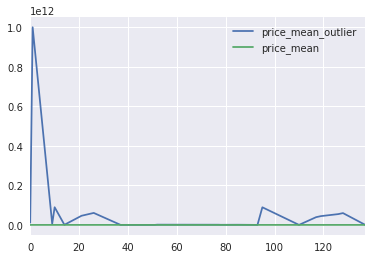

In [116]:
dtr_outliers_comp = dtr.loc[dtr['outlier']][['brand', 'price']].groupby(by='brand').mean().reset_index().dropna()
dtr_outliers_comp = pd.merge(dtr_outliers_comp, dtr.loc[~dtr['outlier']][['brand', 'price']], how='inner', on=['brand']).groupby(by='brand').mean().reset_index().dropna()
dtr_outliers_comp.columns = ['brand', 'price_mean_outlier', 'price_mean']
dtr_outliers_comp.plot()

Данные с нулевыми ценами, так же пометим, как выбросы.

In [34]:
dtr.loc[dtr['price'] == 0, 'outlier'] = True

Небольшое преобразование данных + дообогатим их курсами валют на текущую дату, 15 и 30 дней назад.

In [35]:
dtr['power_to_cap'] = 0
dts['power_to_cap'] = 0
dtr.loc[dtr['engineCapacity'] > 0, 'power_to_cap'] = dtr.loc[dtr['engineCapacity'] > 0, 'power']/dtr.loc[dtr['engineCapacity'] > 0, 'engineCapacity'] 
dts.loc[dts['engineCapacity'] > 0, 'power_to_cap'] = dts.loc[dts['engineCapacity'] > 0, 'power']/dts.loc[dts['engineCapacity'] > 0, 'engineCapacity'] 
col_num.append('power_to_cap')

In [42]:
dtr['brand_model_median'] = 0
dts['brand_model_median'] = 0
dtr_brand_model_median = dtr[['brand', 'model', 'price']].groupby(by=['brand', 'model']).agg(np.median).reset_index()
dtr['brand_model_median'] = pd.merge(dtr[['brand', 'model']], dtr_brand_model_median, how='inner', on=['brand', 'model'])['price']
dts['brand_model_median'] = pd.merge(dts[['brand', 'model']], dtr_brand_model_median, how='inner', on=['brand', 'model'])['price']
col_num.append('brand_model_median')

In [47]:
d_usdrub = pd.read_csv('usdrub.csv', delimiter=',')
d_usdrub = d_usdrub.ix[:, [2, 7]]
d_usdrub.columns = ['date', 'value']
d_usdrub['date'] = d_usdrub['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
d_usdrub = d_usdrub.set_index('date', drop=True)

d_usdrub = pd.concat([d_usdrub, d_usdrub.shift(15, 'D'), d_usdrub.shift(30, 'D')], axis=1).reset_index()
d_usdrub.dropna(inplace=True)
d_usdrub.columns = ['startTime_', 'xrate1', 'xrate2', 'xrate3']

d_usdrub = pd.concat([d_usdrub, pd.DataFrame([[pd.to_datetime('2017-01-22'), 59.6800, 59.6140, 60.9356]], columns=d_usdrub.columns)], axis=0, ignore_index=True)

In [60]:
dtr['startTime_'] = dtr['startTime'].astype('datetime64[D]')
dts['startTime_'] = dts['startTime'].astype('datetime64[D]')

In [61]:
dtr[['xrate1', 'xrate2', 'xrate3']] = pd.merge(dtr[['startTime_']], d_usdrub, how='left', on='startTime_')[['xrate1', 'xrate2', 'xrate3']]
dts[['xrate1', 'xrate2', 'xrate3']] = pd.merge(dts[['startTime_']], d_usdrub, how='left', on='startTime_')[['xrate1', 'xrate2', 'xrate3']]
col_num.append(['xrate1', 'xrate2', 'xrate3'])

In [5]:
dtr = dtr[~dtr['outlier']]

In [6]:
print(dtr.shape, dts.shape)

(2144997, 24) (416023, 23)


In [7]:
d_cat = pd.concat([dtr[col_cat], dts[col_cat]], axis=0)
d_num = pd.concat([dtr[col_num], dts[col_num]], axis=0)

In [8]:
print(d_cat.shape, d_num.shape)

(2561020, 10) (2561020, 9)


MAPE до этого не известная мне метрика.
Для моделей с функцией оптимизации второго порядка не работает совсем, т.к. Гессиан функции обращается в ноль.
Тут https://arxiv.org/pdf/1605.02541.pdf указывают на то, что ее можно посчитать в моделях регрессии, как MAE + задать веса для каждого тренировочного примера.
Я тренировал нейронную сеть с прямой связью + использовал различные трансформации целевой переменной.

In [9]:
enc = OneHotEncoder(sparse=False) 
scaler = StandardScaler()

X = np.array(d_num)
X[:, -3] = X[:, -3] - X[:, -2]
X[:, -2] = X[:, -2] - X[:, -1]
X = scaler.fit_transform(X)
X = np.hstack([X, enc.fit_transform(d_cat).astype(np.int8)])

In [10]:
y = np.array(dtr[col_tar])

In [11]:
y_ = np.log1p(y)

In [26]:
"""
# box-cox transformation
from scipy.stats import boxcox
from scipy.special import inv_boxcox
y_ = boxcox(y)
# standard scale
y = dtr[col_tar]
y = scaler.fit_transform(y)
# standard scale without mean
y_n = dtr[col_tar]
scaler_n = StandardScaler(with_mean=False)
y_n = scaler_n.fit_transform(y_n)
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
y_mx = dtr[col_tar]
scaler_mx = MinMaxScaler()
y_mx = scaler_mx.fit_transform(y_mx)
"""

In [12]:
X, X_p = X[:dtr.shape[0], :], X[dtr.shape[0]:, :]

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y_)

In [ ]:
# froscipy.specialpecial.inv_boxcox

In [14]:
from keras.layers import Dense, Dropout, Activation, Merge
from keras.models import Sequential 
from keras.regularizers import l1 
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adadelta, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

from sklearn.preprocessing import StandardScaler 
from scipy import sparse

Using TensorFlow backend.


In [15]:
checkpoint_callback = ModelCheckpoint(filepath='keras_')
early_stopping_callback = EarlyStopping(min_delta = 0.05, patience=2)

In [16]:
optimizer_ = Adam(lr=0.0005)
# optimizer_ = Adadelta(lr=0.5)
# optimizer_ = SGD(lr=0.1)
# optimizer_ = 'rmsprop'

dropout = 0.4
init = 'glorot_normal'
activation = 'relu'

N = X_tr.shape[1]
N_d = 3

model_d = Sequential()
model_d.add(Dense(int(N/N_d), input_dim=N, init=init, W_regularizer=l1(0.0001)))
model_d.add(Activation(activation))
model_d.add(BatchNormalization())
model_d.add(Dropout(dropout))

model_d.add(Dense(int(N/N_d), init=init))
model_d.add(Activation(activation))
model_d.add(BatchNormalization())
model_d.add(Dropout(dropout))

model_d.add(Dense(1, init=init))
model_d.add(Activation('linear'))

model_w = Sequential()
model_w.add(Dense(1, input_dim=N, init=init))
model_w.add(Activation('linear'))

model = Sequential()
model.add(Merge([model_w, model_d], mode='concat', concat_axis=1))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_absolute_percentage_error', optimizer=optimizer_, metrics=['mae', 'mse'])

model.summary()
hist = model.fit([X_tr, X_tr], y_tr, validation_data = ([X_te, X_te], y_te), epochs=100, batch_size=64, callbacks=[checkpoint_callback, early_stopping_callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 1,859,806.0
Trainable params: 1,857,086.0
Non-trainable params: 2,720.0
_________________________________________________________________
Train on 1608747 samples, validate on 536250 samples
Epoch 1/100
1608747/1608747 [==============================] - 319s - loss: 5.1362 - mean_absolute_error: 0.4786 - mean_squared_error: 2.8061 - val_loss: 2.9615 - val_mean_absolute_error: 0.2180 - val_mean_squared_error: 0.3207
Epoch 2/100
1608747/1608747 [==============================] - 336s - loss: 2.9569 - mean_absolute_error: 0.2188 - mean_squared_error: 0.3197 - val_loss: 2.9156 - val_mean_absolute_error: 0.2156 - val_mean_squared_error: 0.3189
Epoch 3/1

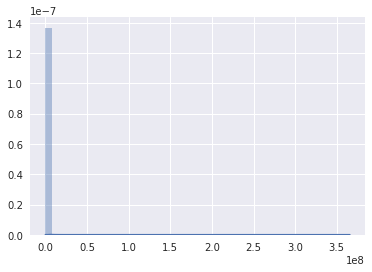

In [17]:
y_pred = model.predict([X_p, X_p])
y_pred = np.expm1(y_pred)
sns.distplot(y_pred)

In [18]:
dts['price'] = y_pred

In [19]:
dts[['id', 'price']].to_csv('prediction.csv')

Про оценку диапозона цен. Если за функцию потерь взять RMSE, то точкой, минимизирующих данную функцию, будет среднее распределения. Оценив среднее и точность регрессии, предположив, скажем, что для каждой марки цена распределена нормально, можно оценить диапозон цен.